# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons',  'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='redchris',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_st',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', options=('redchris', 'goldenbear', 'equitysilver', 'test'), value='redchri…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AA…

Dropdown(description='Objective:', index=2, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_st')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/redchris_c_curves_p.pkl
Loaded data from ./inputs/curves/redchris_c_curves_f.pkl


In [11]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19', '19')
found match for mask ('?', '?', '?', '?', '20', '20')
found match for mask ('?', '?', '?', '?', '21', '21')
found match for mask ('?', '?', '?', '?', '22'

Running for redchris_max_st_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0x798ab4dc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3046833e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.01 work units)
Optimal objective  7.304683346e+07


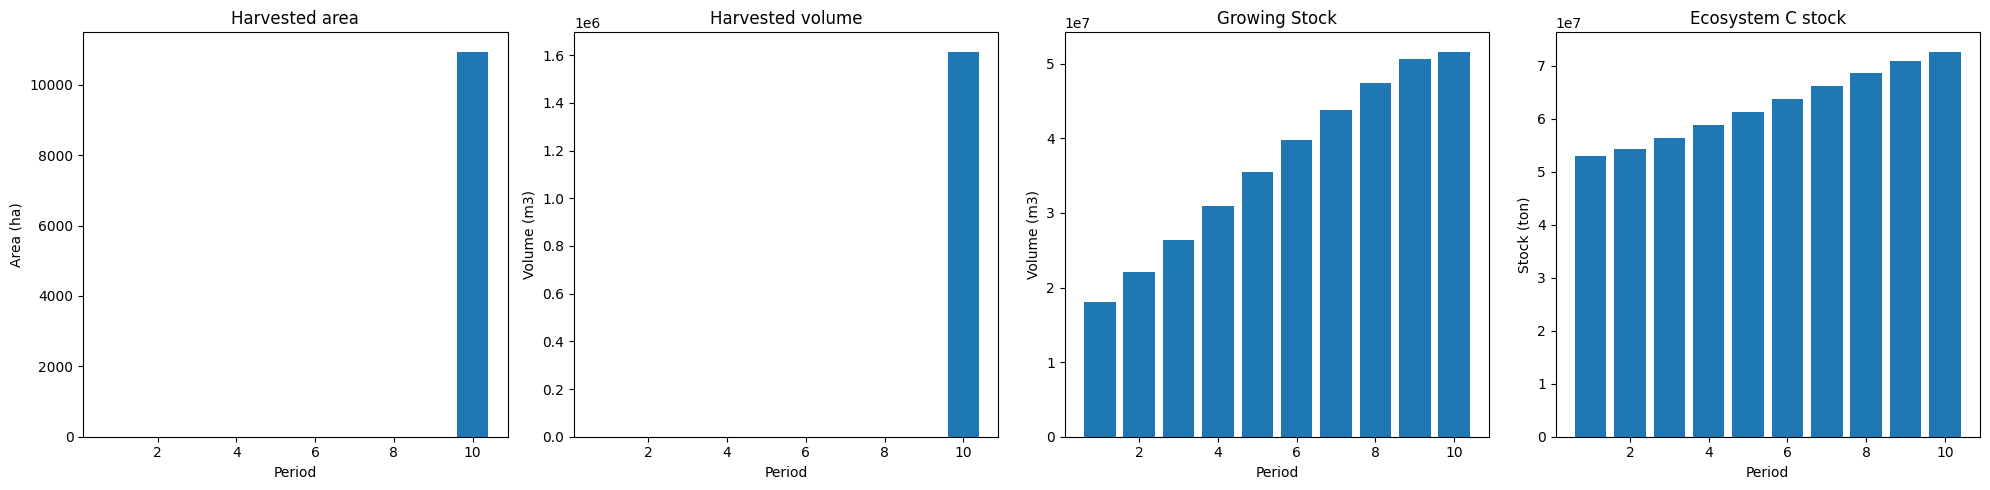

Plot saved to ./outputs/fig/redchris/redchris_max_st_no_cons_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1707
The economic indicator (the provincial government revenues) is:  58222
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


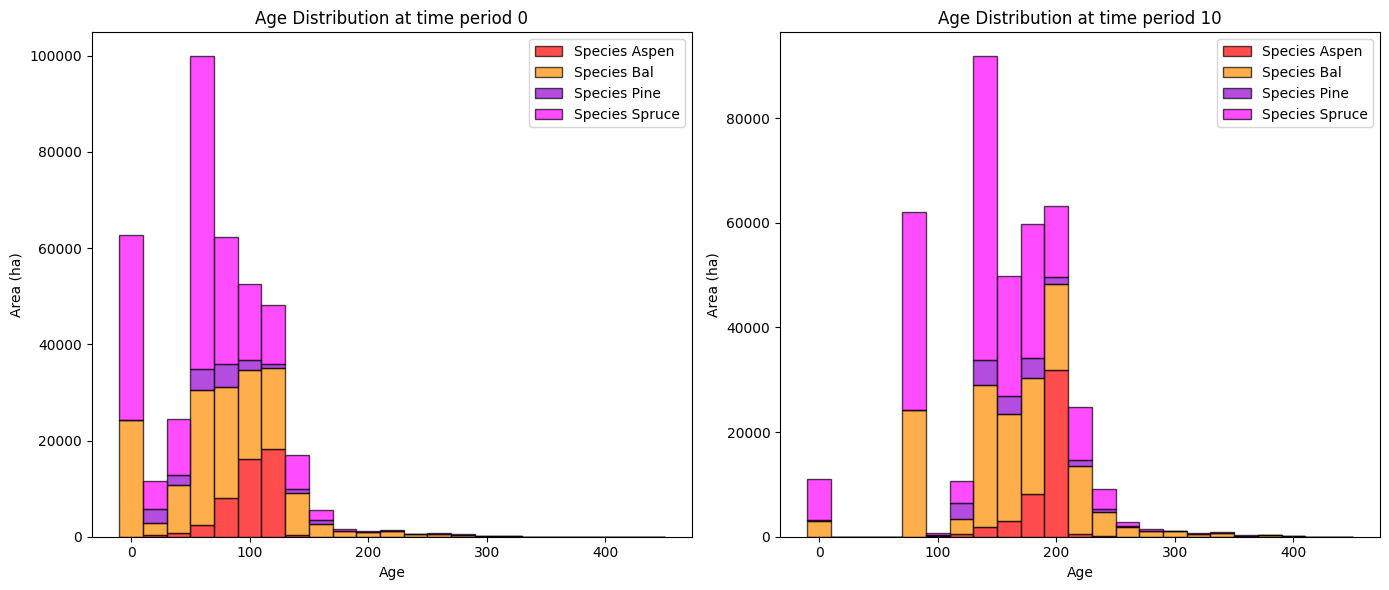

Plot saved to ./outputs/fig/redchris/redchris_max_st_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  44508.623748  43563.310060
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  41982.529873  40909.715466

Old growth has **increased** by 143187.49 hectares from time period 0 to time period 10.


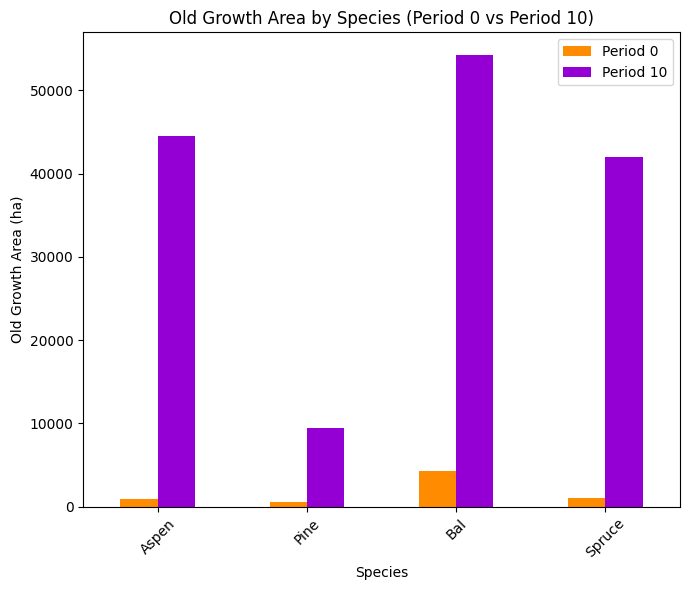

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8186

Diversity has **decreased** by 6.62% from time 0 to time 10.


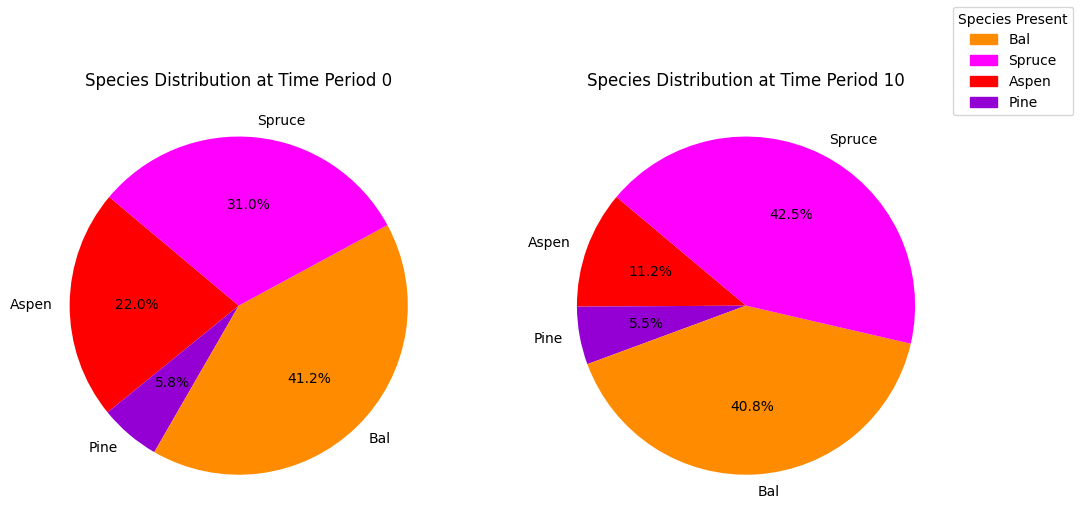

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_no_cons_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.19s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s



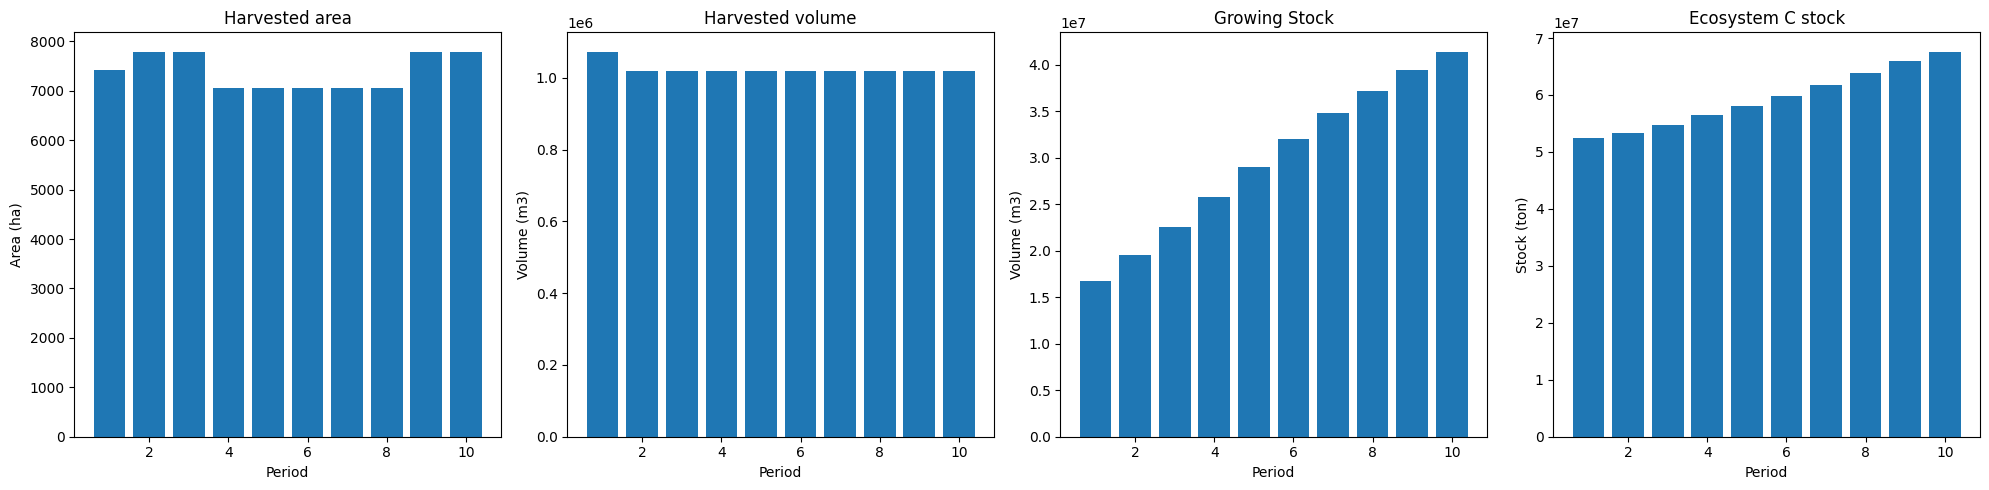

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


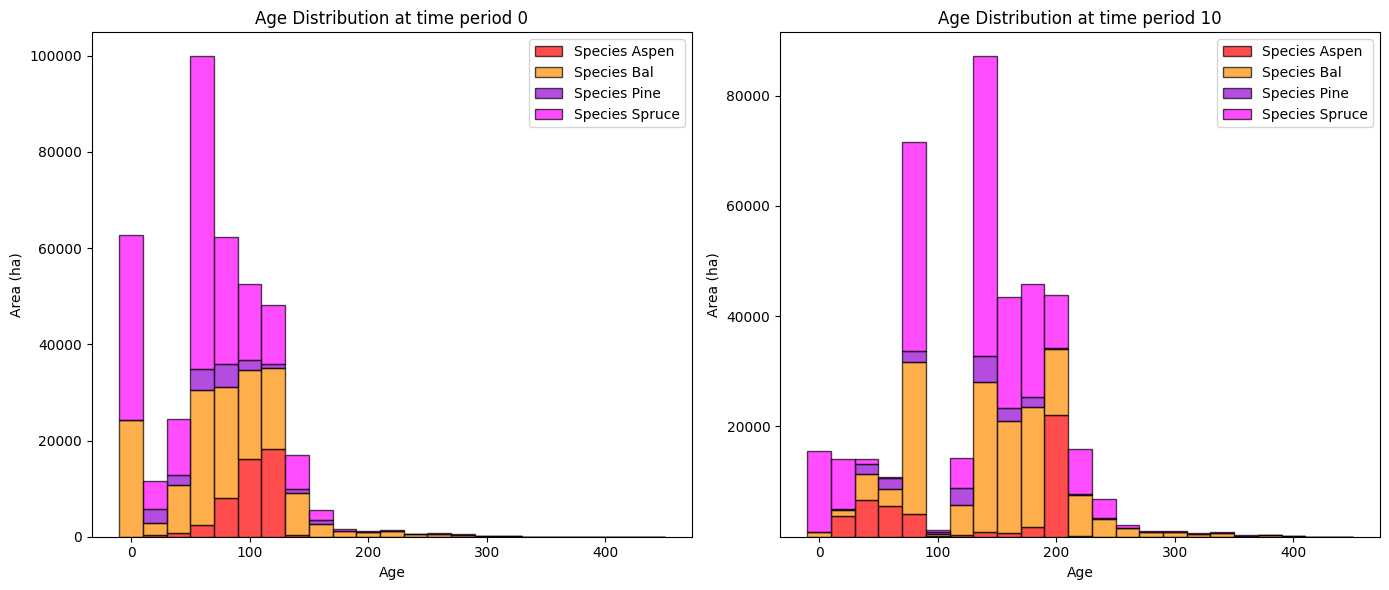

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


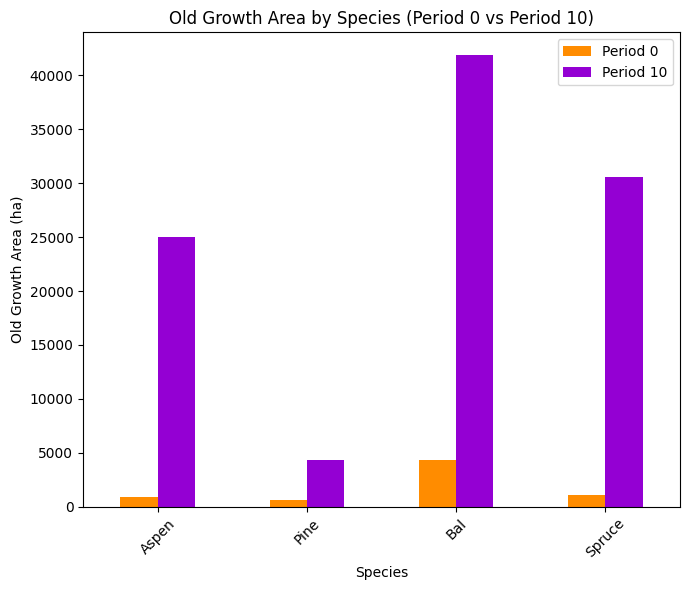

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


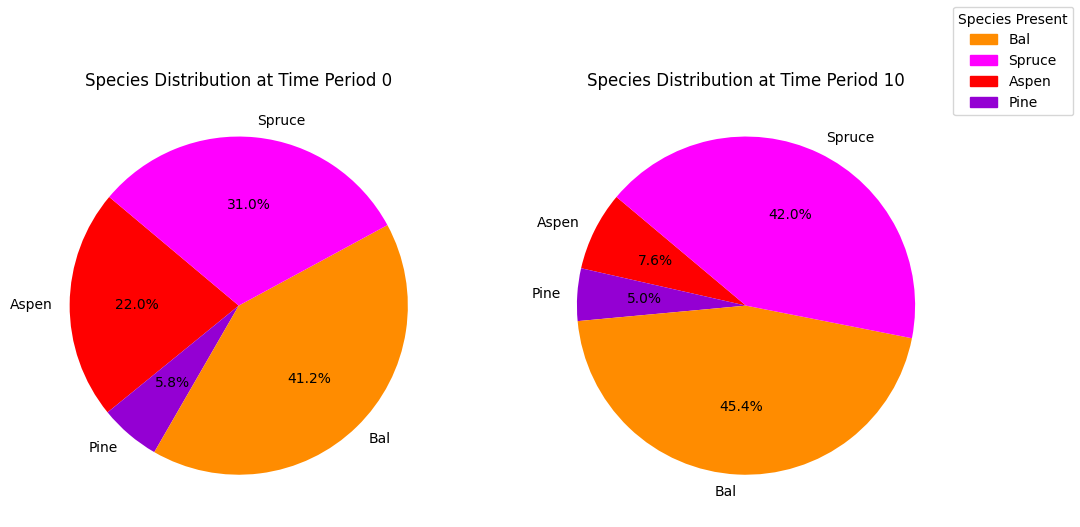

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


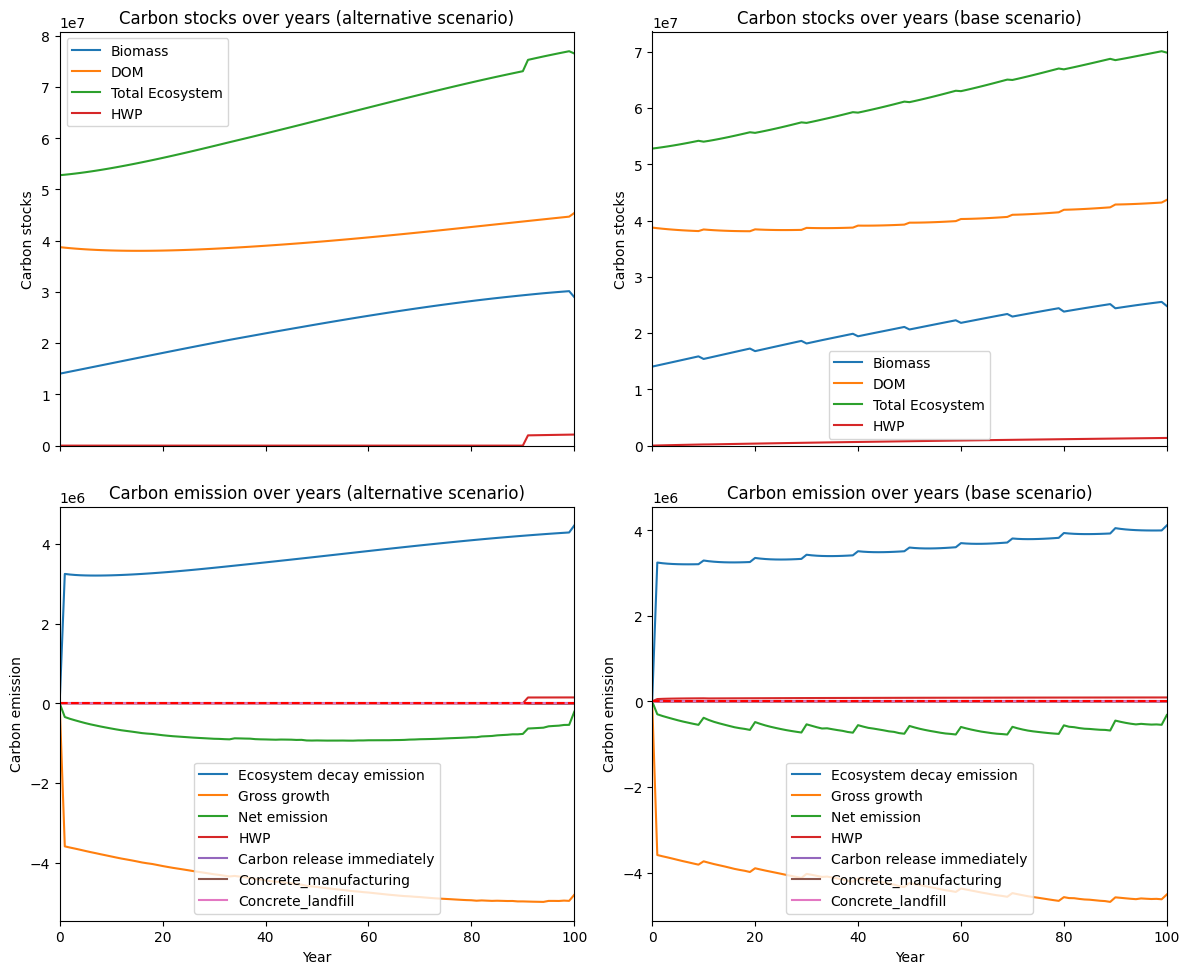

---------------------------------------------------------------------------------------
Net emission difference -18588491.723519176
Net emission base scenario -61347742.78335276
Net emission alternative scenario -79936234.50687195
dollar_per_ton is:  0.5379672621500244
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  19450.593103  19450.593103
Pine    0.0   5099.887704   5099.887704
Bal     0.0  12334.956440  12334.956440
Spruce  0.0  11365.662665  11365.662665

Overall, the old growth area has **increased** by 48251.10 hectares in the alternative scenario compared to the base scenario.


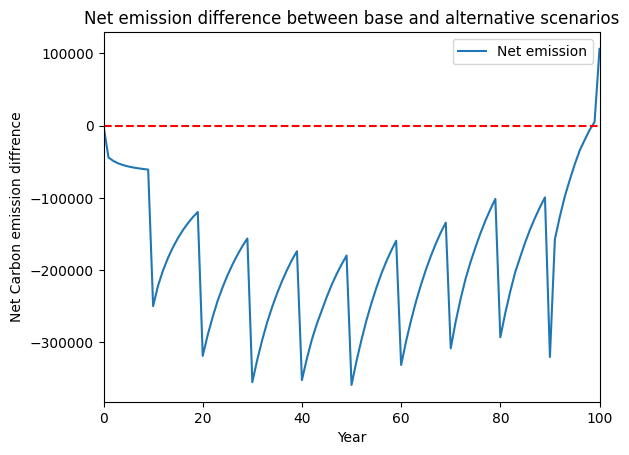

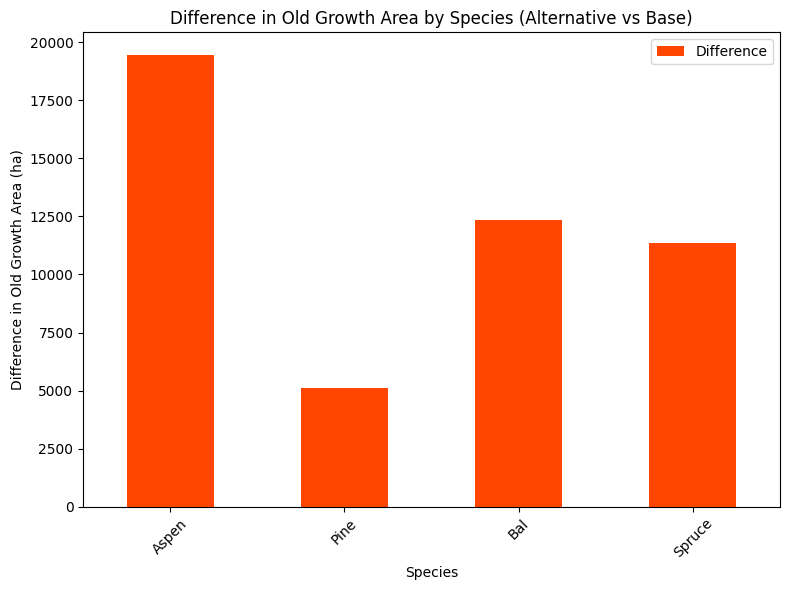

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


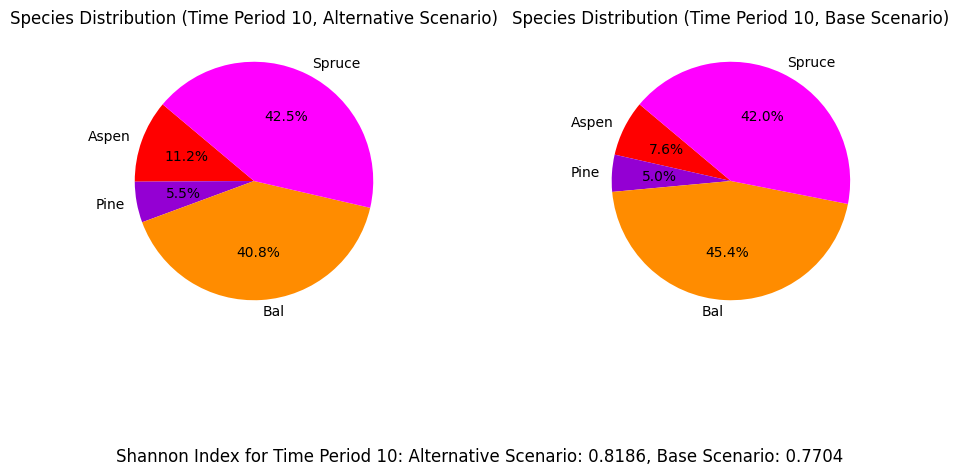

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3707 rows, 34533 columns and 445161 nonzeros
Model fingerprint: 0x8dcbed1a
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2009 rows and 2005 columns
Presolve time: 0.10s
Presolved: 1698 rows, 32528 columns, 415336 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.

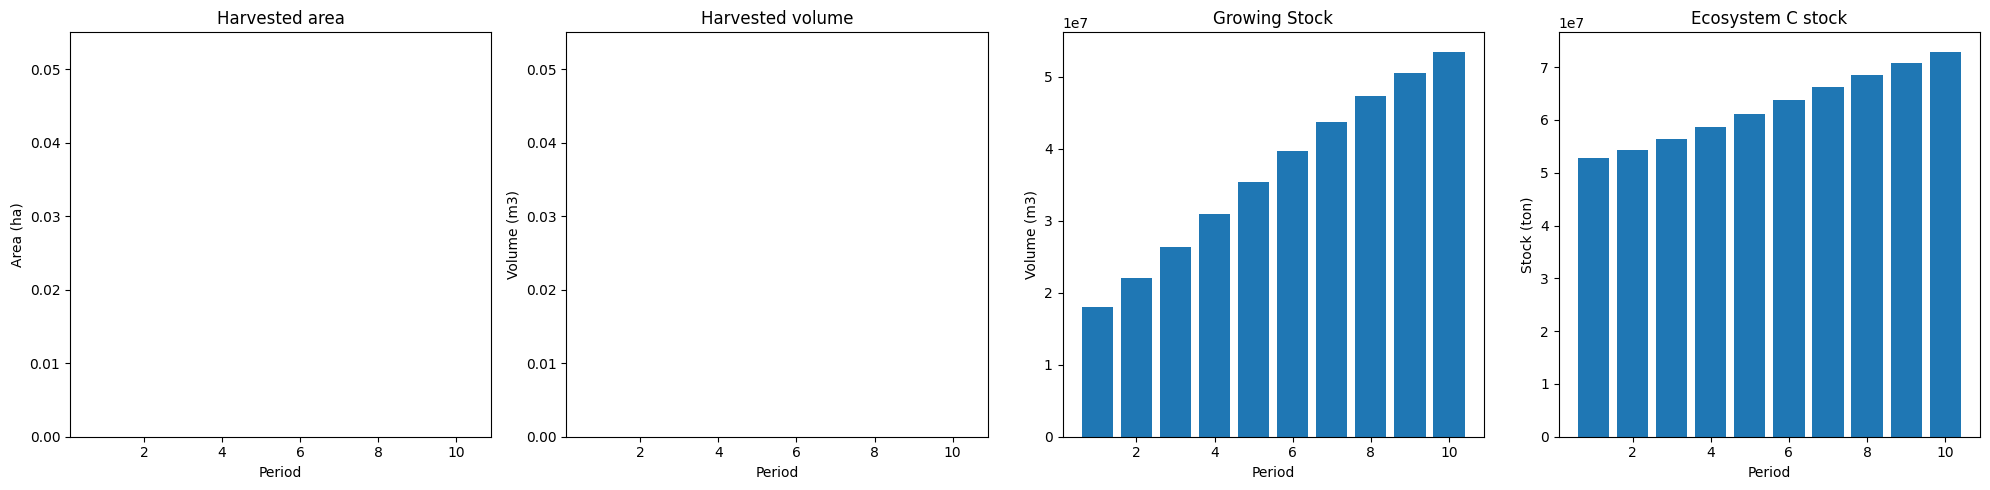

Plot saved to ./outputs/fig/redchris/redchris_max_st_evenflow_cons_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


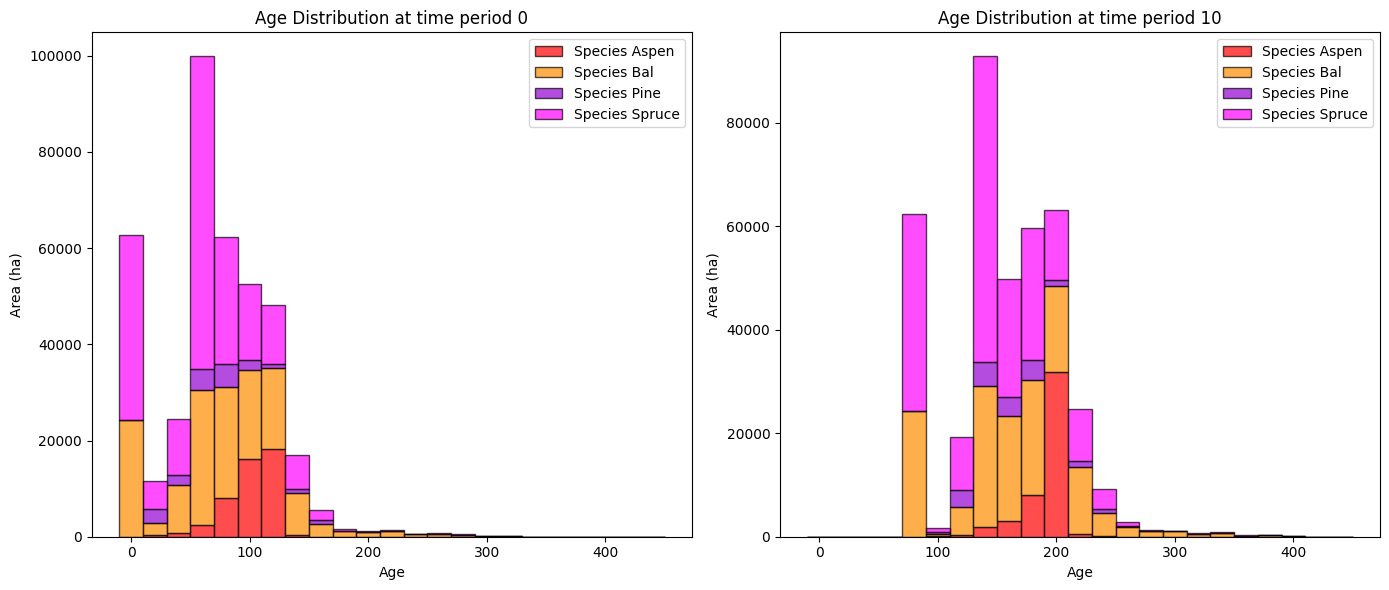

Plot saved to ./outputs/fig/redchris/redchris_max_st_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  44508.623748  43563.310060
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  42096.061799  41023.247392

Old growth has **increased** by 143301.02 hectares from time period 0 to time period 10.


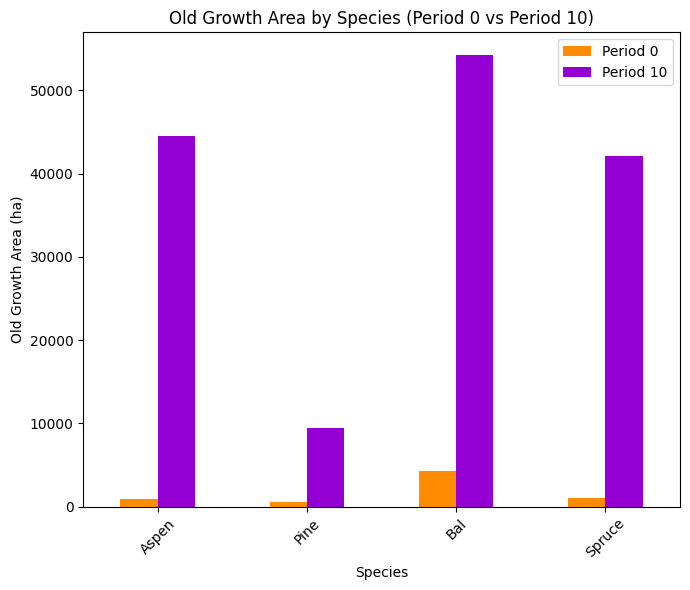

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8120

Diversity has **decreased** by 7.28% from time 0 to time 10.


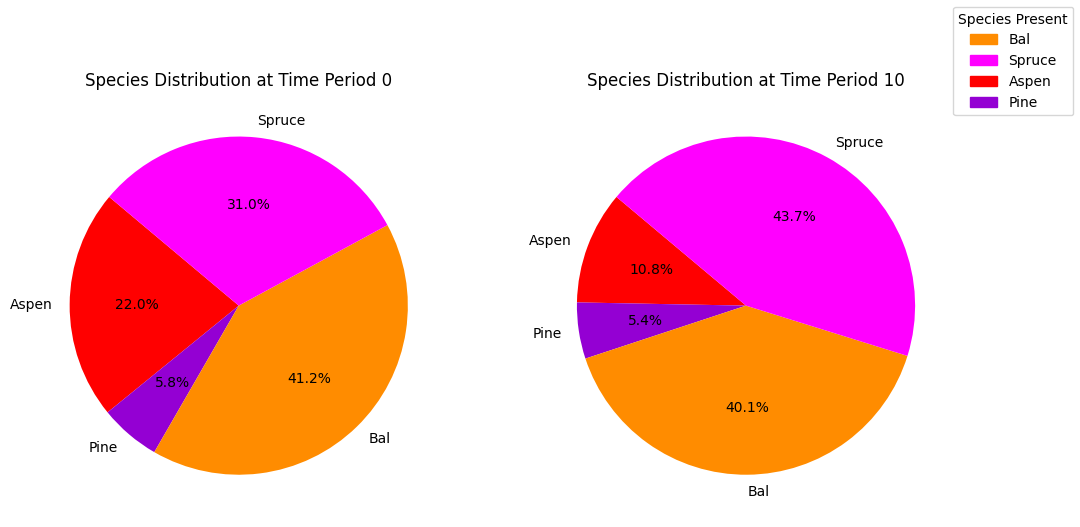

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_evenflow_cons_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

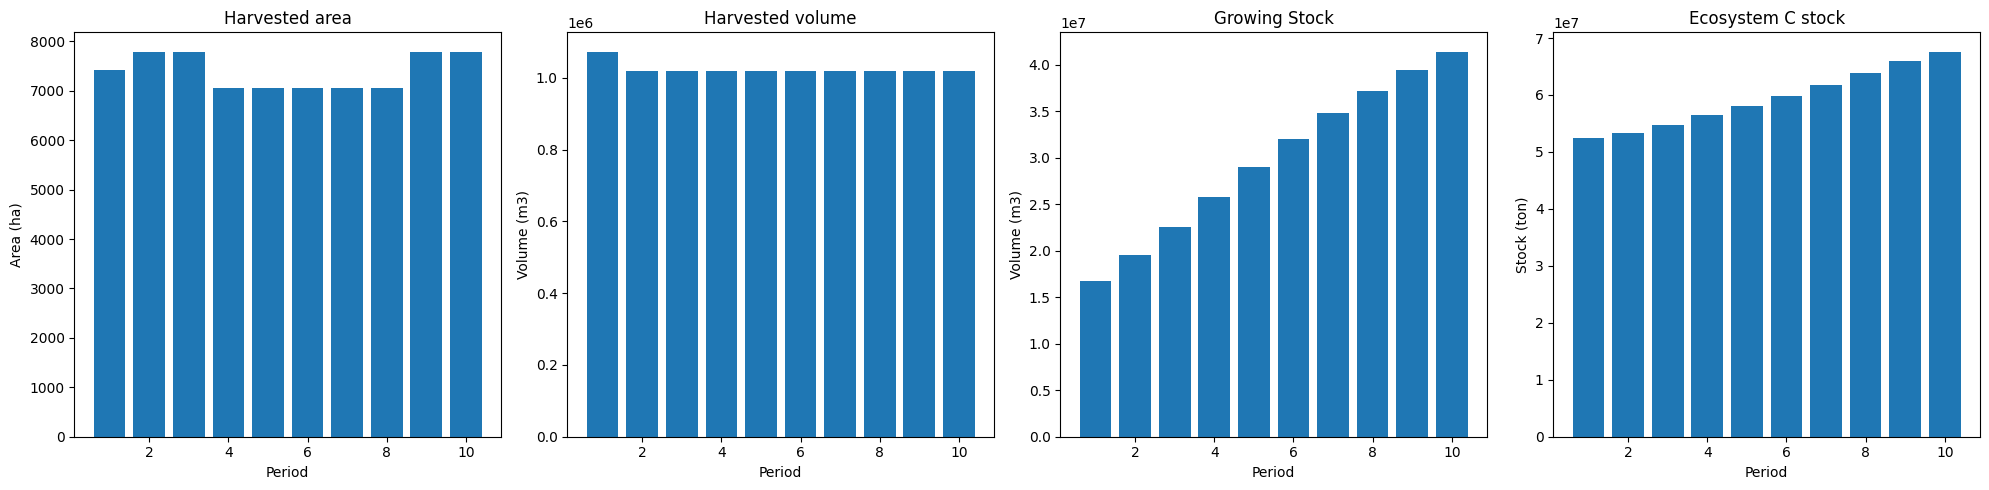

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


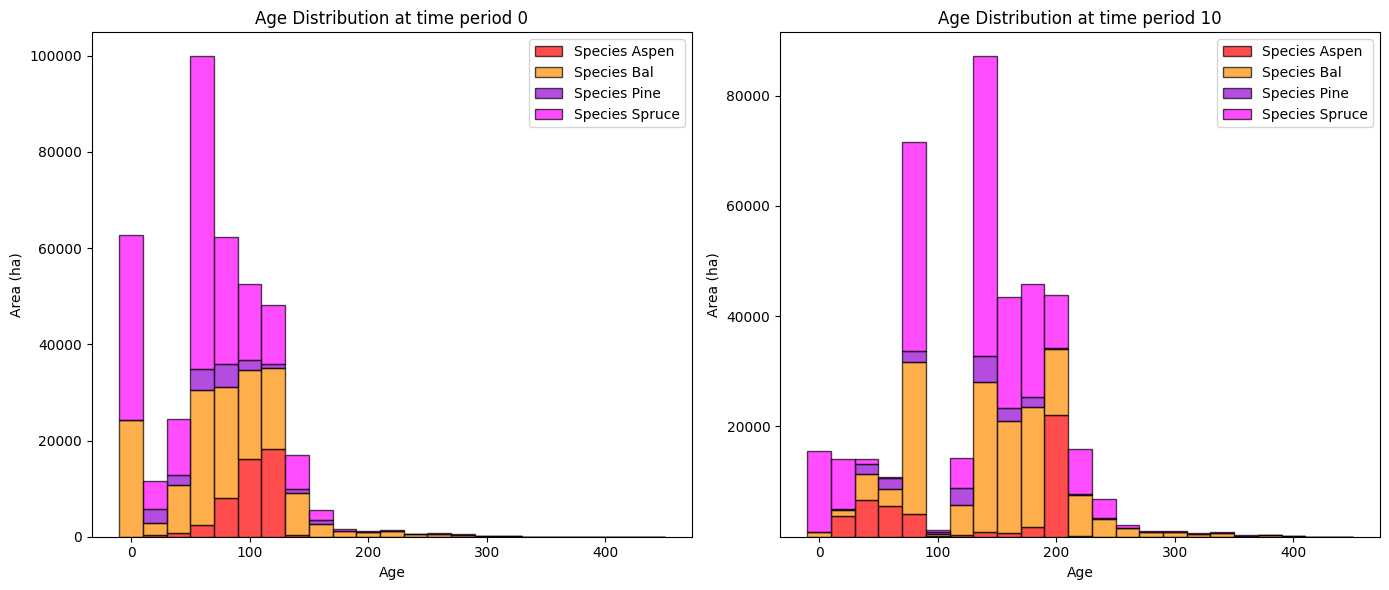

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


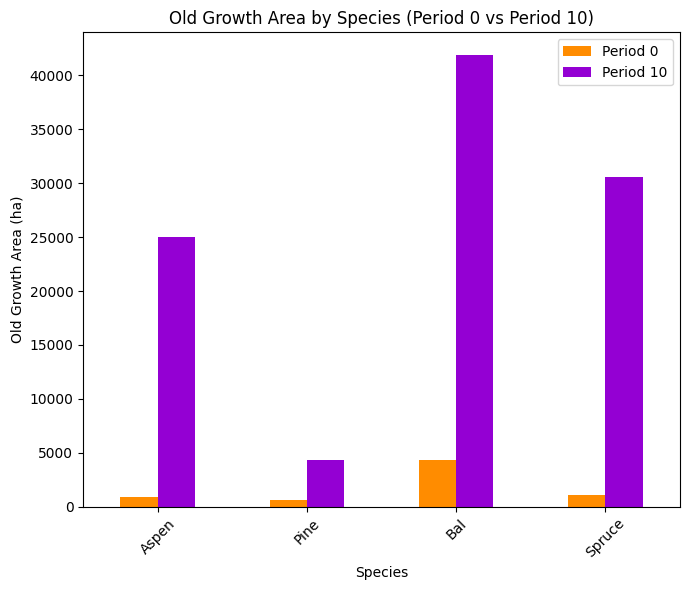

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


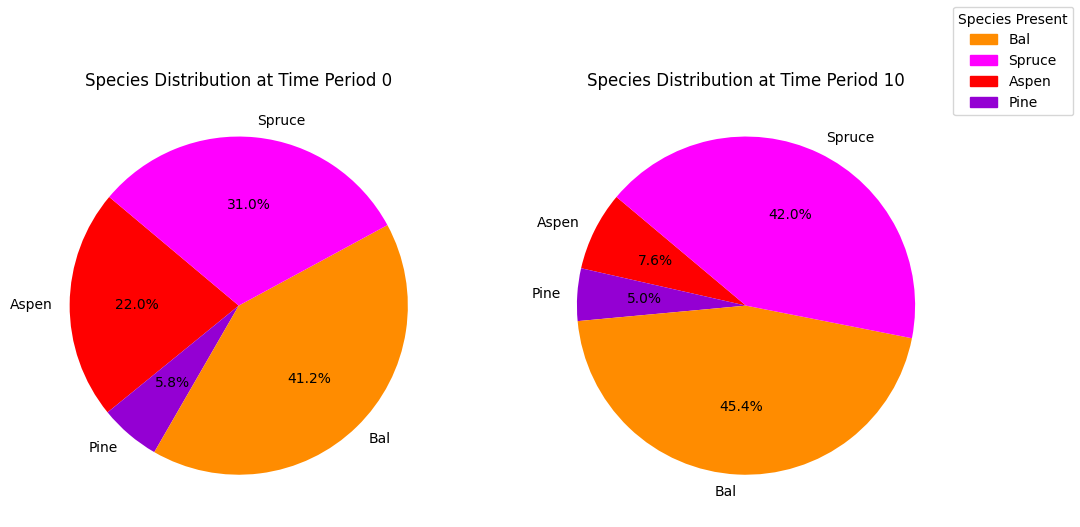

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


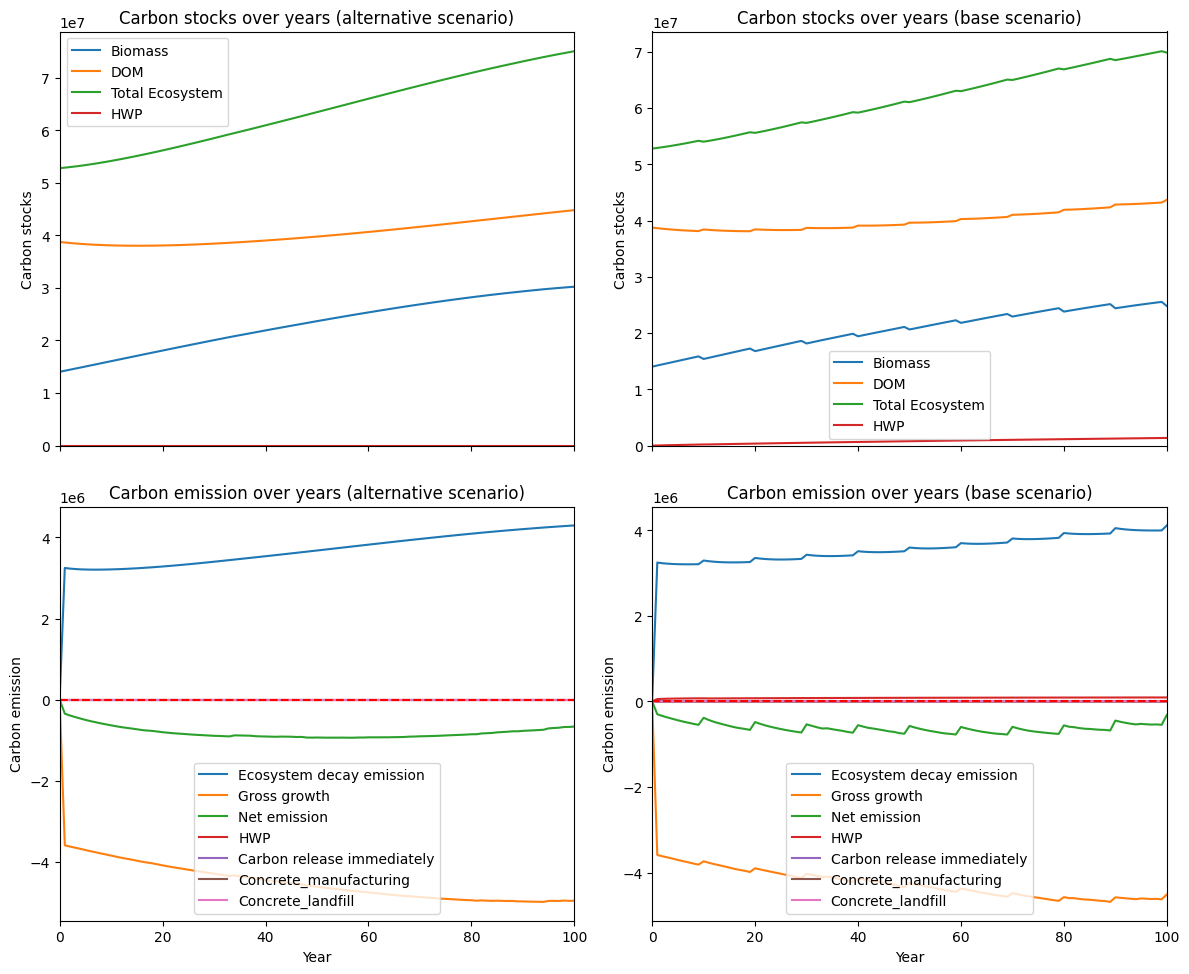

---------------------------------------------------------------------------------------
Net emission difference -20204532.837261986
Net emission base scenario -61347742.78335276
Net emission alternative scenario -81552275.62061478
dollar_per_ton is:  0.49493844181131524
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  19450.593103  19450.593103
Pine    0.0   5099.887704   5099.887704
Bal     0.0  12334.956440  12334.956440
Spruce  0.0  11479.194591  11479.194591

Overall, the old growth area has **increased** by 48364.63 hectares in the alternative scenario compared to the base scenario.


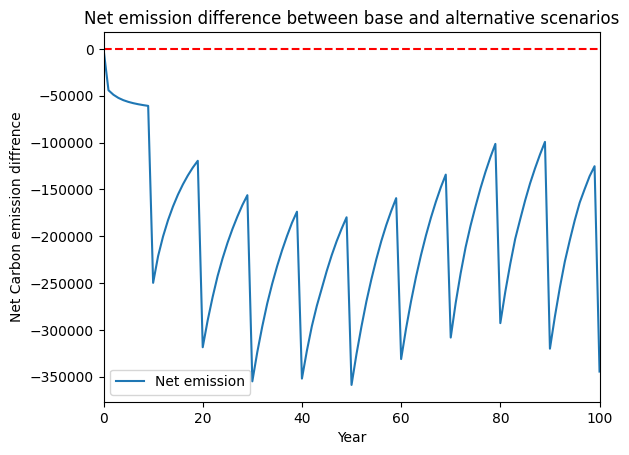

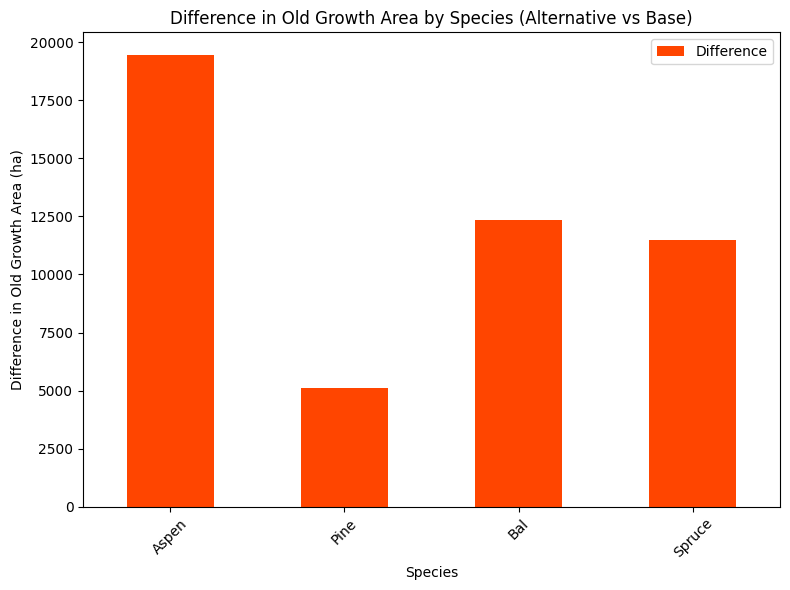

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


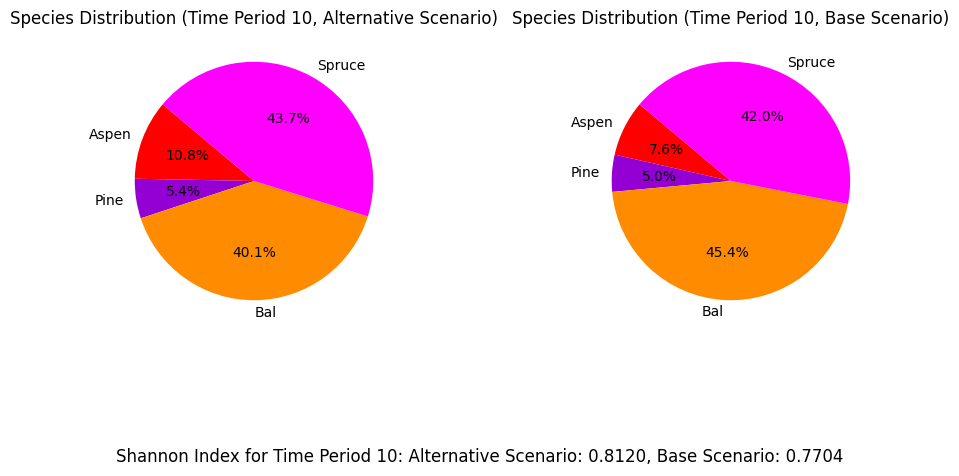

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_90%...
running the scenario for the Red Chris mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x27aa76b9
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

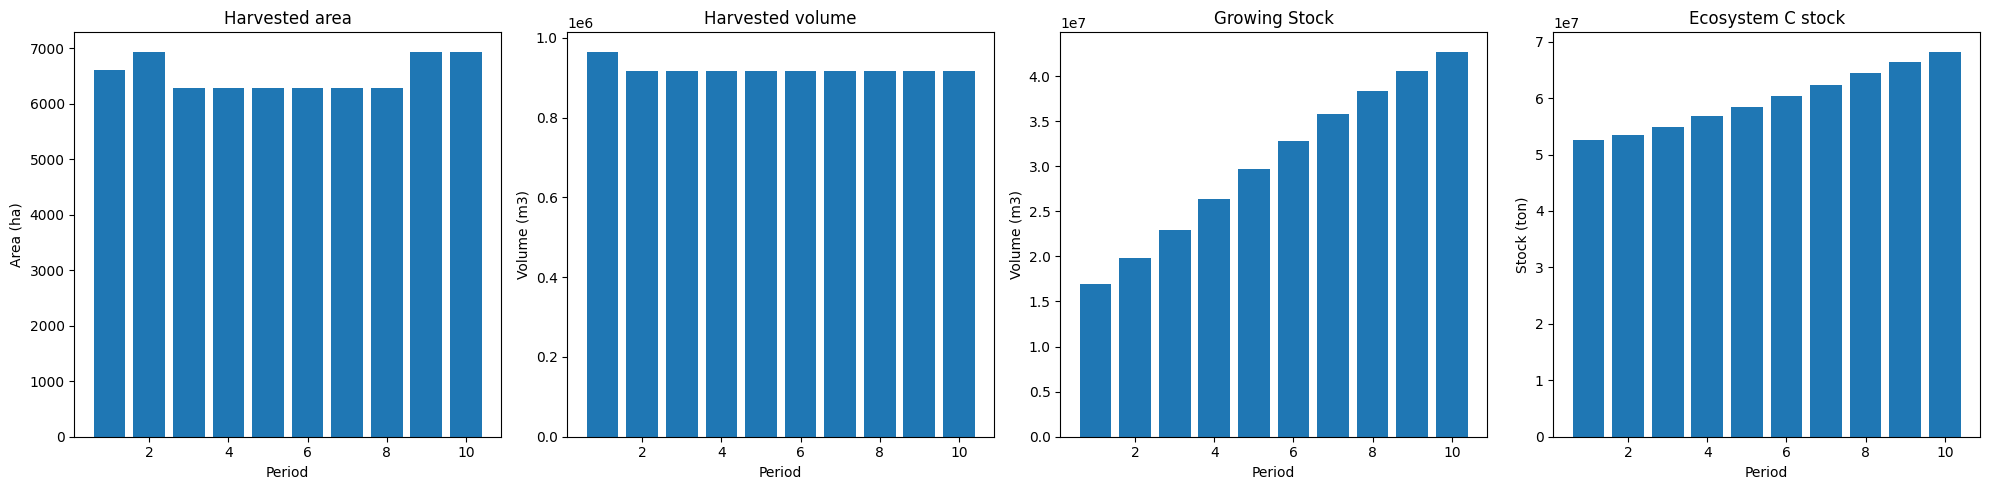

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_90%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  9748
The economic indicator (the provincial government revenues) is:  332454
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


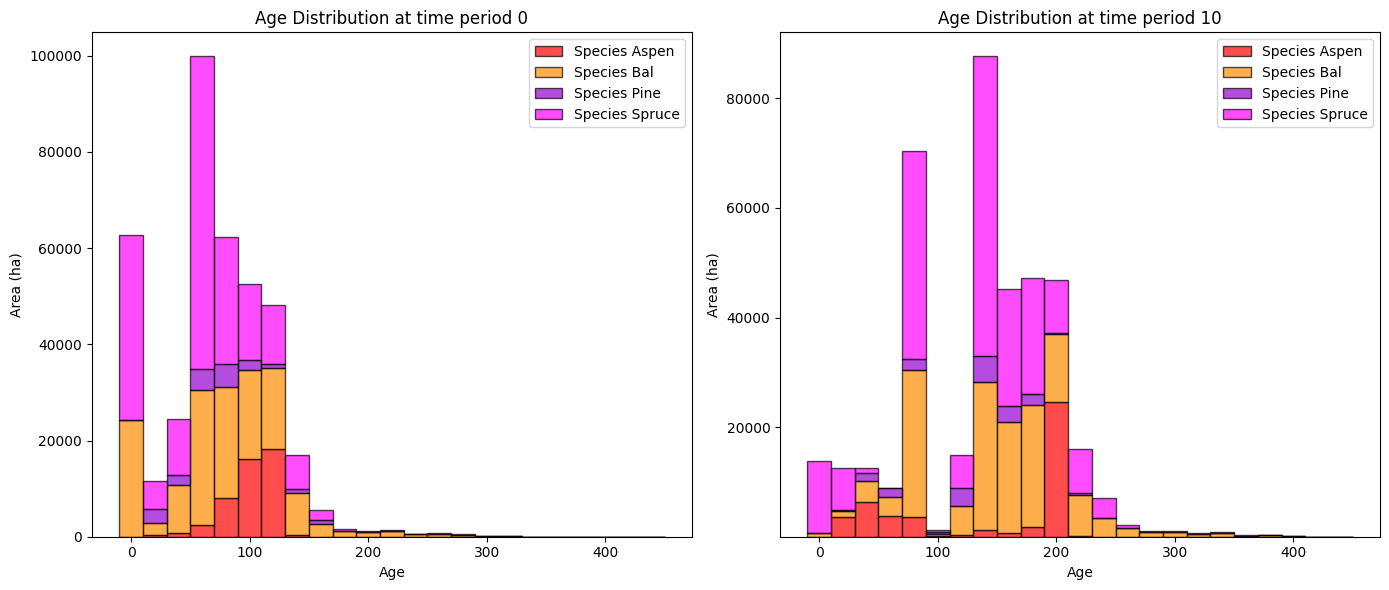

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  27664.296558  26718.982870
Pine     602.782616   4785.462676   4182.680060
Bal     4315.588546  42994.788238  38679.199692
Spruce  1072.814408  31555.194248  30482.379840

Old growth has **increased** by 100063.24 hectares from time period 0 to time period 10.


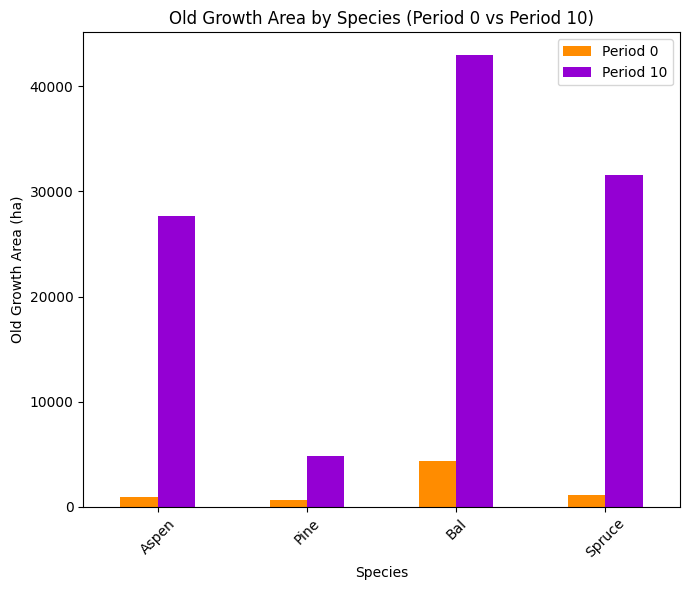

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7760

Diversity has **decreased** by 10.88% from time 0 to time 10.


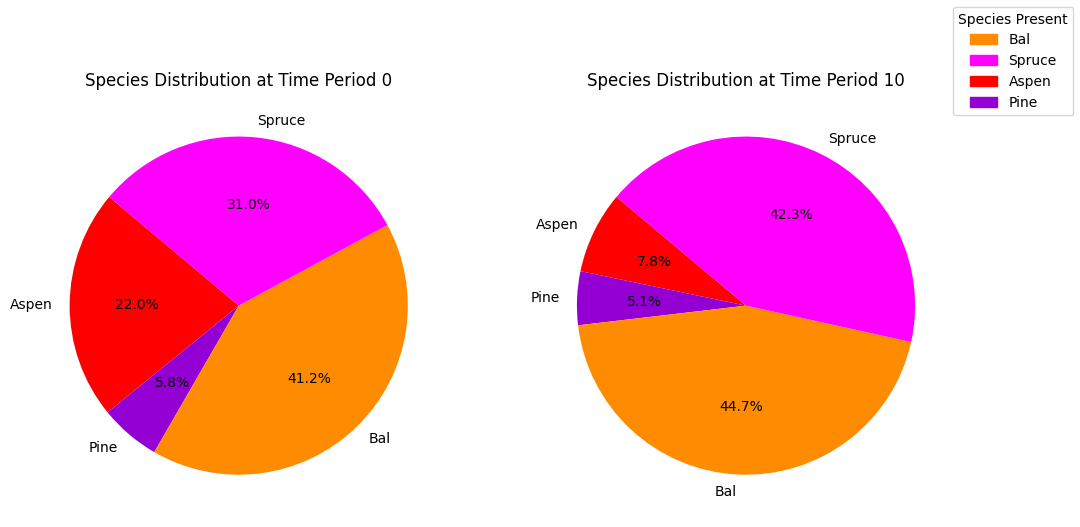

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_90%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

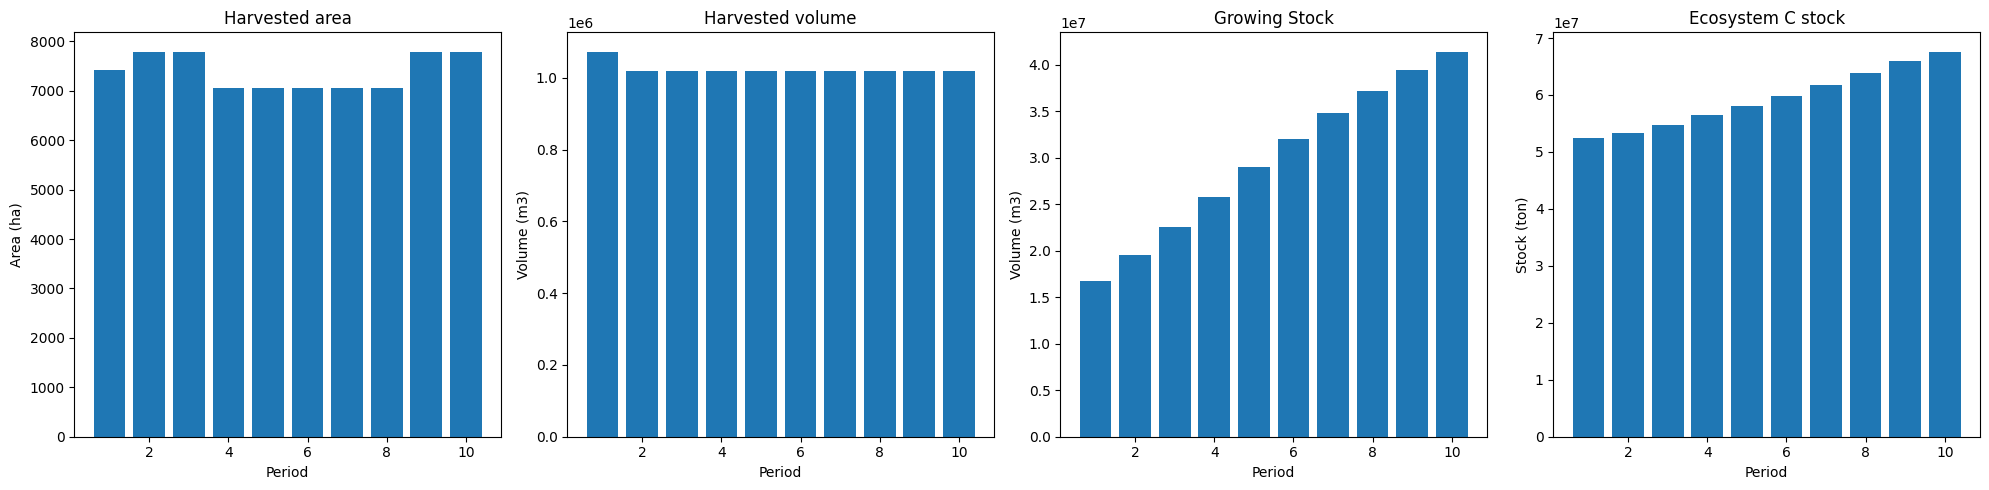

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


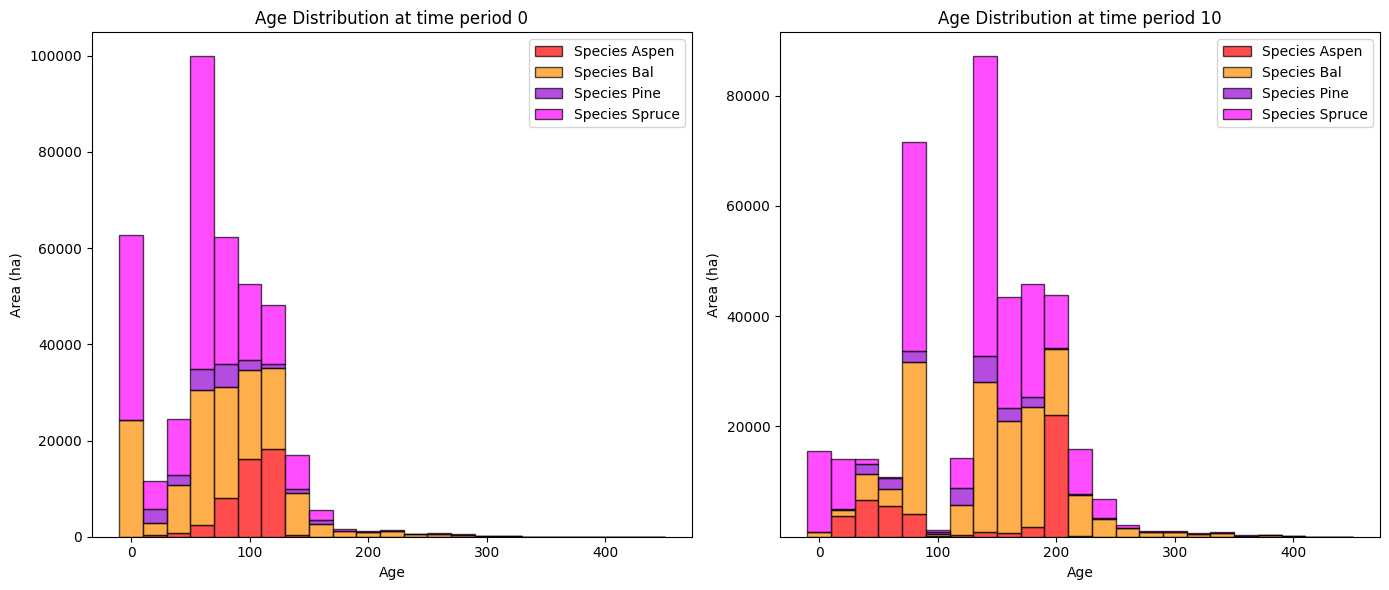

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


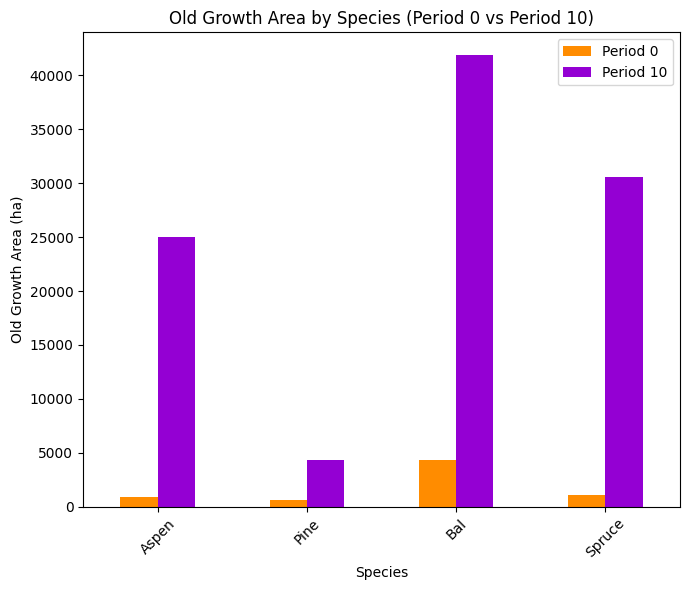

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


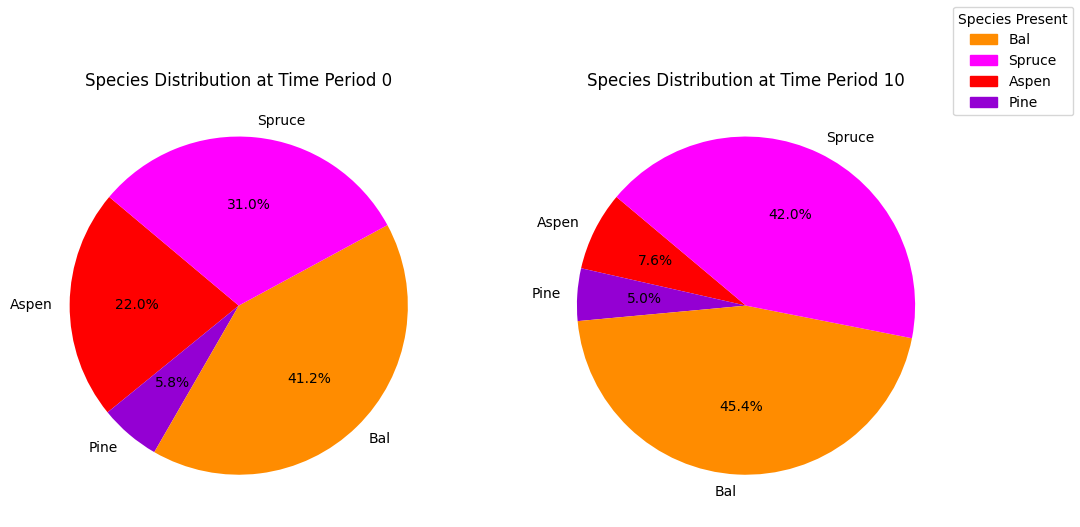

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


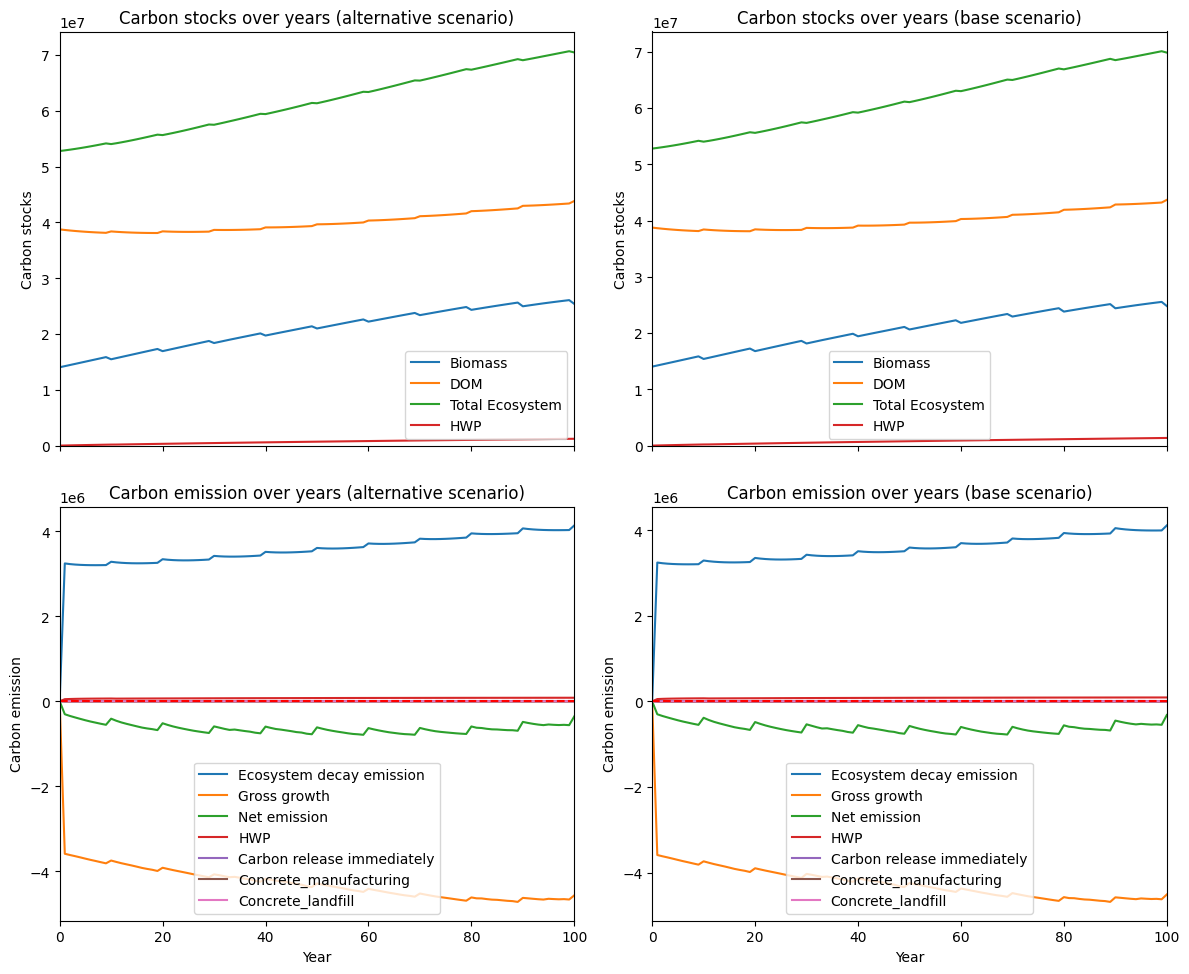

---------------------------------------------------------------------------------------
Net emission difference -2362875.677366227
Net emission base scenario -61347742.78335276
Net emission alternative scenario -63710618.46071899
dollar_per_ton is:  4.232131252519588
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  2606.265913  2606.265913
Pine    0.0   495.364107   495.364107
Bal     0.0  1086.899412  1086.899412
Spruce  0.0   938.327040   938.327040

Overall, the old growth area has **increased** by 5126.86 hectares in the alternative scenario compared to the base scenario.


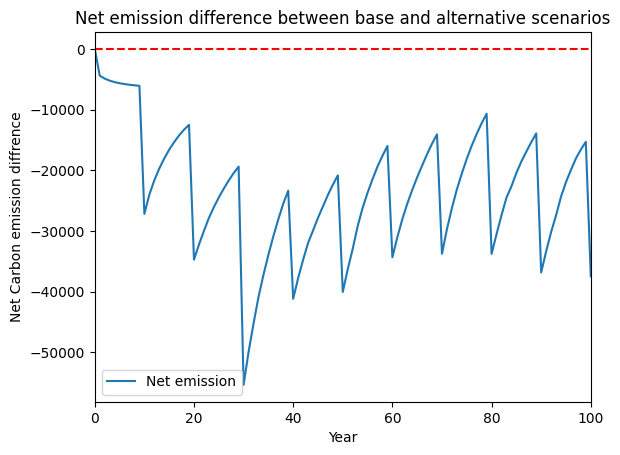

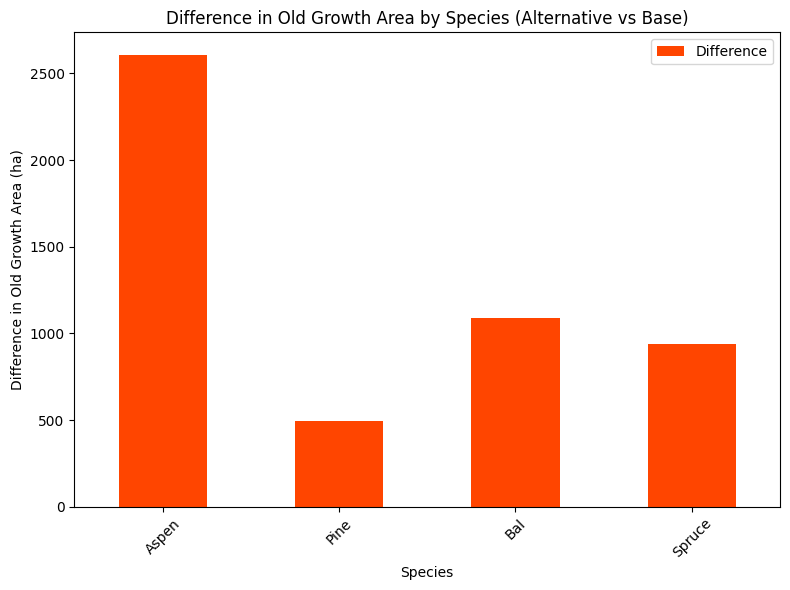

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


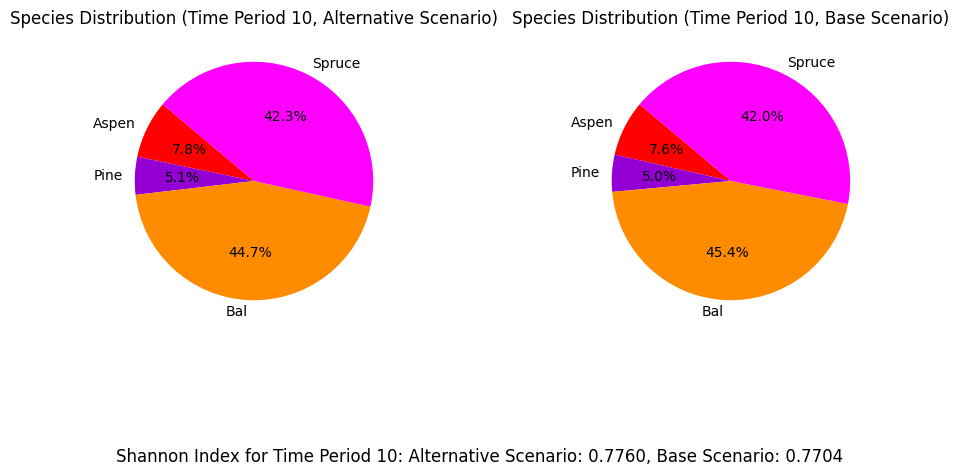

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_80%...
running the scenario for the Red Chris mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xc38b8c0f
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32529 column

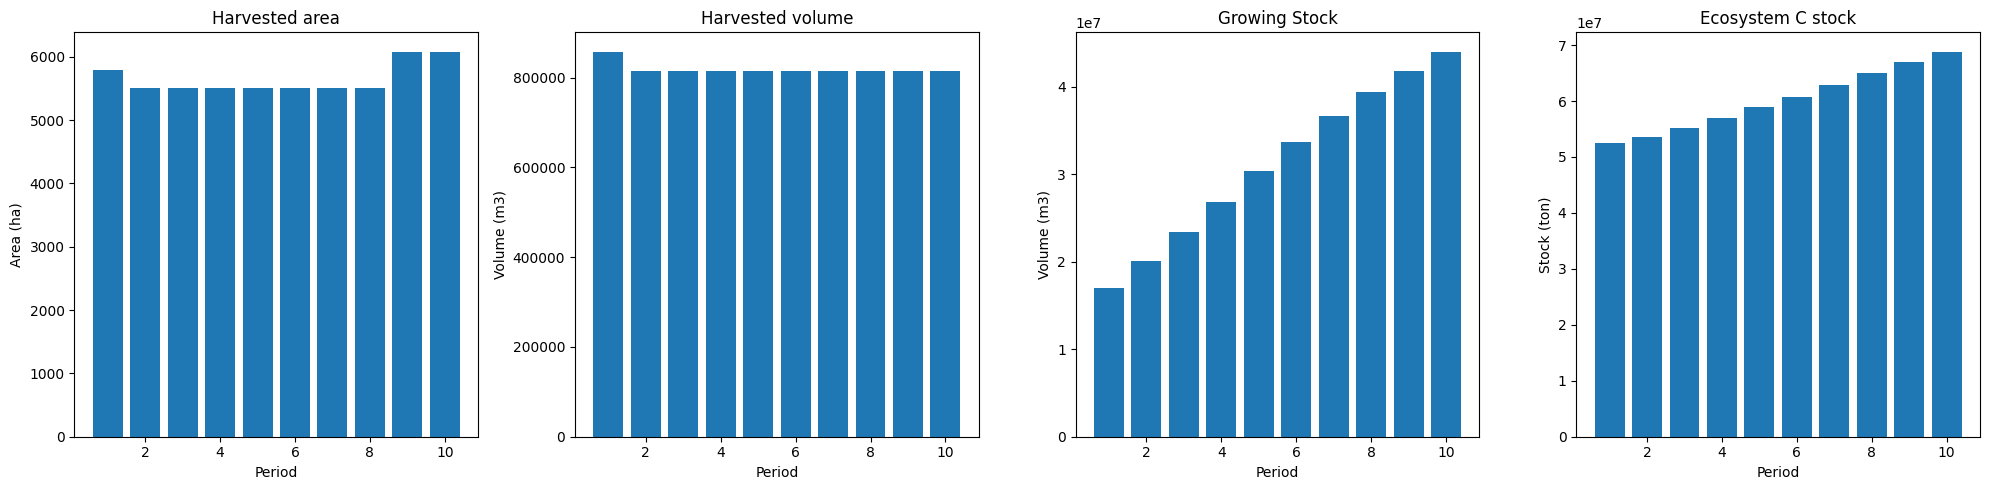

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_80%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8665
The economic indicator (the provincial government revenues) is:  295514
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


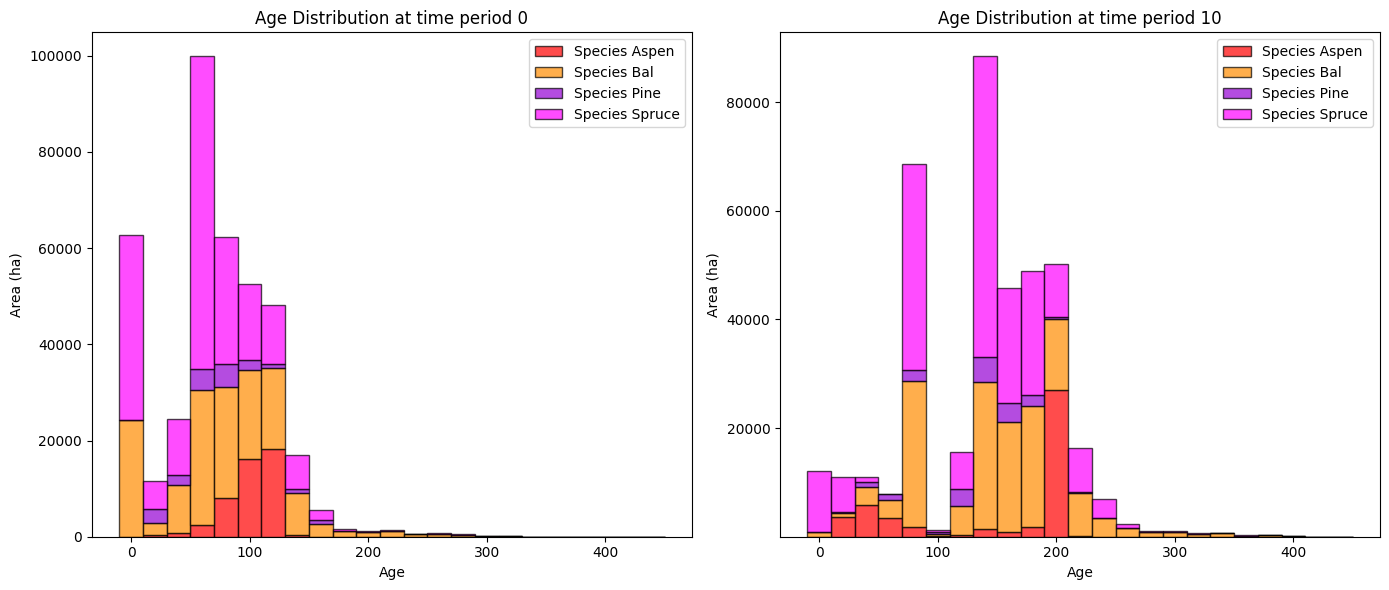

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  30128.566818  29183.253130
Pine     602.782616   5461.238010   4858.455393
Bal     4315.588546  43964.511625  39648.923079
Spruce  1072.814408  32721.845740  31649.031333

Old growth has **increased** by 105339.66 hectares from time period 0 to time period 10.


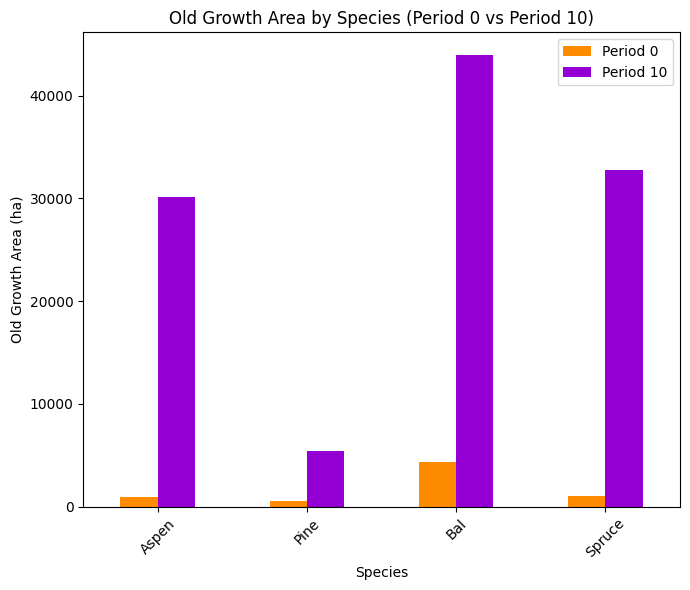

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7818

Diversity has **decreased** by 10.31% from time 0 to time 10.


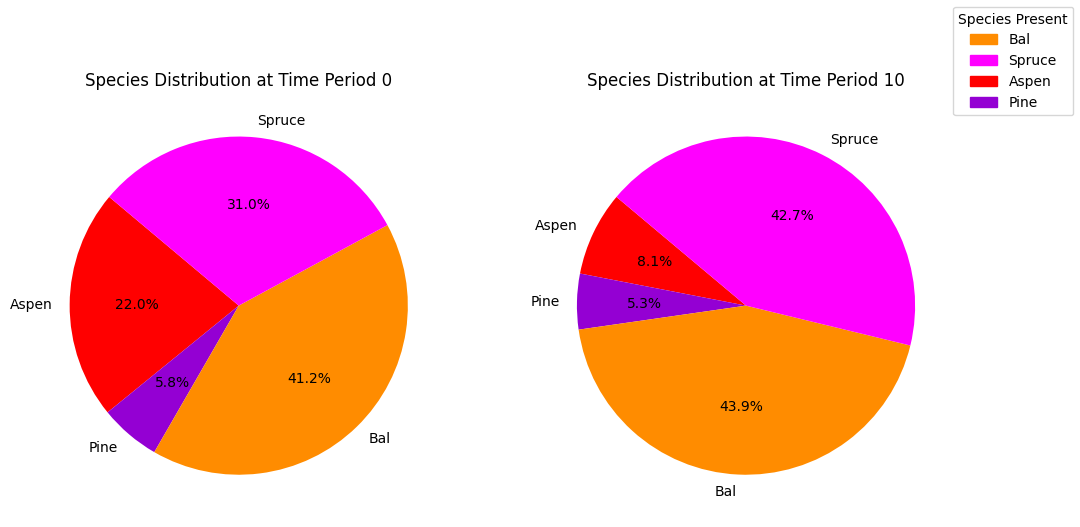

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_80%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

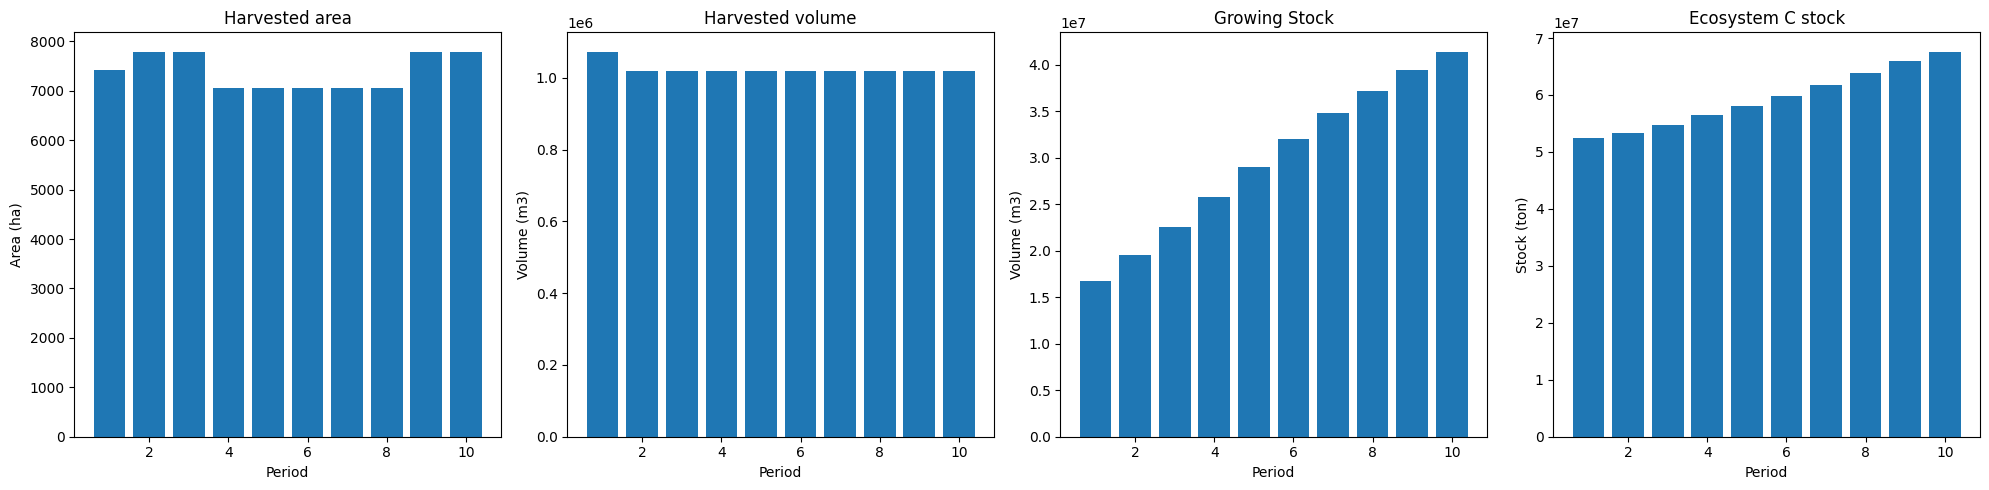

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


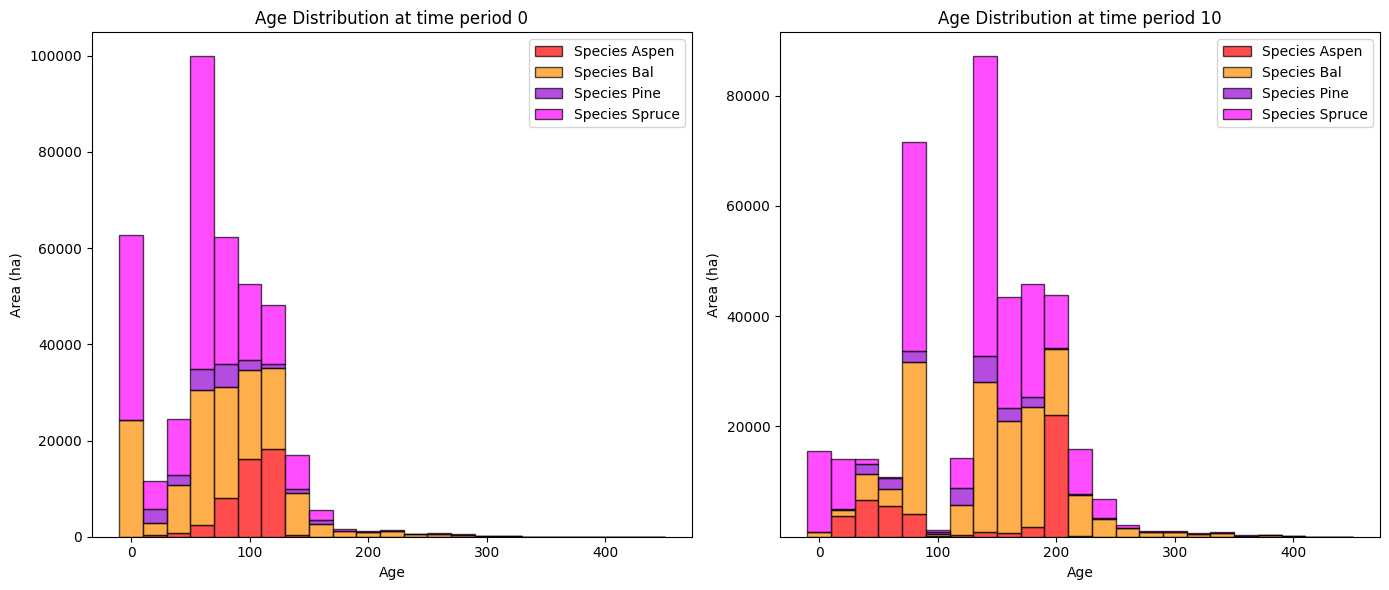

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


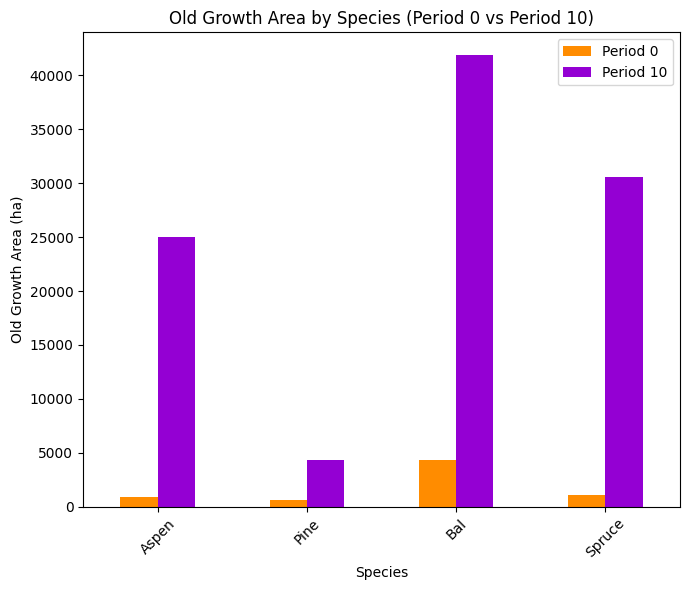

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


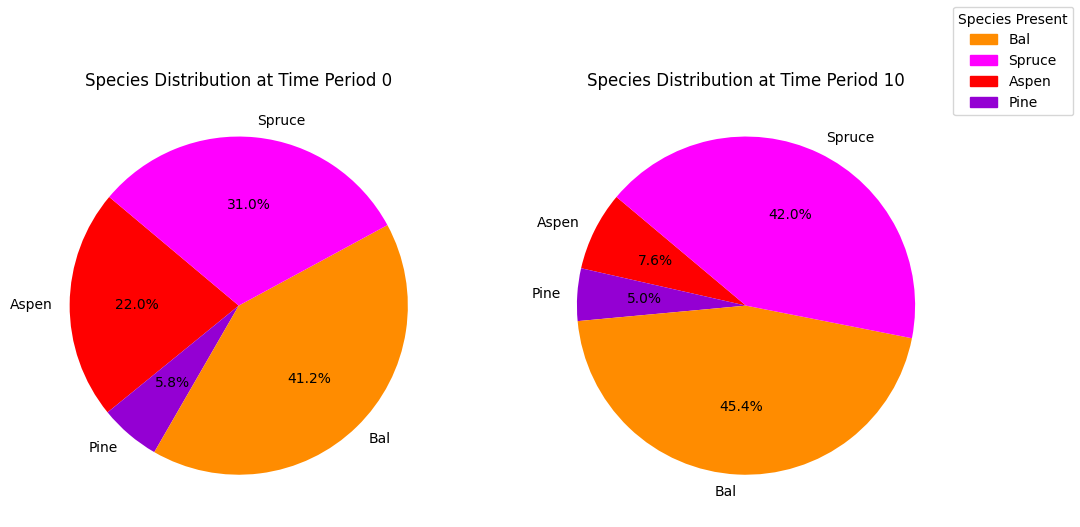

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


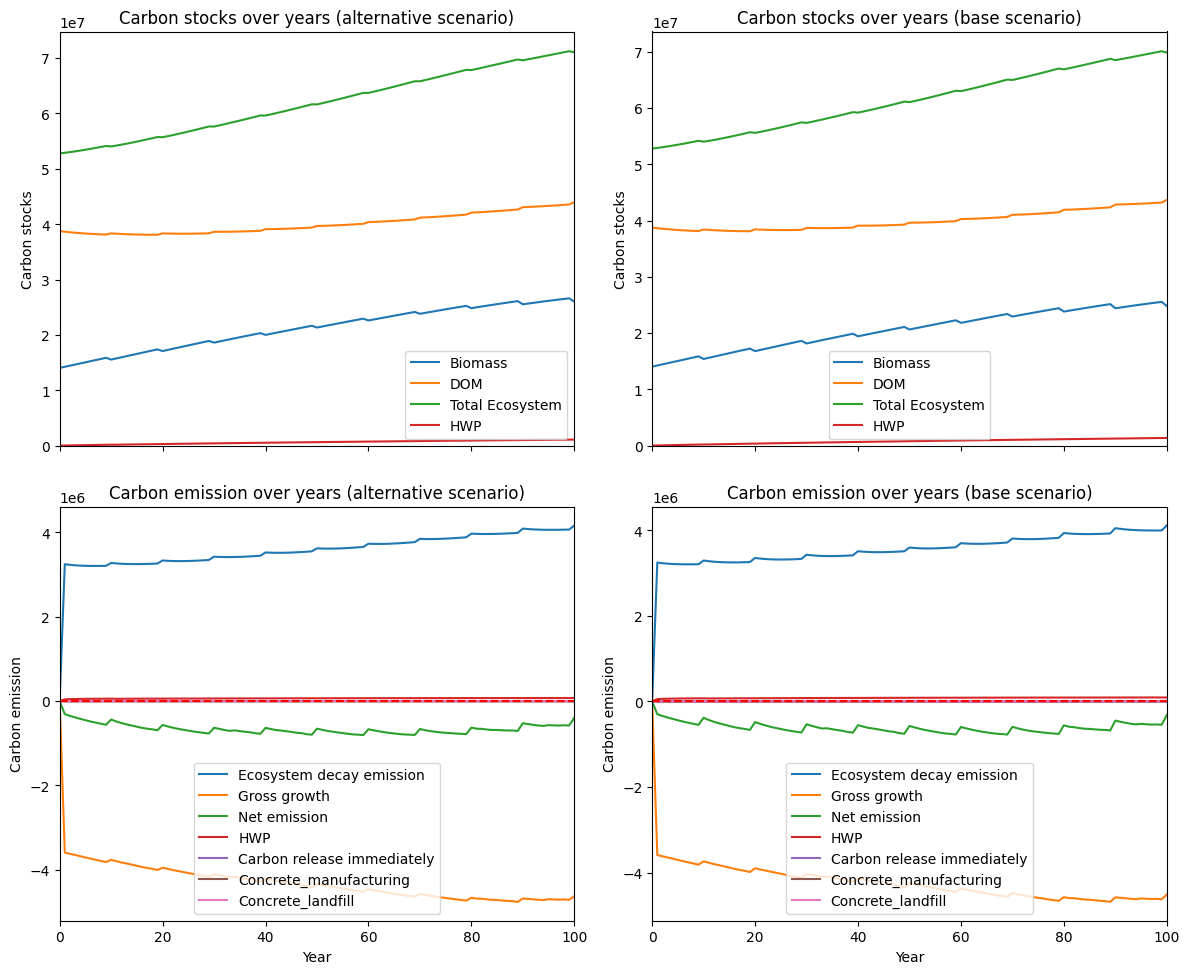

---------------------------------------------------------------------------------------
Net emission difference -4707294.931595268
Net emission base scenario -61347742.78335276
Net emission alternative scenario -66055037.71494803
dollar_per_ton is:  2.1243623238646476
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  5070.536173  5070.536173
Pine    0.0  1171.139441  1171.139441
Bal     0.0  2056.622799  2056.622799
Spruce  0.0  2104.978532  2104.978532

Overall, the old growth area has **increased** by 10403.28 hectares in the alternative scenario compared to the base scenario.


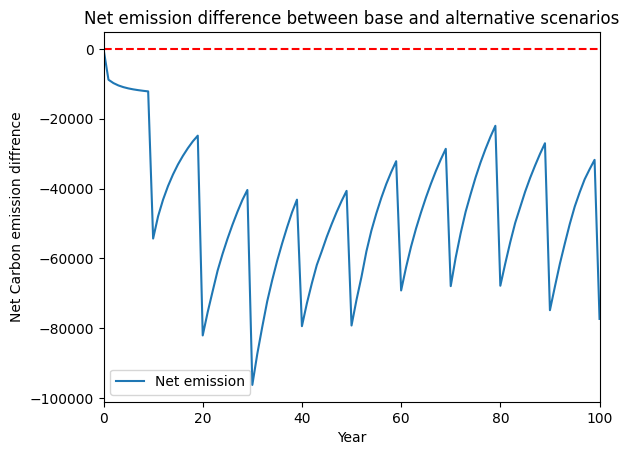

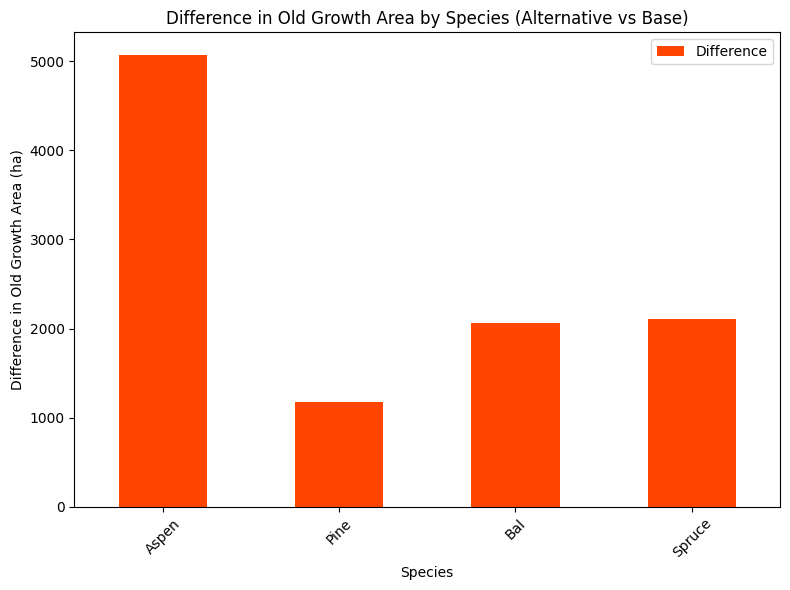

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


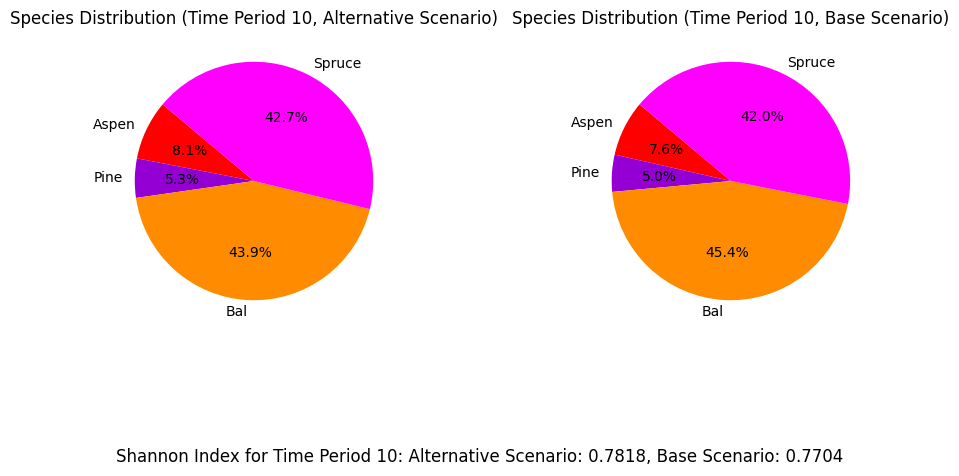

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_70%...
running the scenario for the Red Chris mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x7fe49758
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

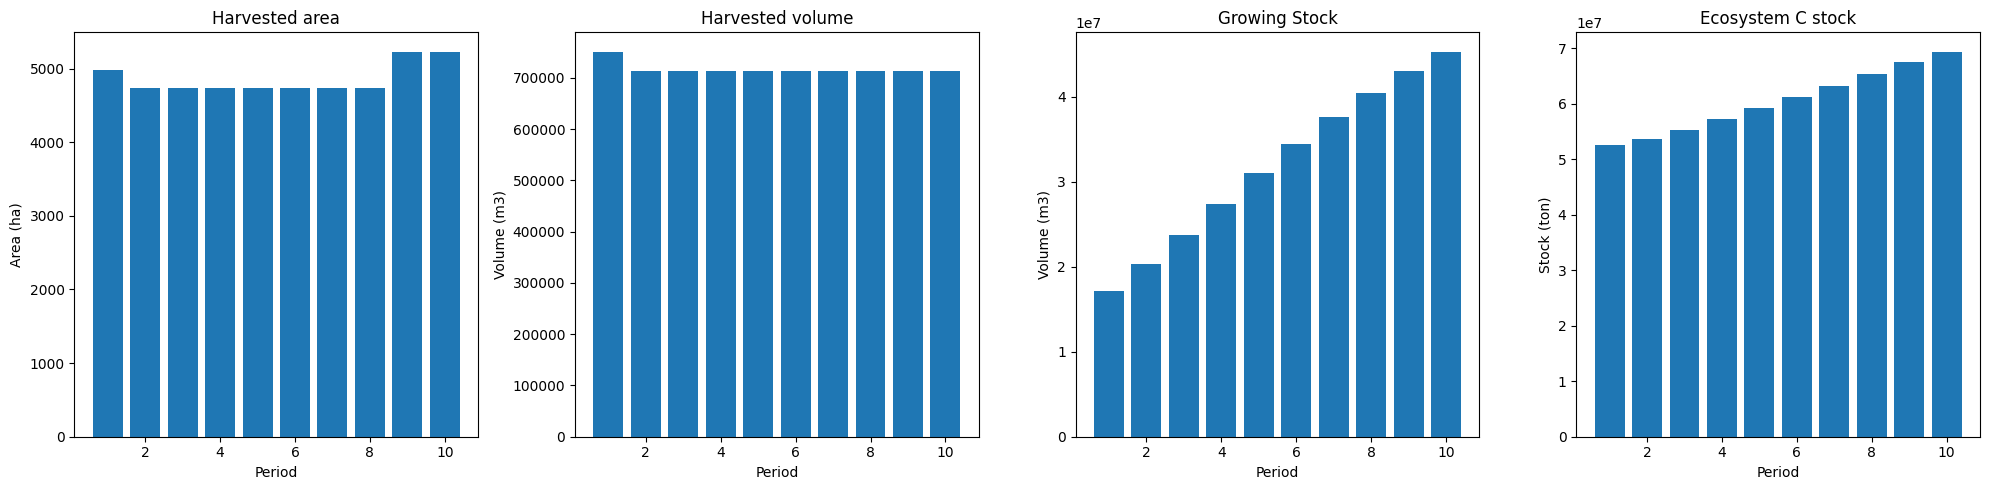

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_70%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7582
The economic indicator (the provincial government revenues) is:  258575
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


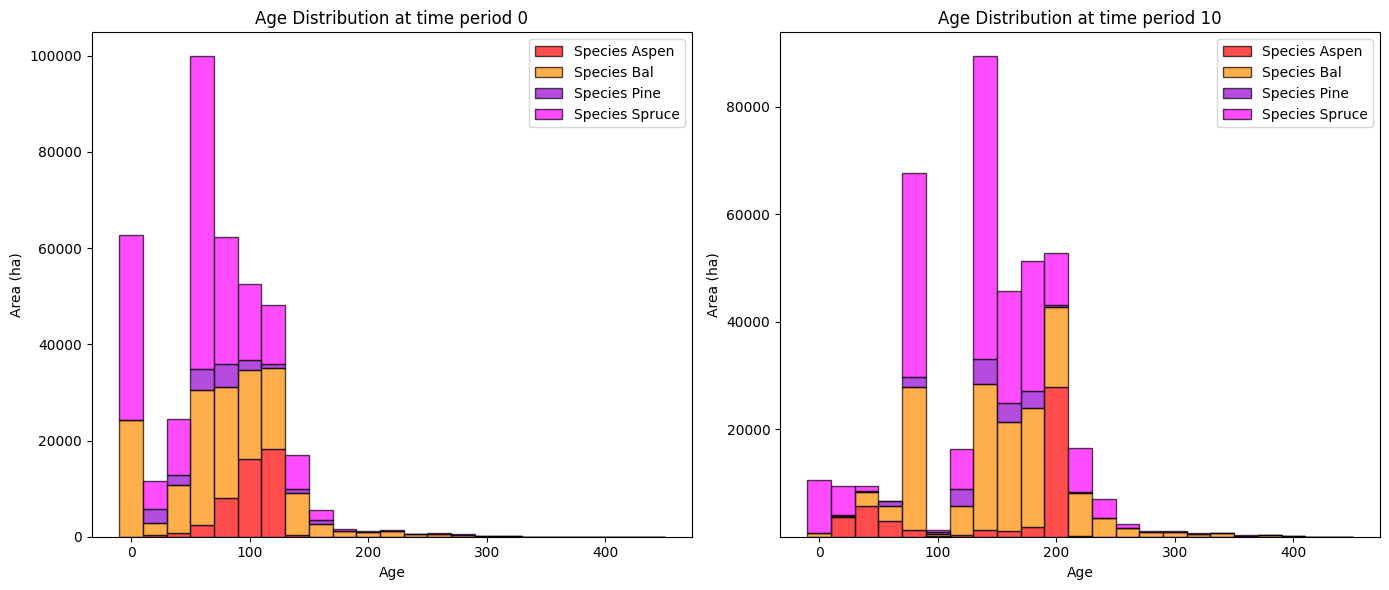

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  31308.181372  30362.867684
Pine     602.782616   6152.852487   5550.069871
Bal     4315.588546  45641.219075  41325.630529
Spruce  1072.814408  34020.126634  32947.312227

Old growth has **increased** by 110185.88 hectares from time period 0 to time period 10.


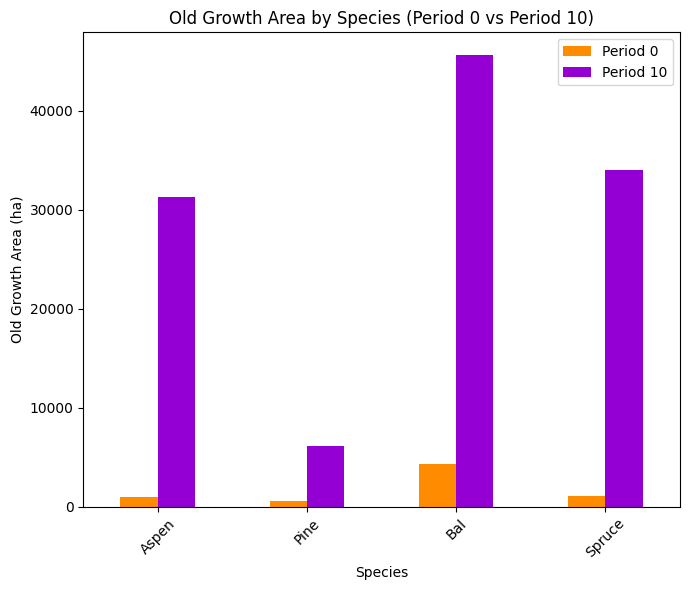

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7842

Diversity has **decreased** by 10.06% from time 0 to time 10.


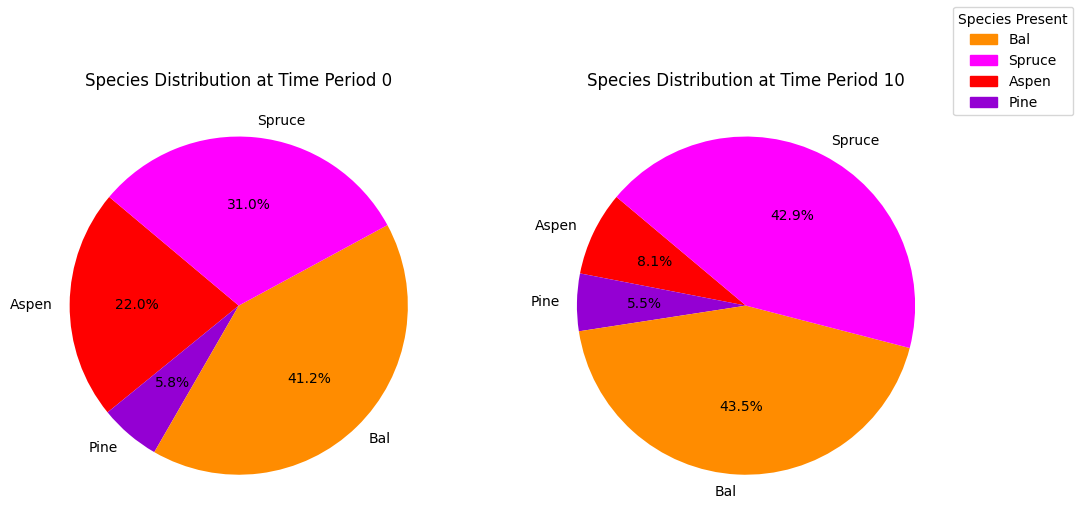

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_70%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

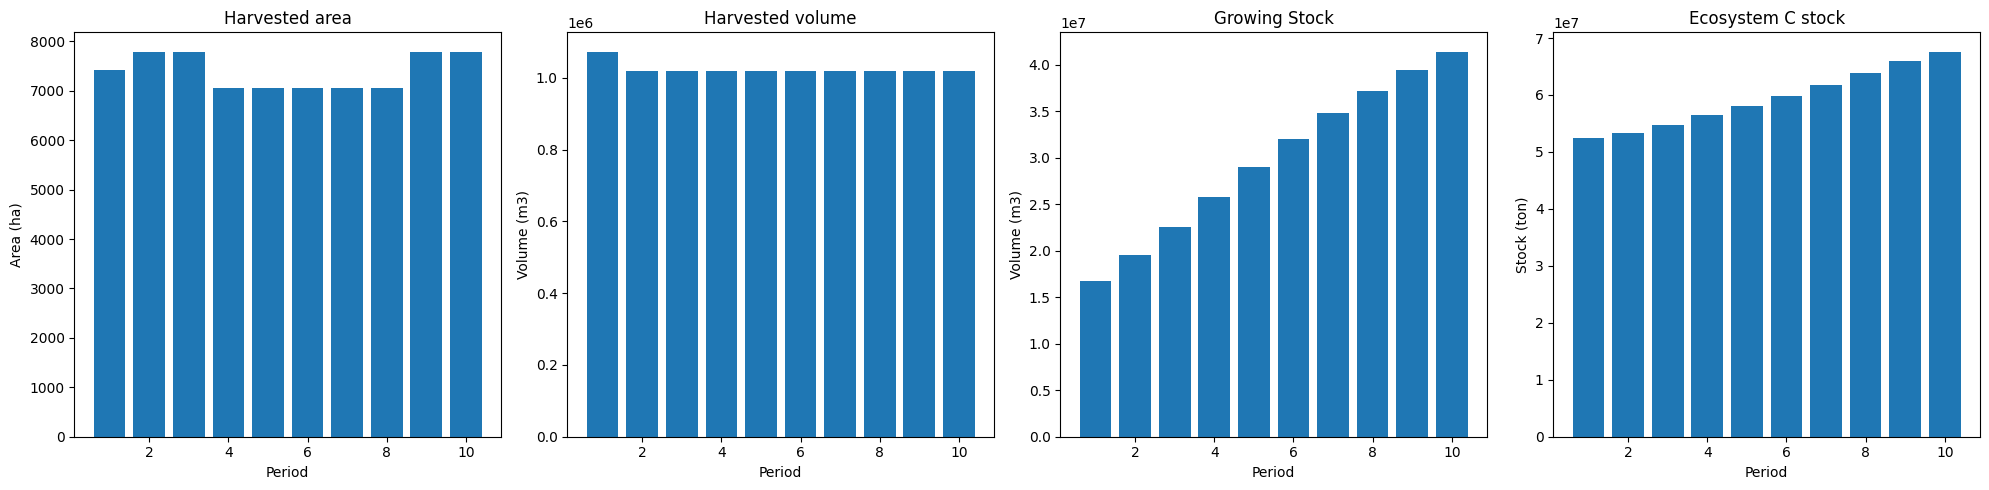

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


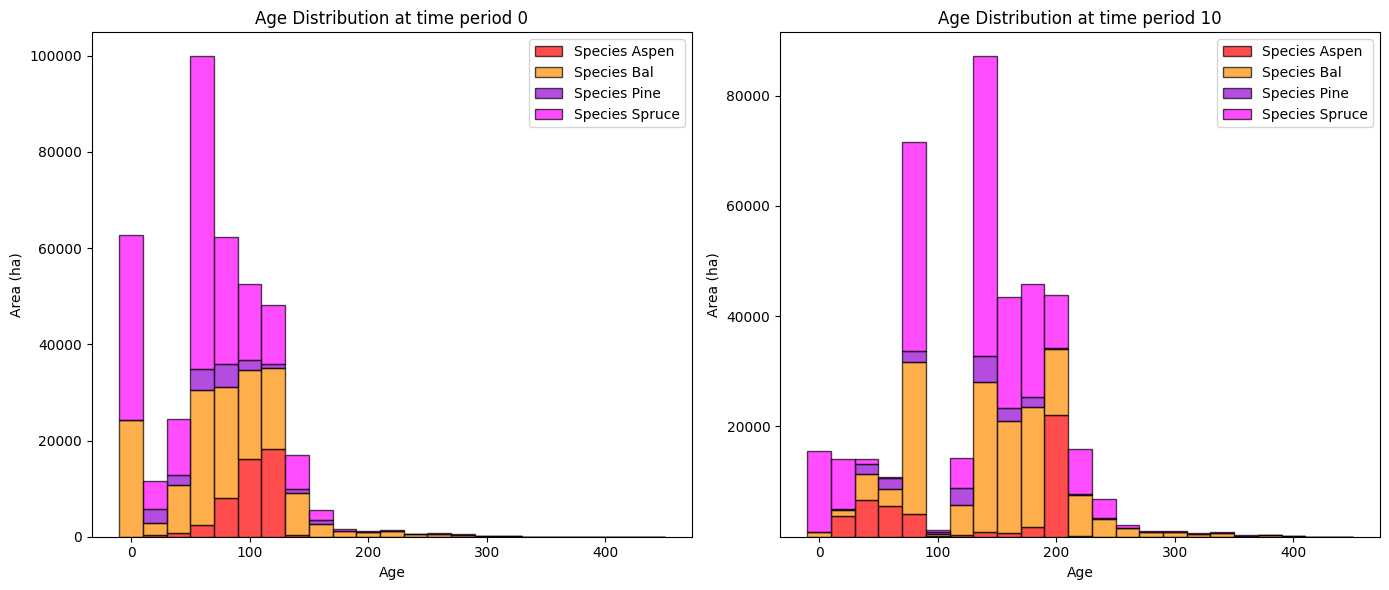

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


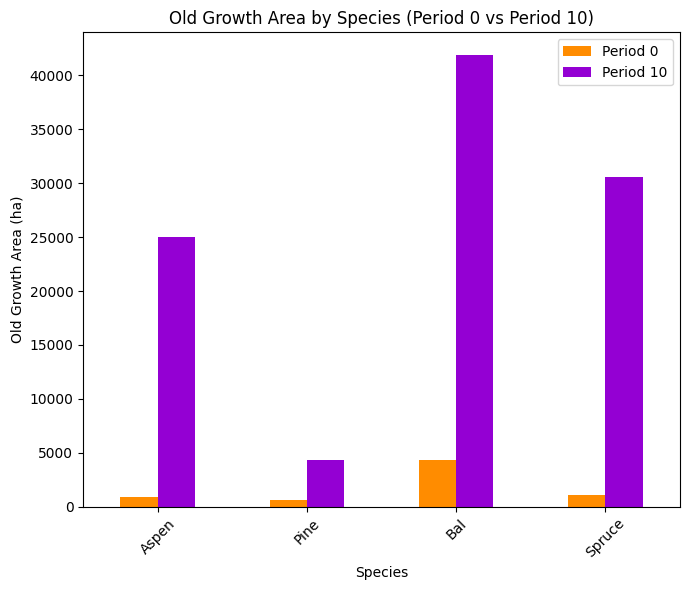

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


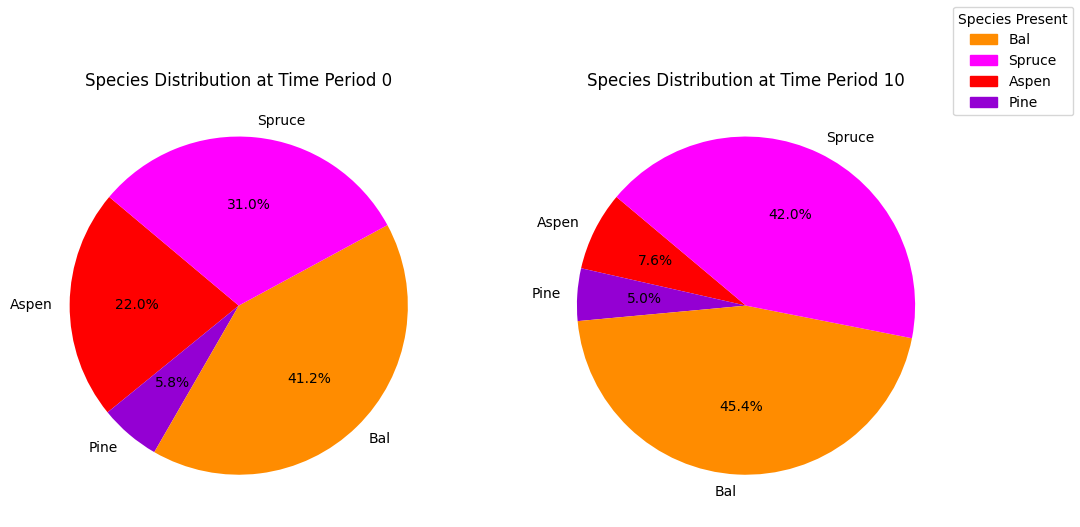

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


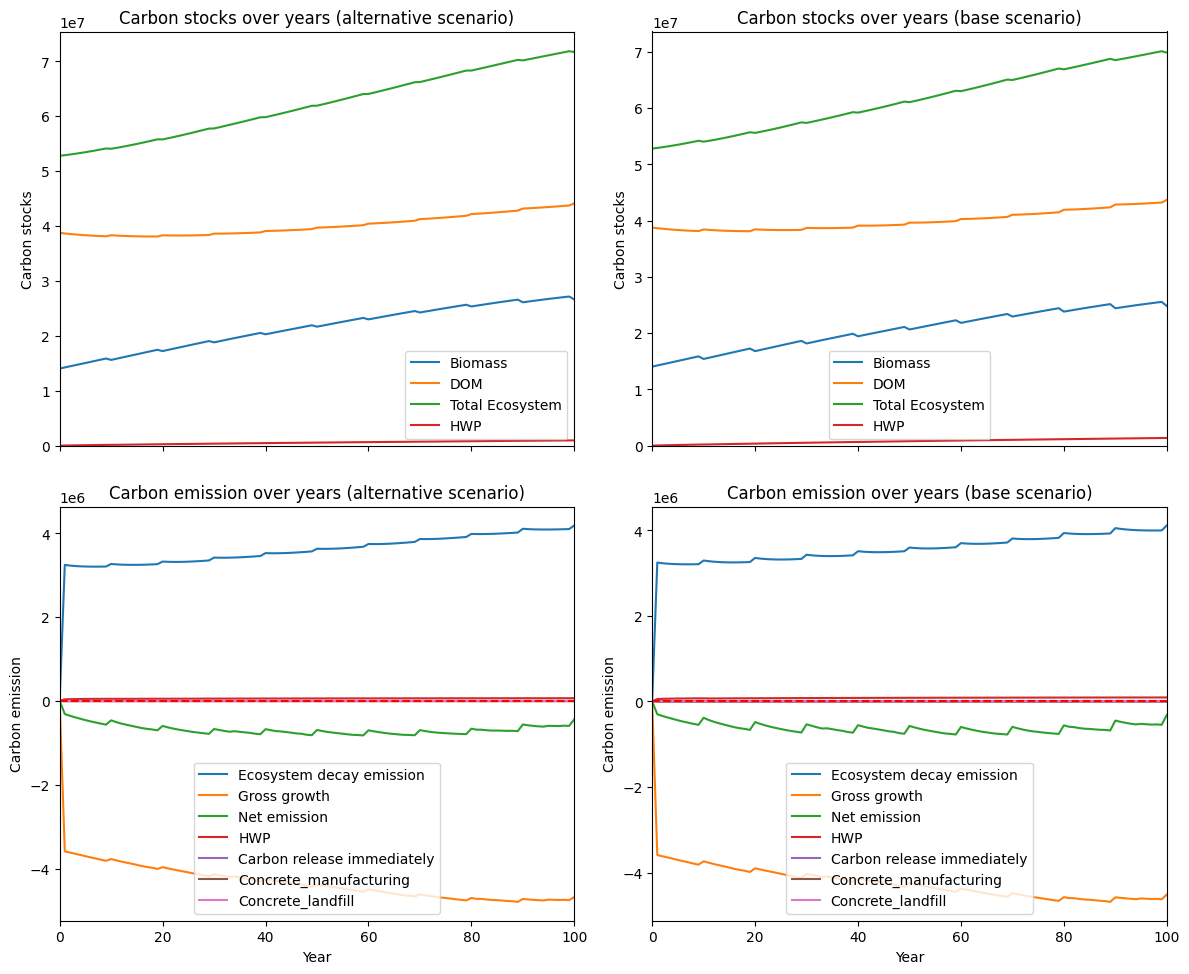

---------------------------------------------------------------------------------------
Net emission difference -7064093.485612304
Net emission base scenario -61347742.78335276
Net emission alternative scenario -68411836.26896507
dollar_per_ton is:  1.4156098047636776
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  6250.150727  6250.150727
Pine    0.0  1862.753918  1862.753918
Bal     0.0  3733.330249  3733.330249
Spruce  0.0  3403.259426  3403.259426

Overall, the old growth area has **increased** by 15249.49 hectares in the alternative scenario compared to the base scenario.


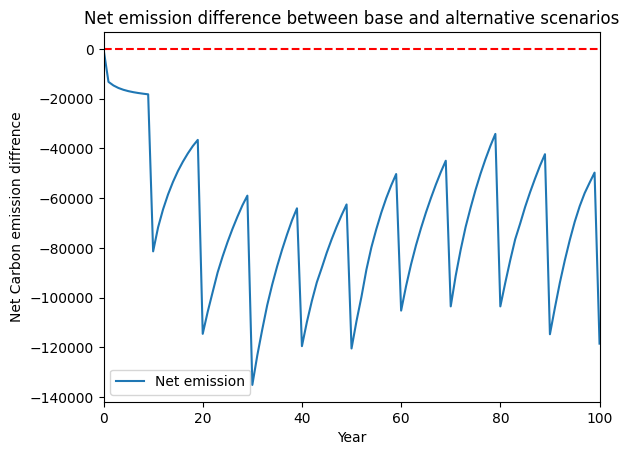

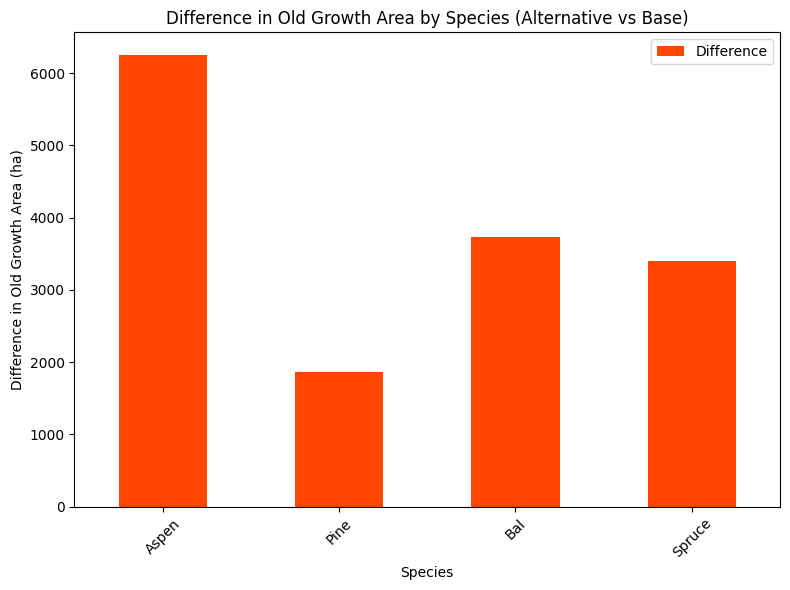

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


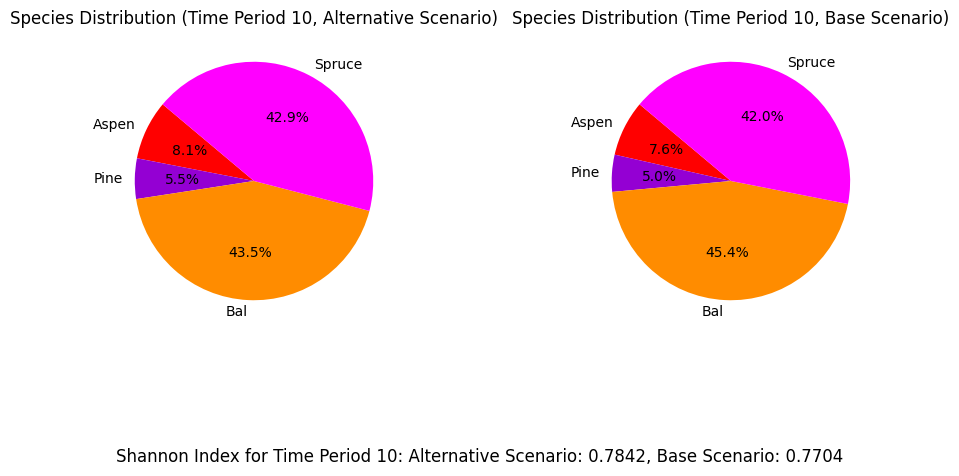

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_60%...
running the scenario for the Red Chris mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xa27214a0
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

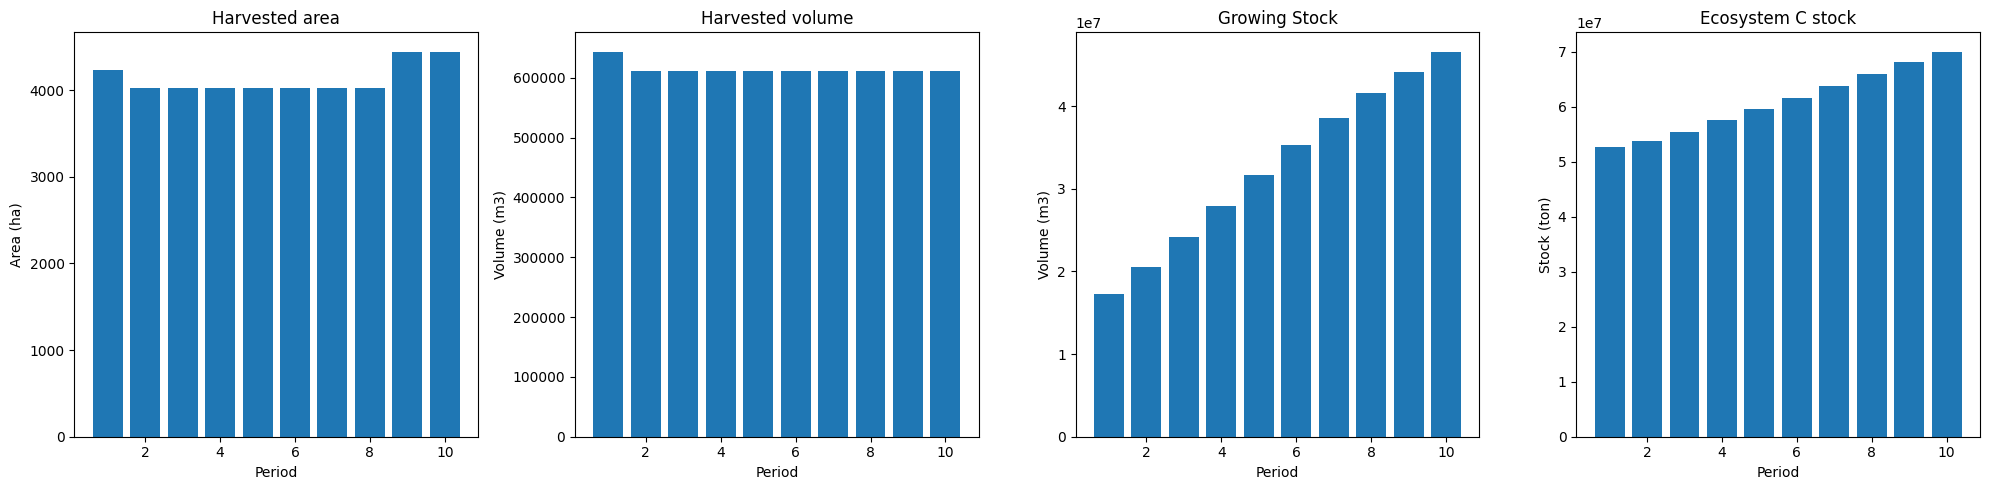

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_60%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6499
The economic indicator (the provincial government revenues) is:  221636
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


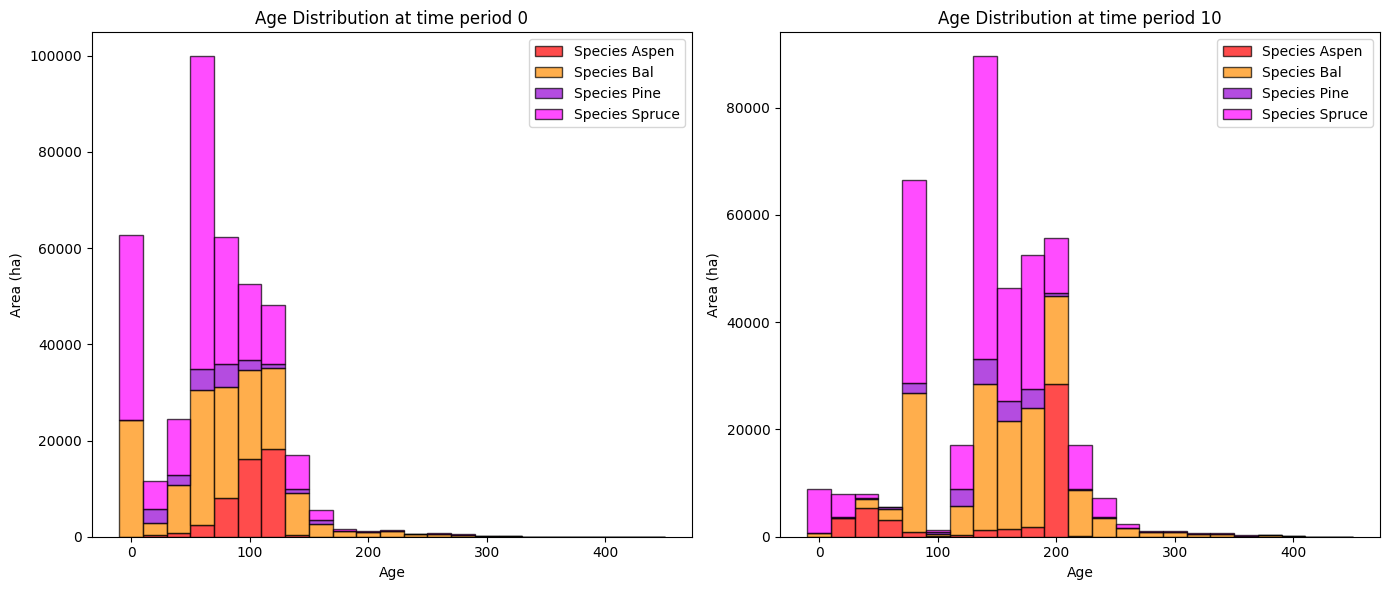

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  32068.215704  31122.902016
Pine     602.782616   6811.224192   6208.441575
Bal     4315.588546  48051.437944  43735.849397
Spruce  1072.814408  34952.166466  33879.352058

Old growth has **increased** by 114946.55 hectares from time period 0 to time period 10.


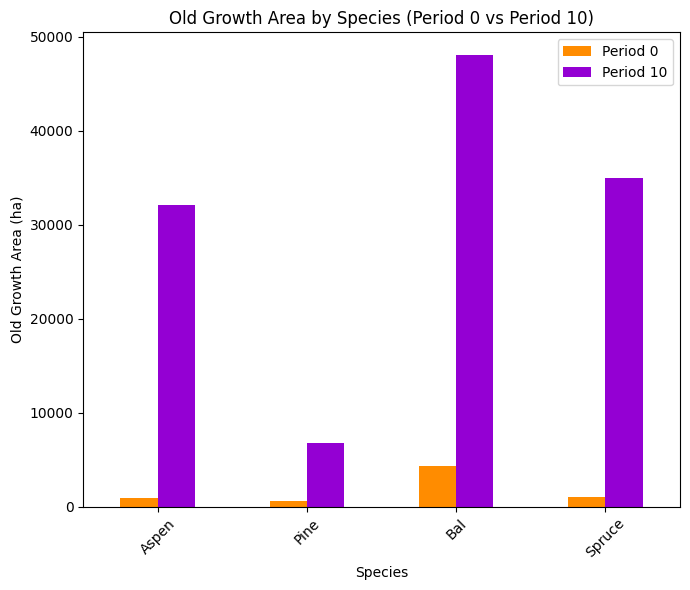

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7849

Diversity has **decreased** by 10.00% from time 0 to time 10.


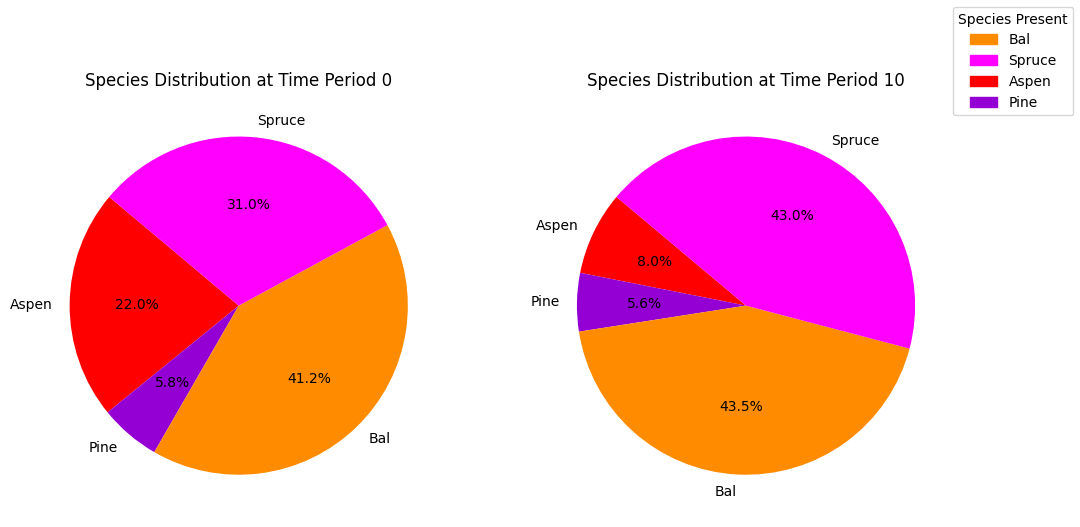

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_60%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

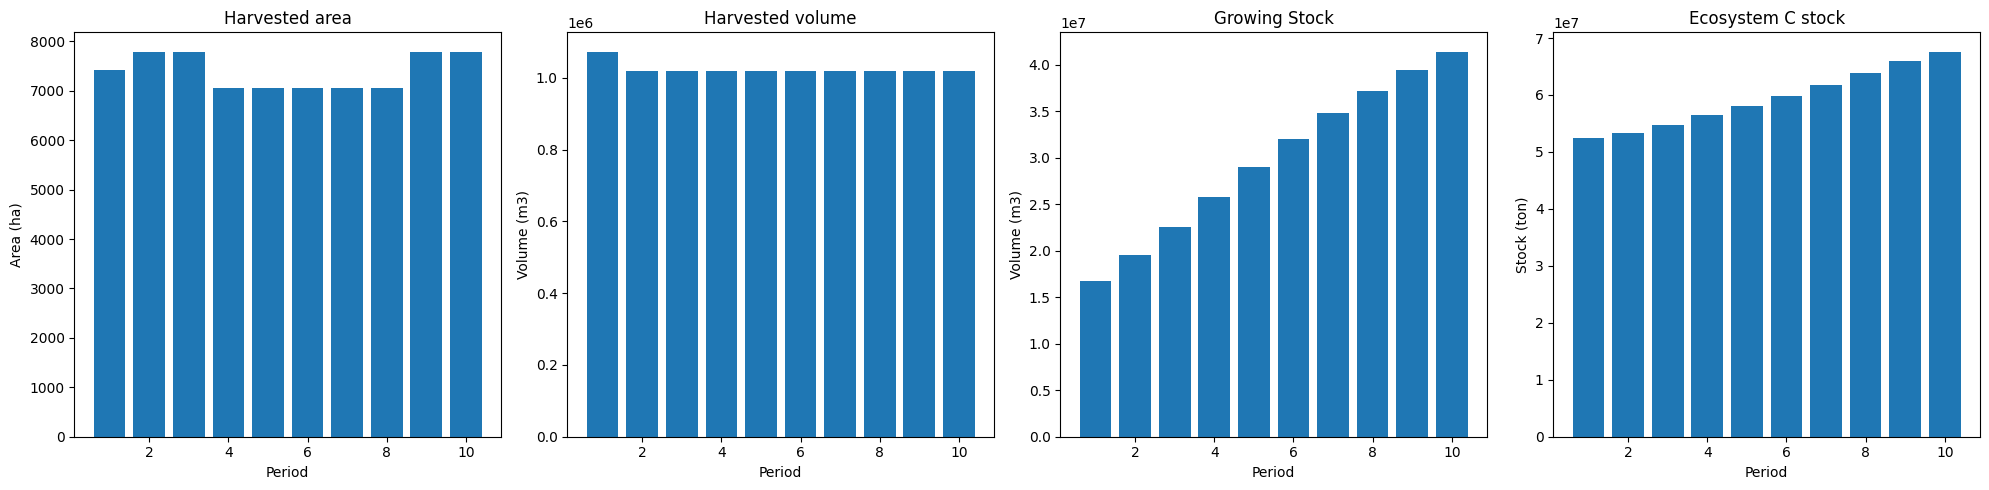

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


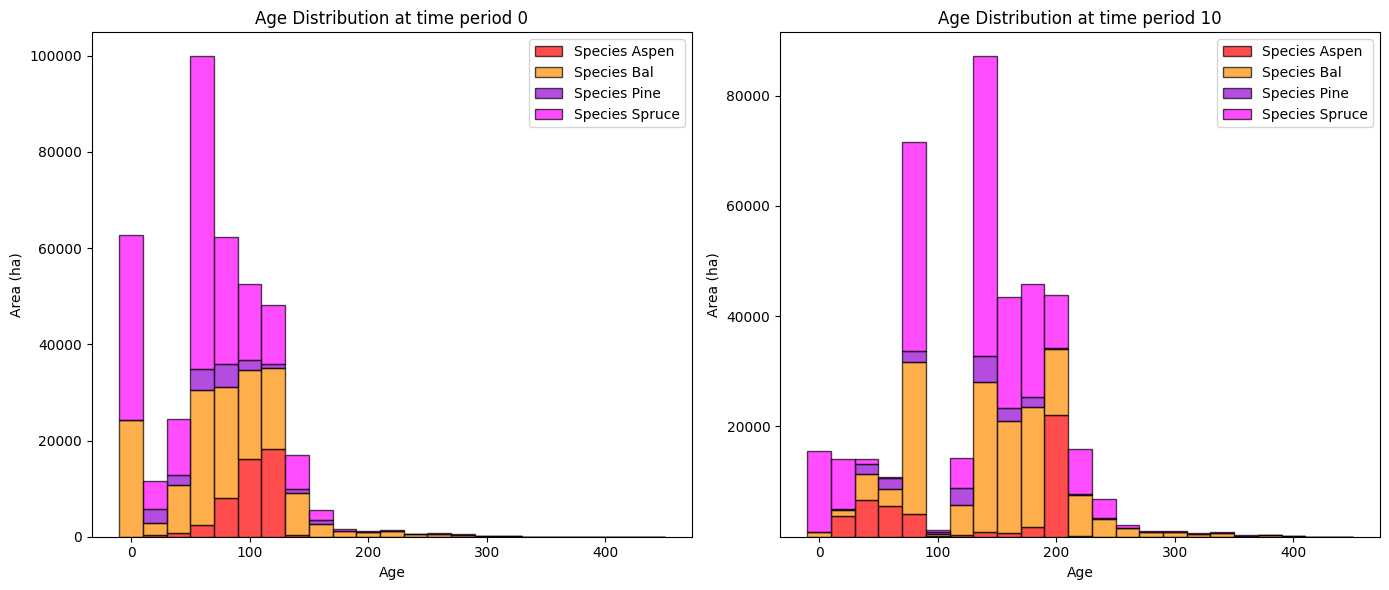

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


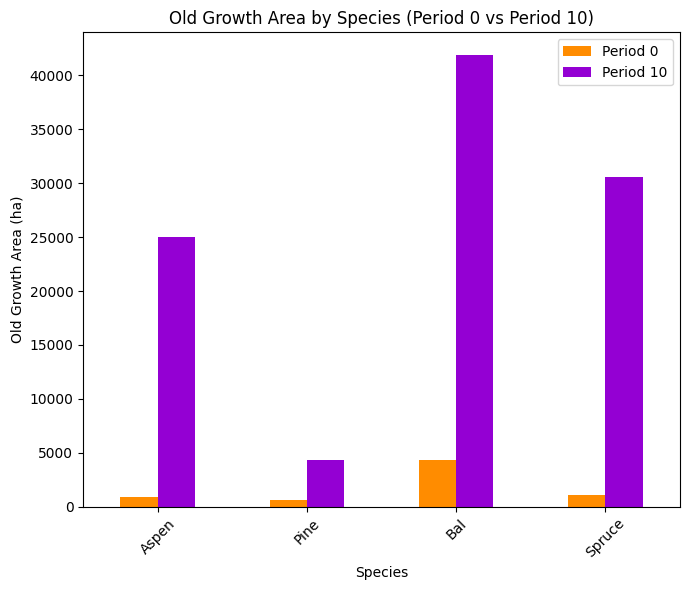

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


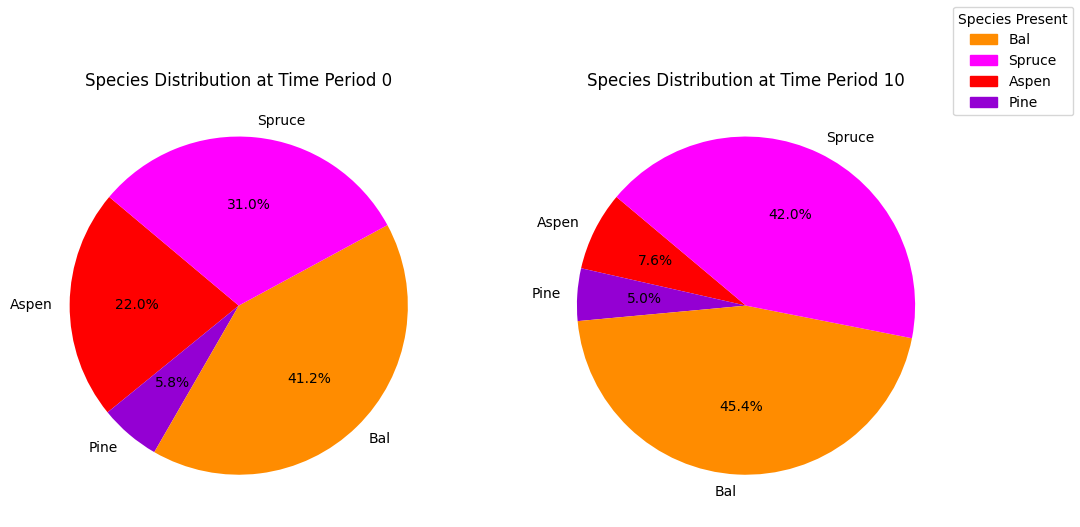

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


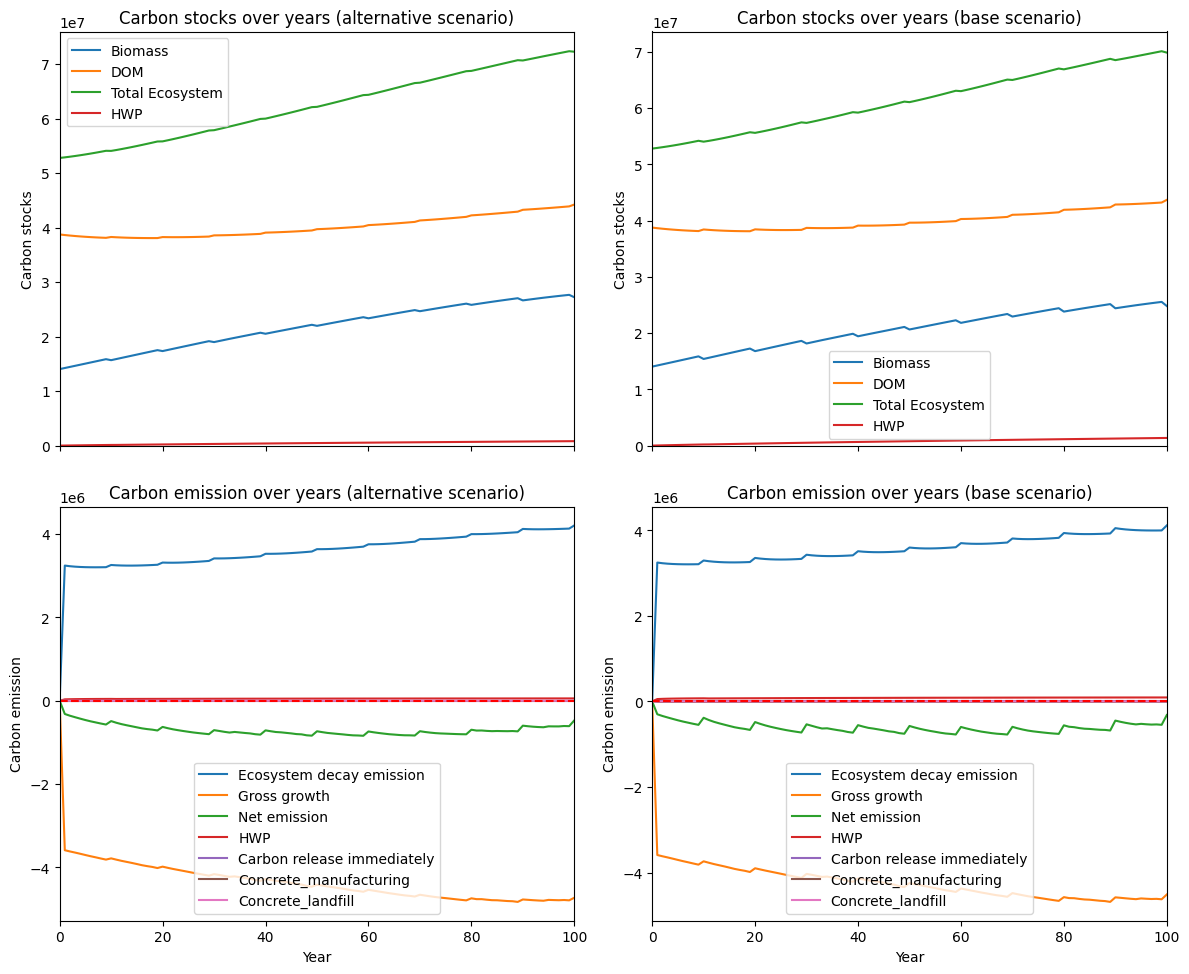

---------------------------------------------------------------------------------------
Net emission difference -9308572.070587797
Net emission base scenario -61347742.78335276
Net emission alternative scenario -70656314.85394056
dollar_per_ton is:  1.0742786244946096
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  7010.185059  7010.185059
Pine    0.0  2521.125622  2521.125622
Bal     0.0  6143.549117  6143.549117
Spruce  0.0  4335.299258  4335.299258

Overall, the old growth area has **increased** by 20010.16 hectares in the alternative scenario compared to the base scenario.


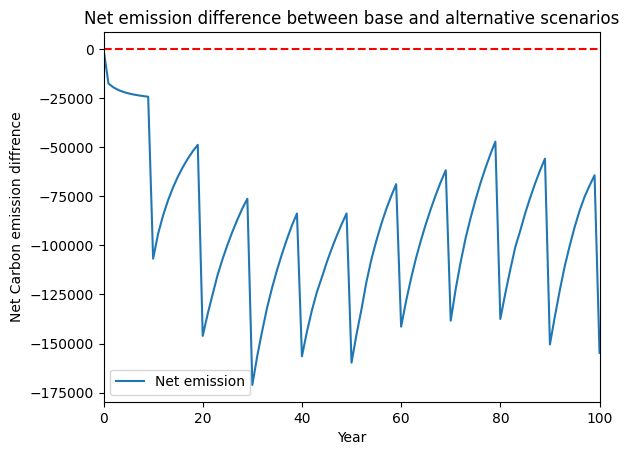

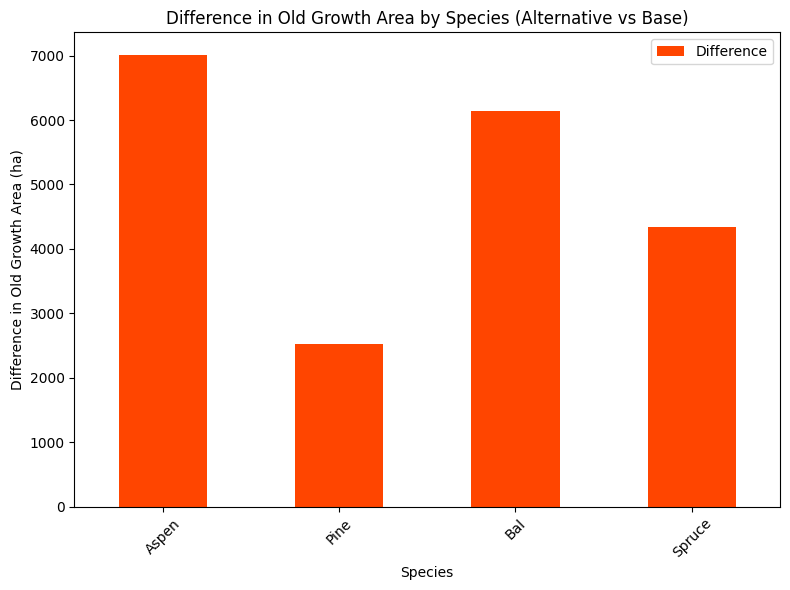

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


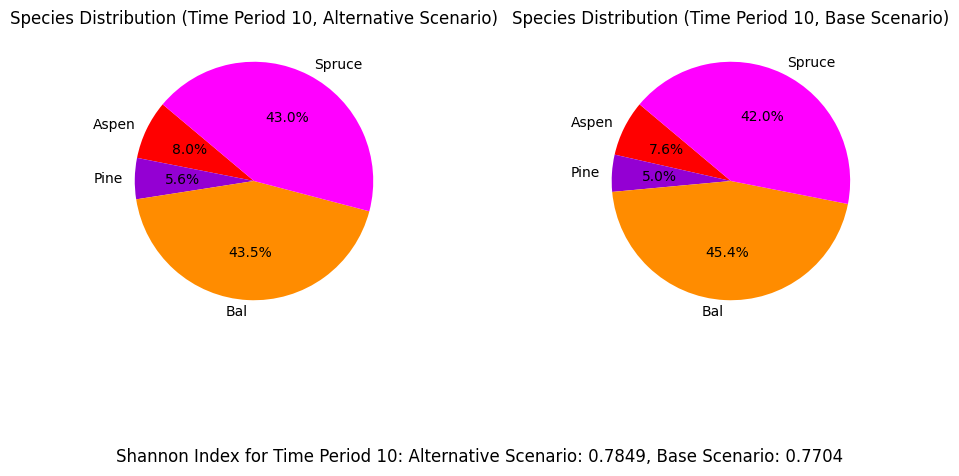

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_50%...
running the scenario for the Red Chris mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x6c67693a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

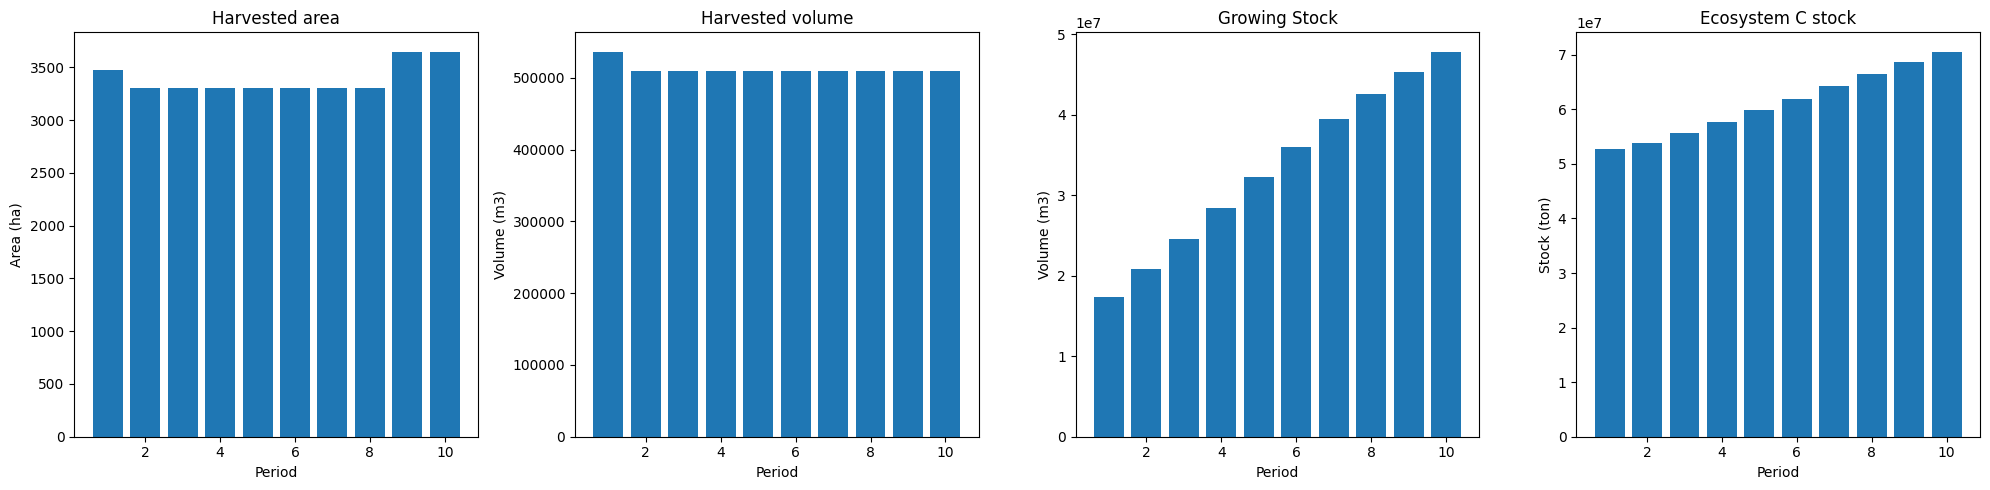

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_50%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5415
The economic indicator (the provincial government revenues) is:  184696
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


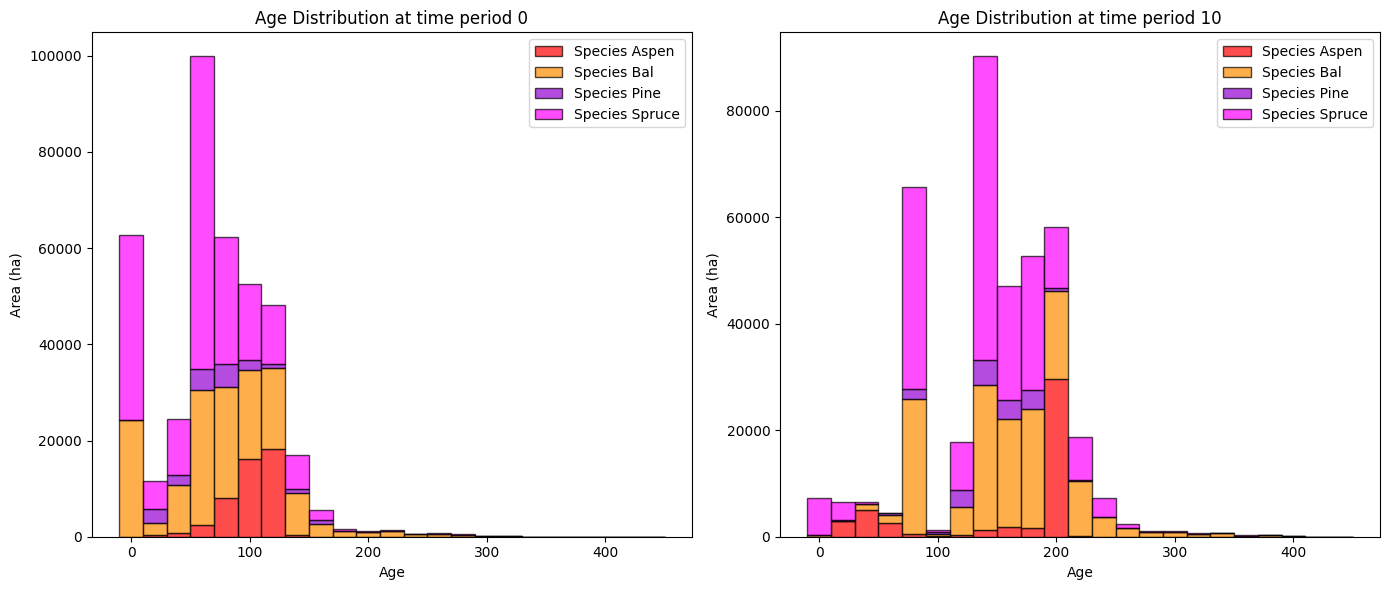

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  33729.647242  32784.333554
Pine     602.782616   6877.395241   6274.612625
Bal     4315.588546  49999.617690  45684.029143
Spruce  1072.814408  36120.909430  35048.095023

Old growth has **increased** by 119791.07 hectares from time period 0 to time period 10.


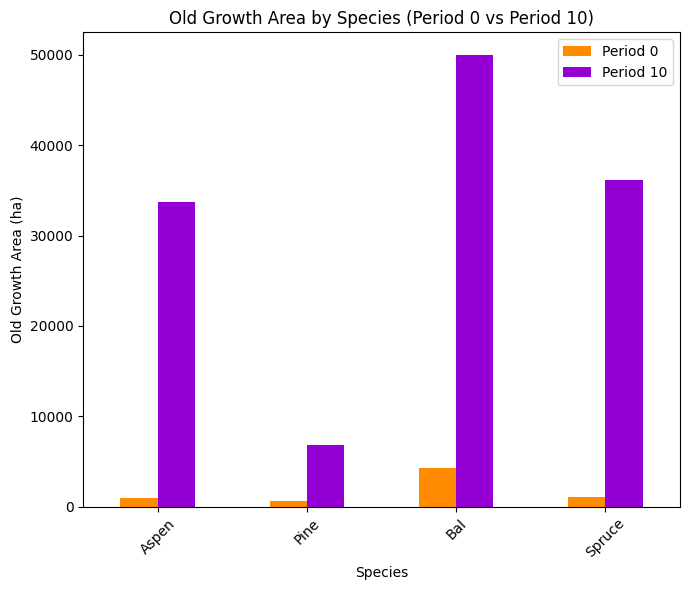

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7853

Diversity has **decreased** by 9.96% from time 0 to time 10.


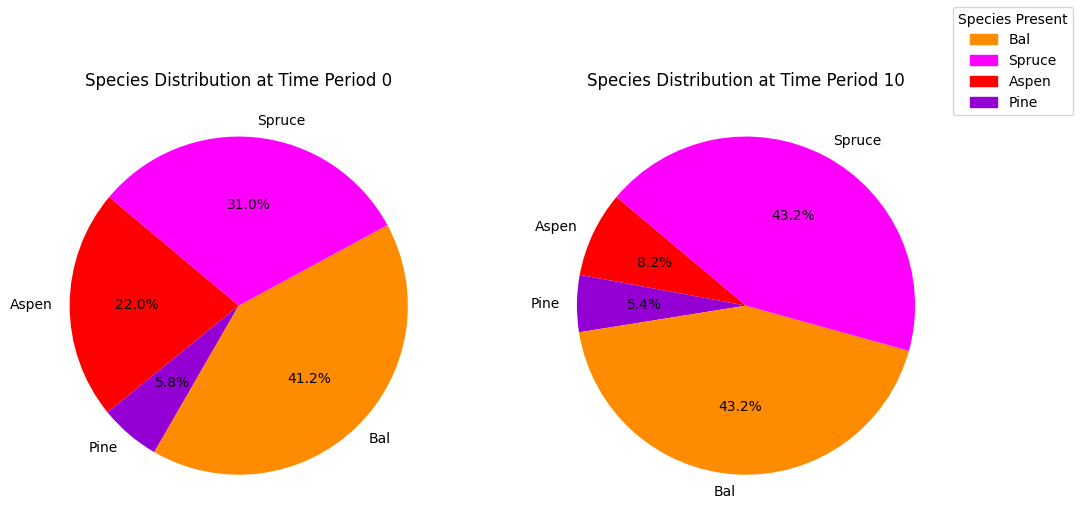

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_50%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

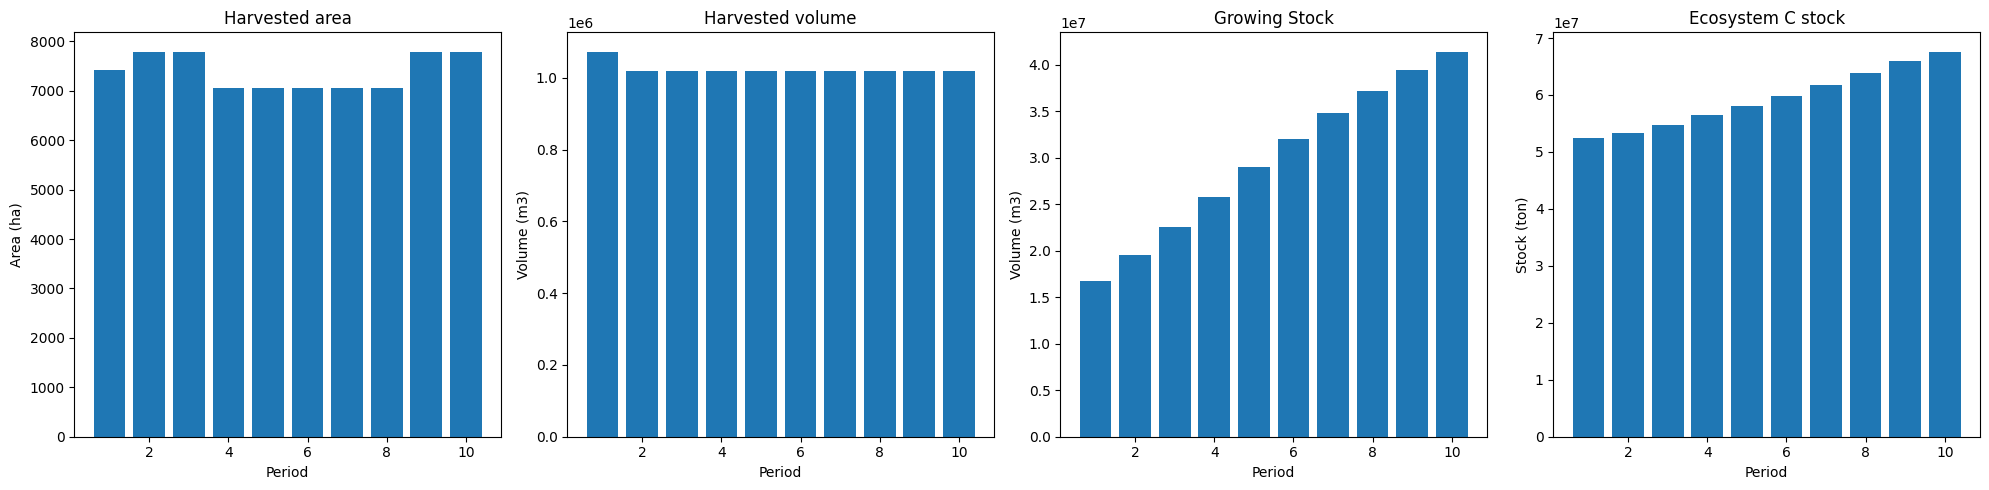

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


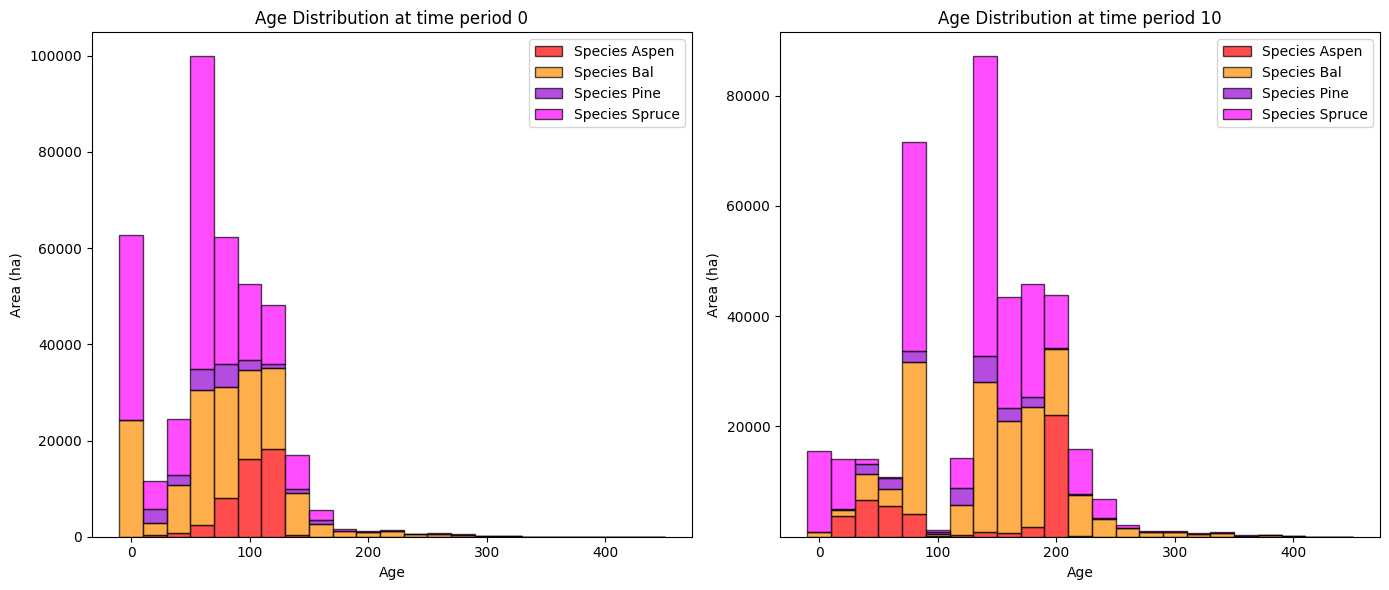

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


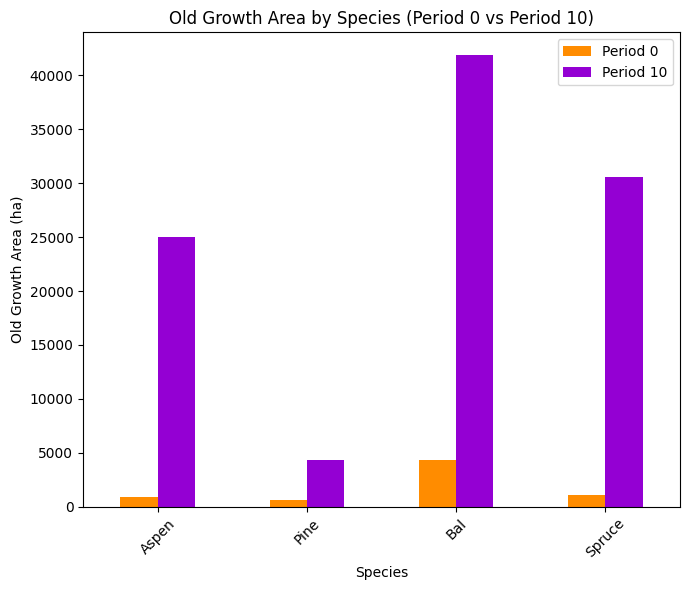

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


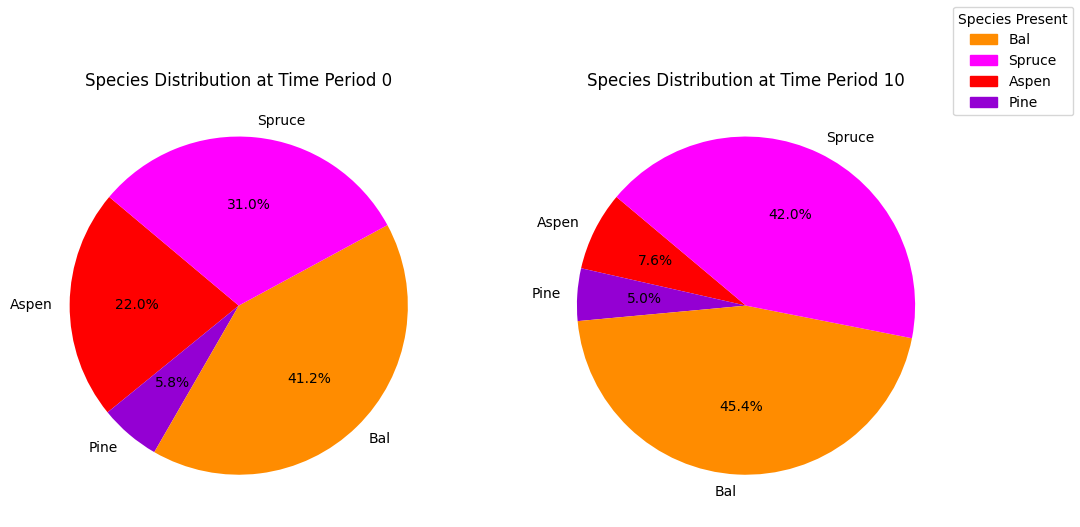

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


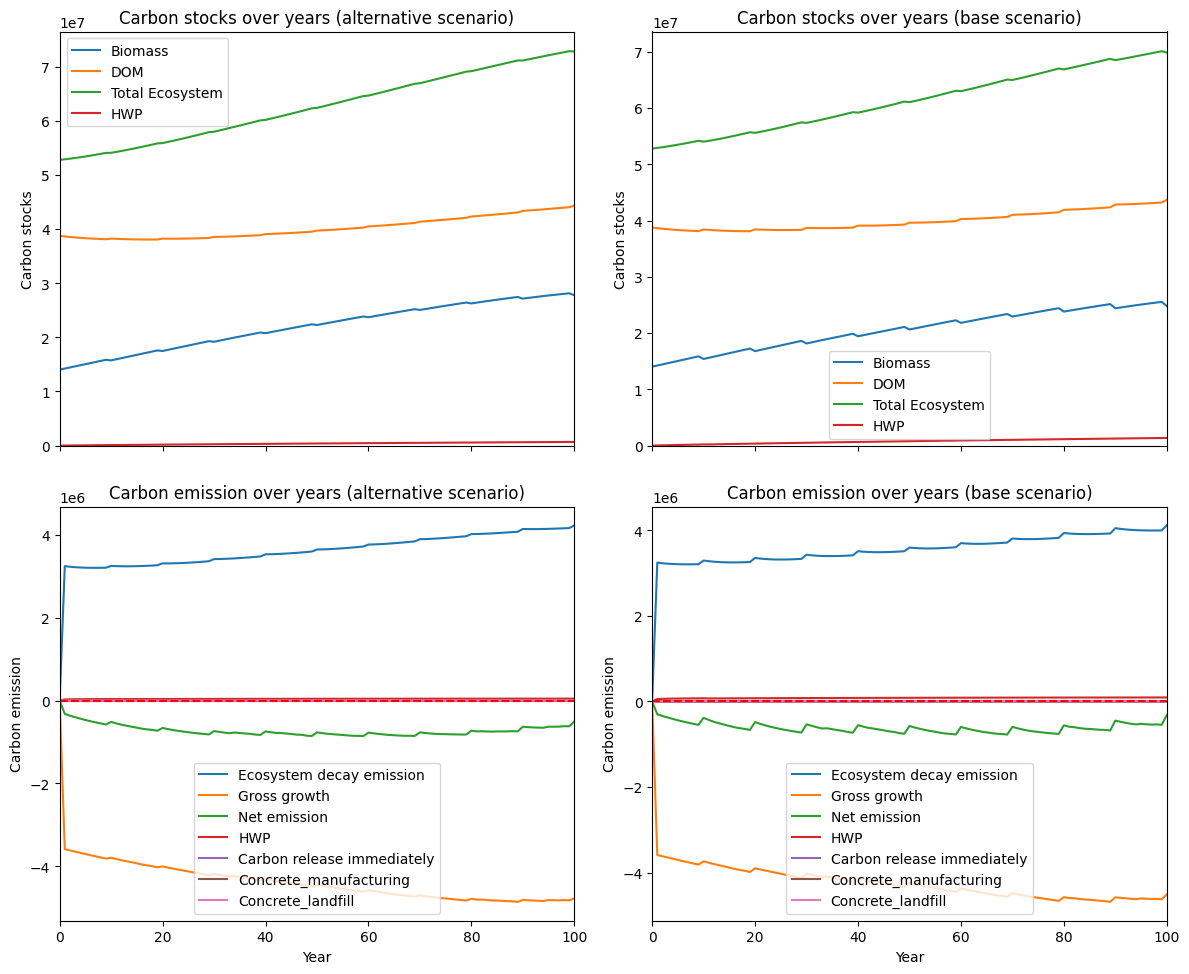

---------------------------------------------------------------------------------------
Net emission difference -11406121.02165845
Net emission base scenario -61347742.78335276
Net emission alternative scenario -72753863.8050112
dollar_per_ton is:  0.8767222424706484
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  8671.616596  8671.616596
Pine    0.0  2587.296672  2587.296672
Bal     0.0  8091.728863  8091.728863
Spruce  0.0  5504.042222  5504.042222

Overall, the old growth area has **increased** by 24854.68 hectares in the alternative scenario compared to the base scenario.


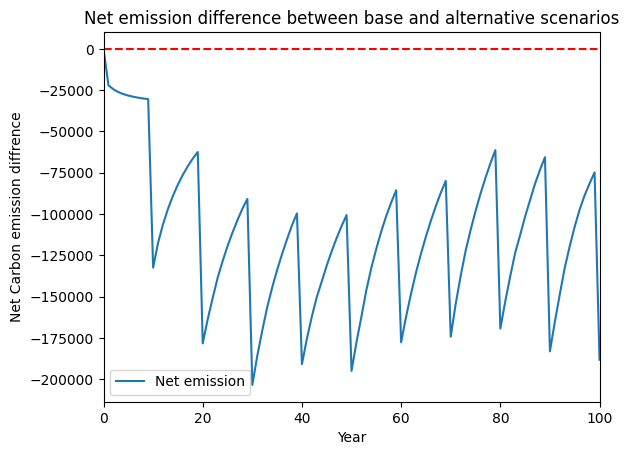

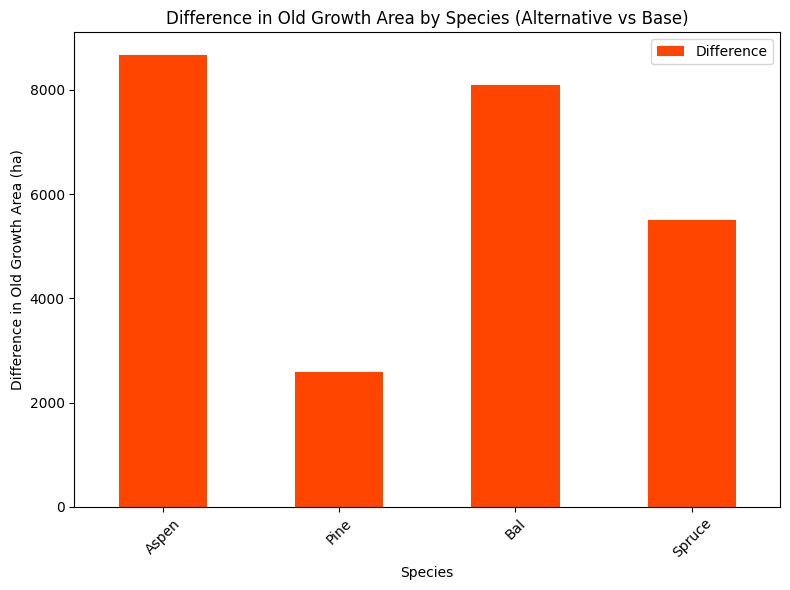

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


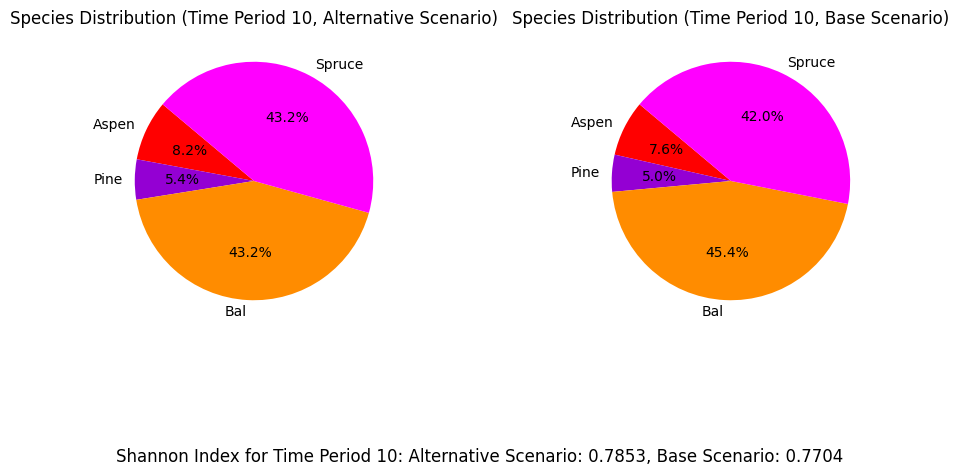

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_40%...
running the scenario for the Red Chris mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x23a5fc87
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32529 column

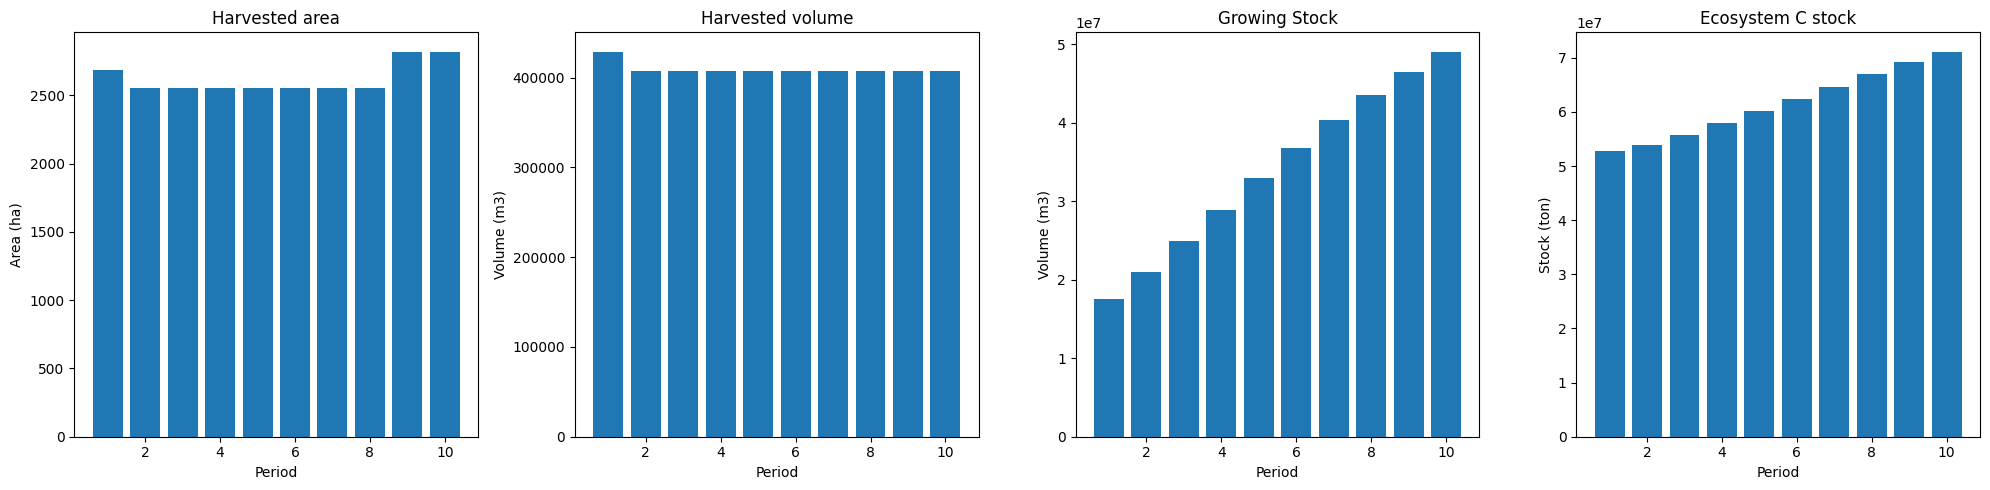

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_40%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4332
The economic indicator (the provincial government revenues) is:  147757
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


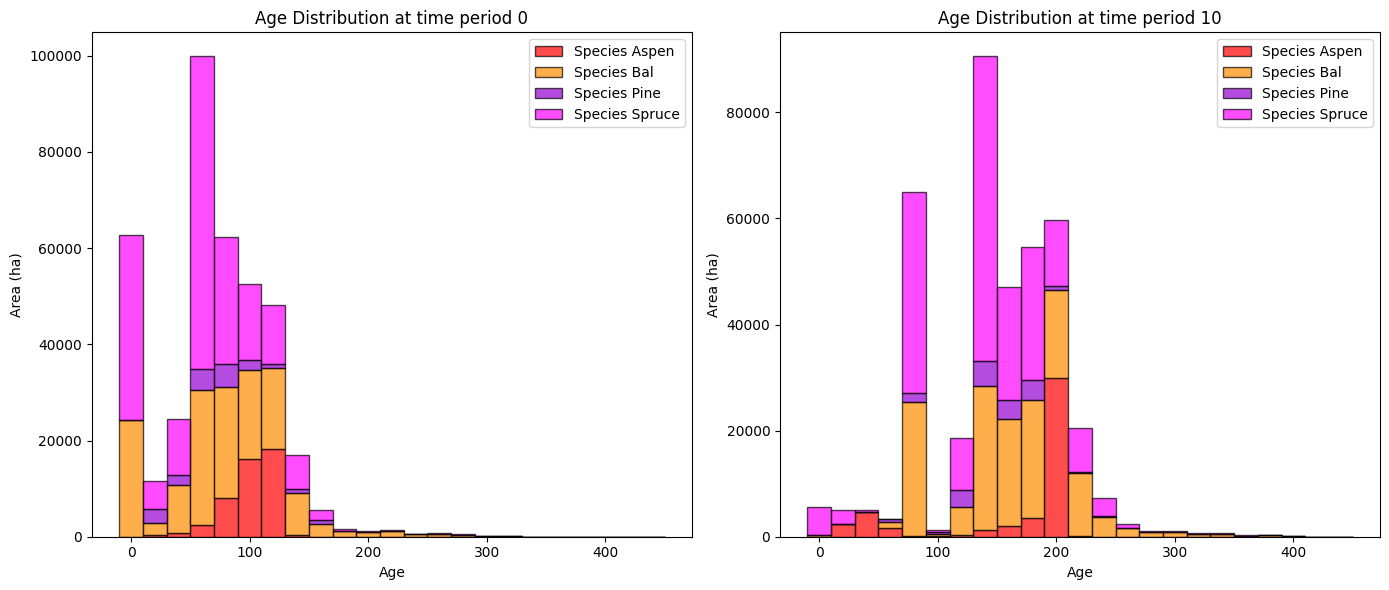

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  35913.234105  34967.920418
Pine     602.782616   7164.001102   6561.218486
Bal     4315.588546  51816.612648  47501.024102
Spruce  1072.814408  37178.675660  36105.861252

Old growth has **increased** by 125136.02 hectares from time period 0 to time period 10.


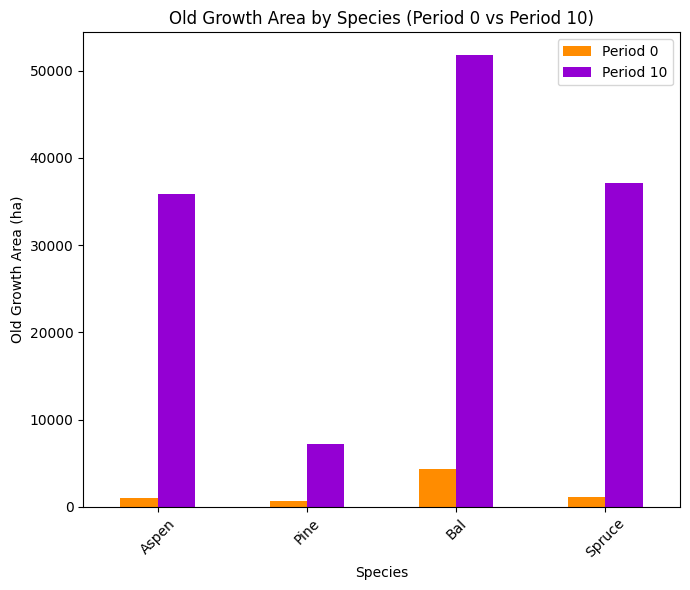

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7894

Diversity has **decreased** by 9.54% from time 0 to time 10.


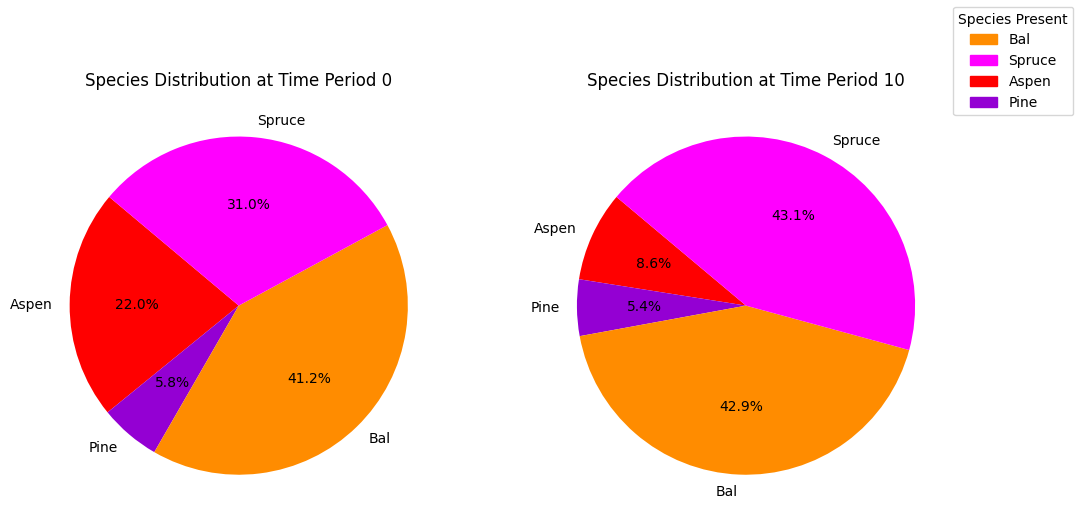

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_40%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

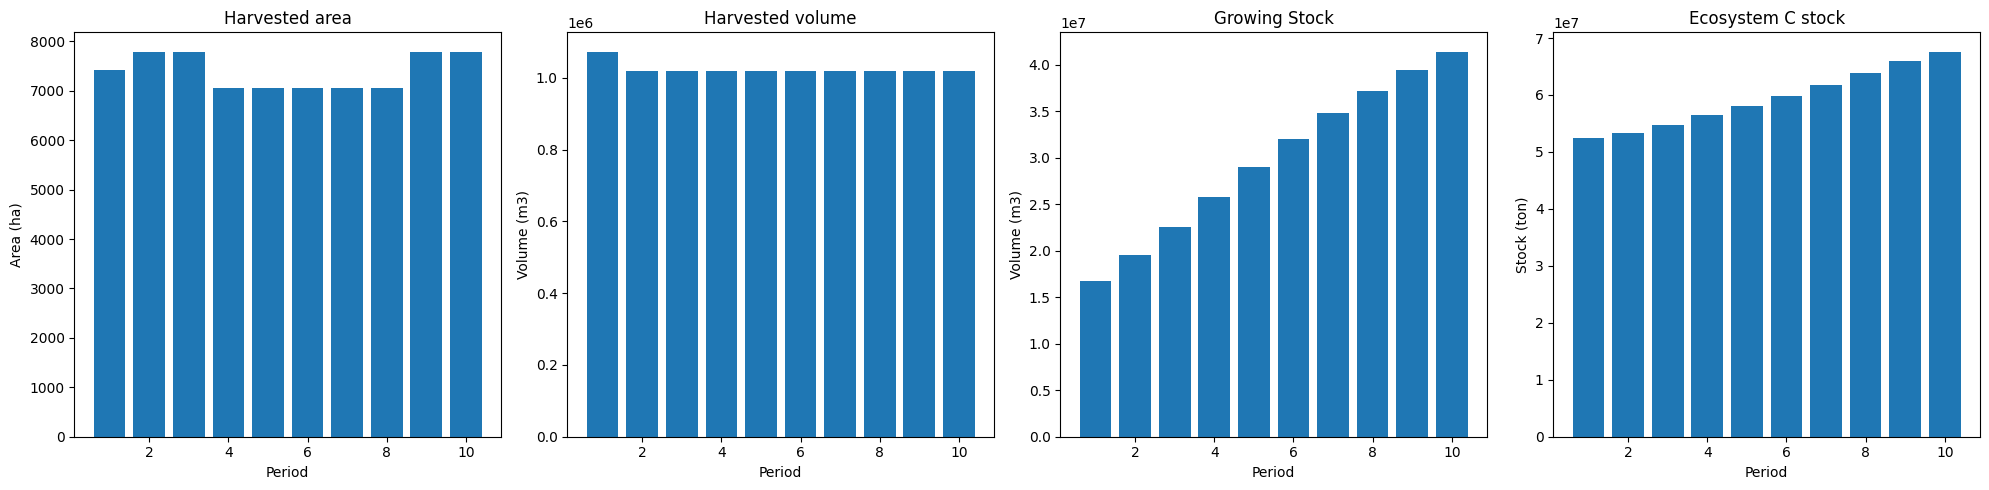

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


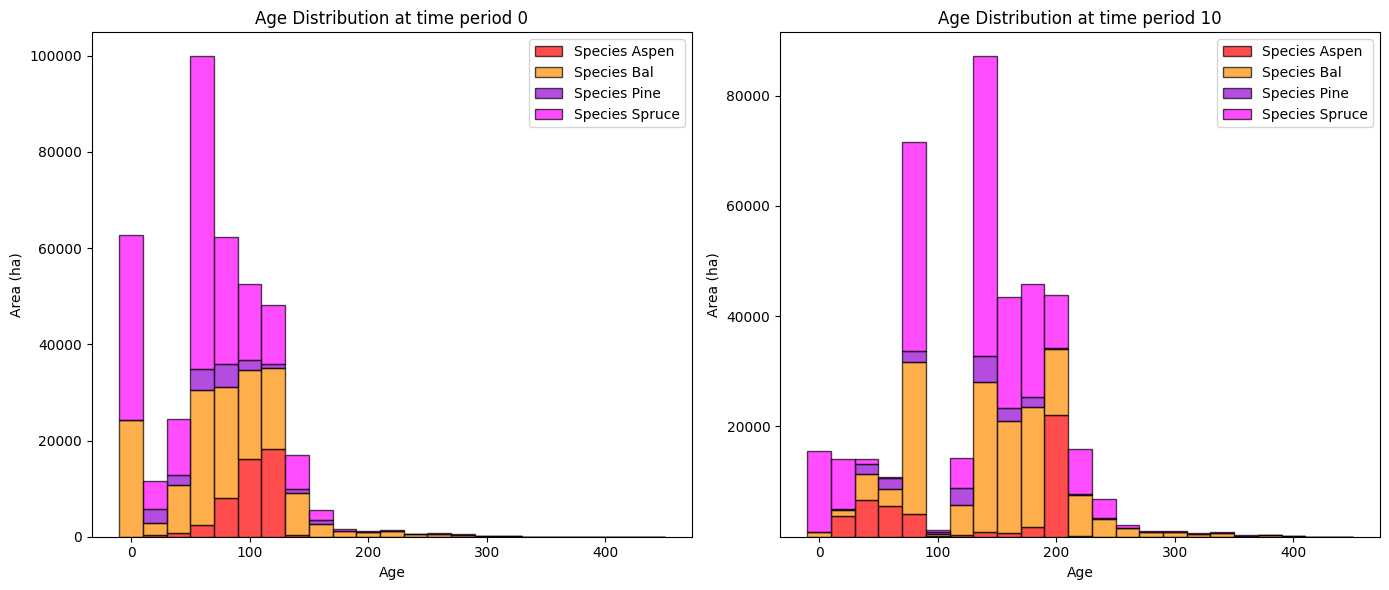

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


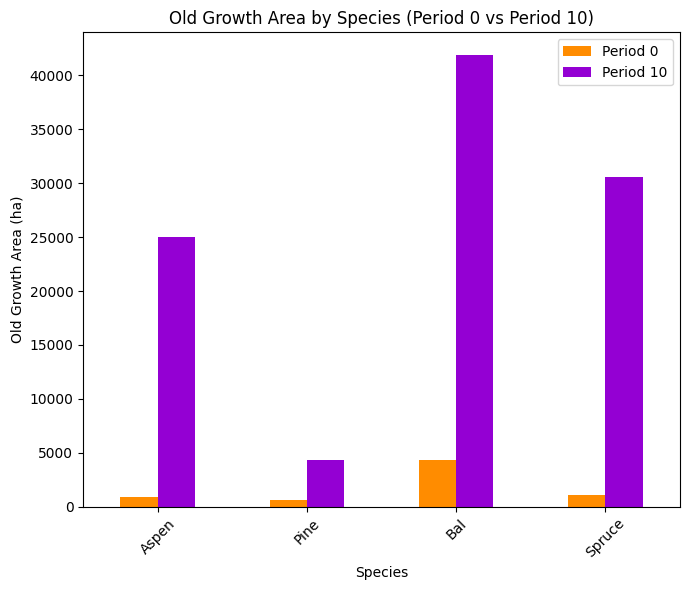

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


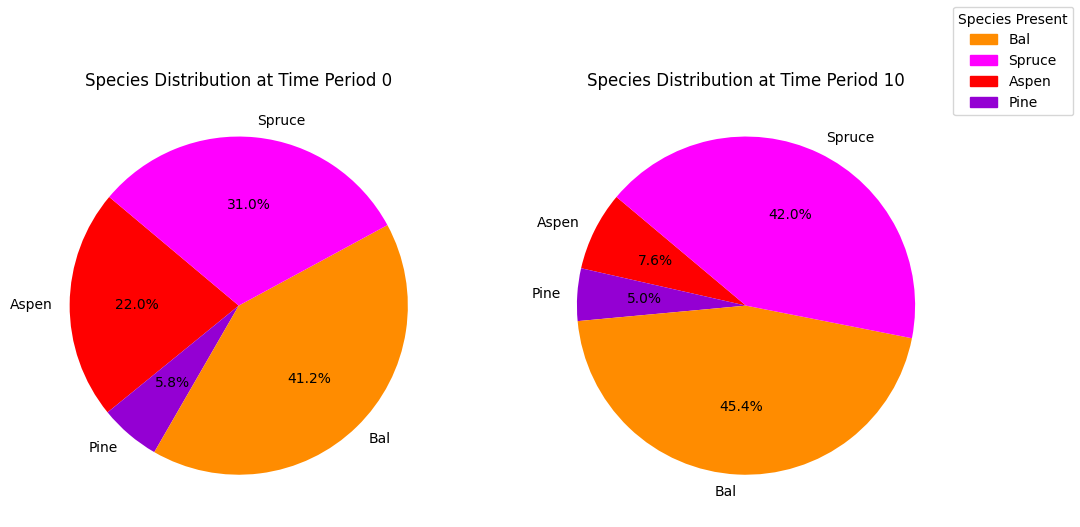

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


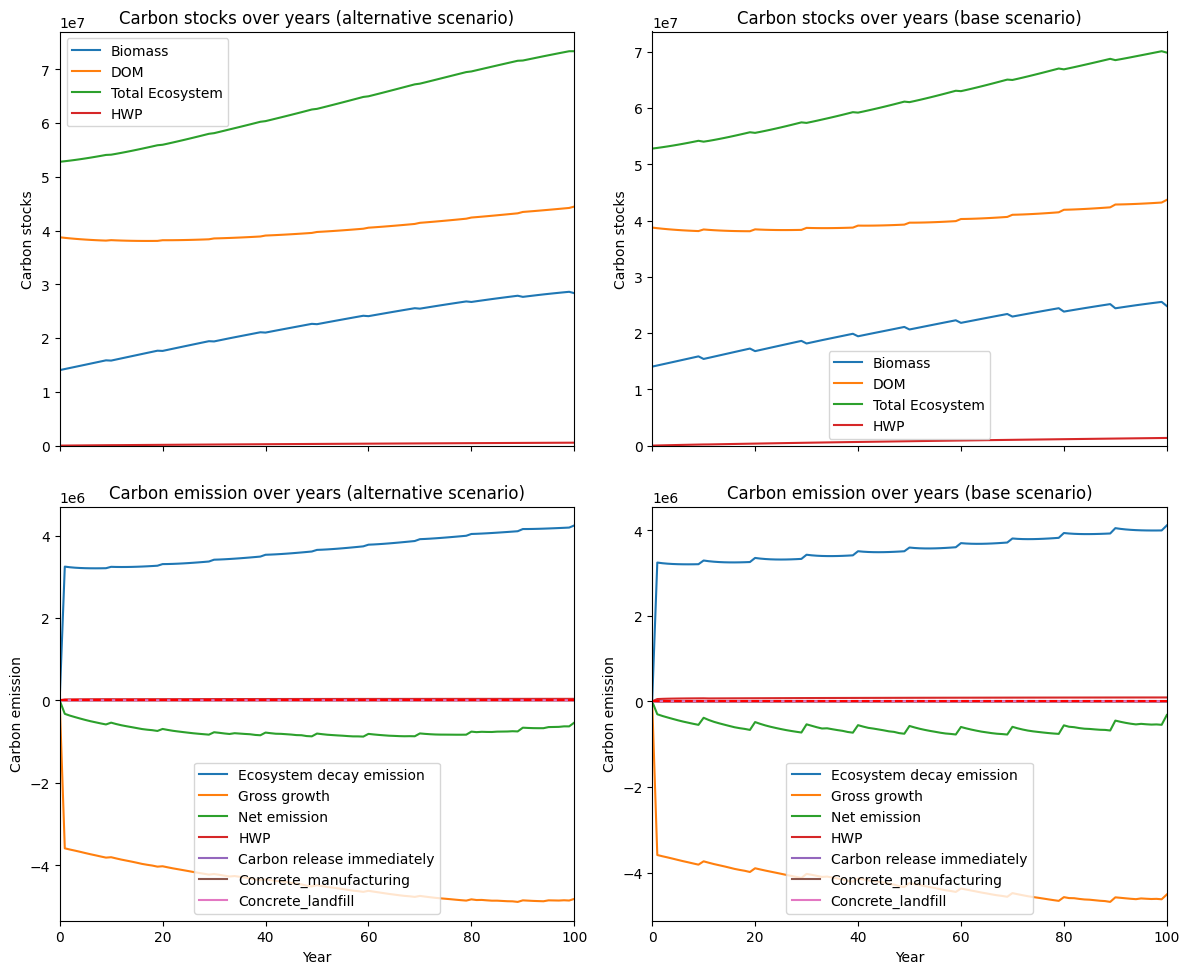

---------------------------------------------------------------------------------------
Net emission difference -13465850.474577066
Net emission base scenario -61347742.78335276
Net emission alternative scenario -74813593.25792983
dollar_per_ton is:  0.742619266334463
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  10855.203460  10855.203460
Pine    0.0   2873.902533   2873.902533
Bal     0.0   9908.723822   9908.723822
Spruce  0.0   6561.808452   6561.808452

Overall, the old growth area has **increased** by 30199.64 hectares in the alternative scenario compared to the base scenario.


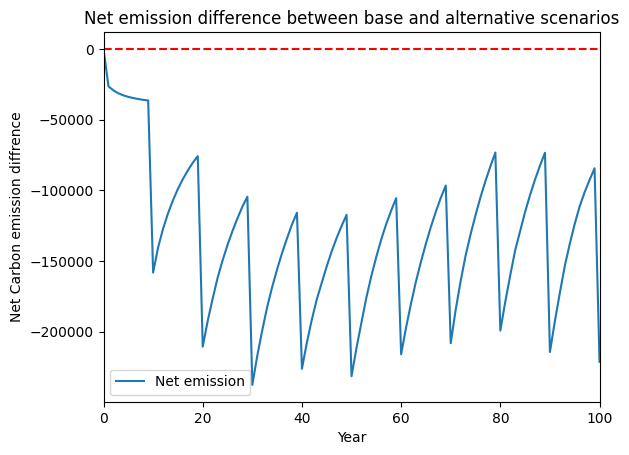

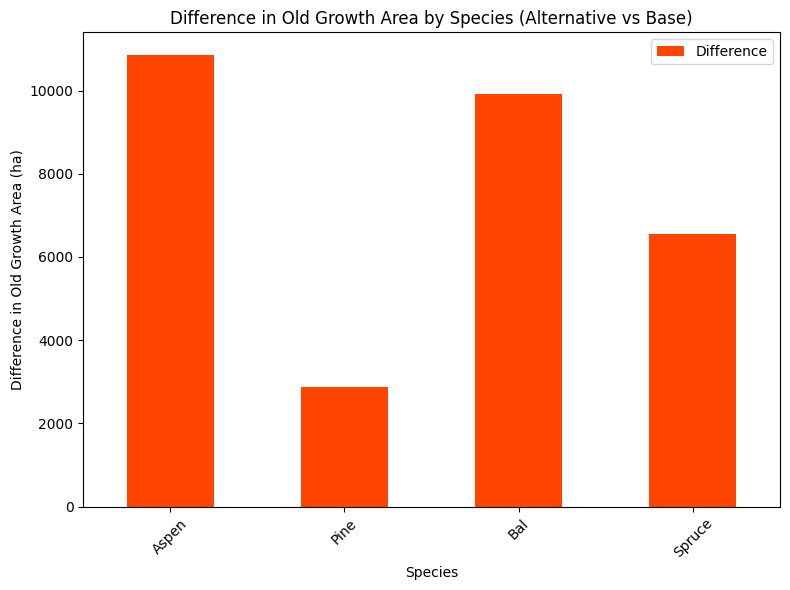

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


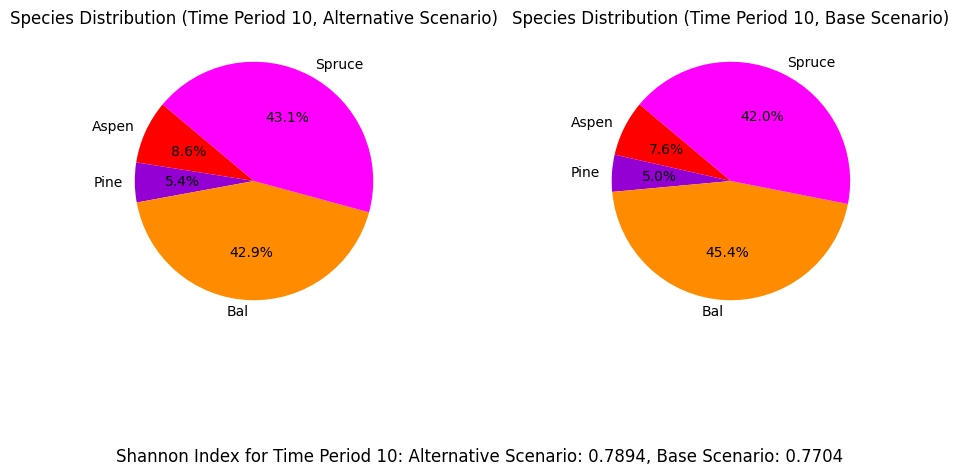

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_30%...
running the scenario for the Red Chris mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x42bc3f60
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32529 column

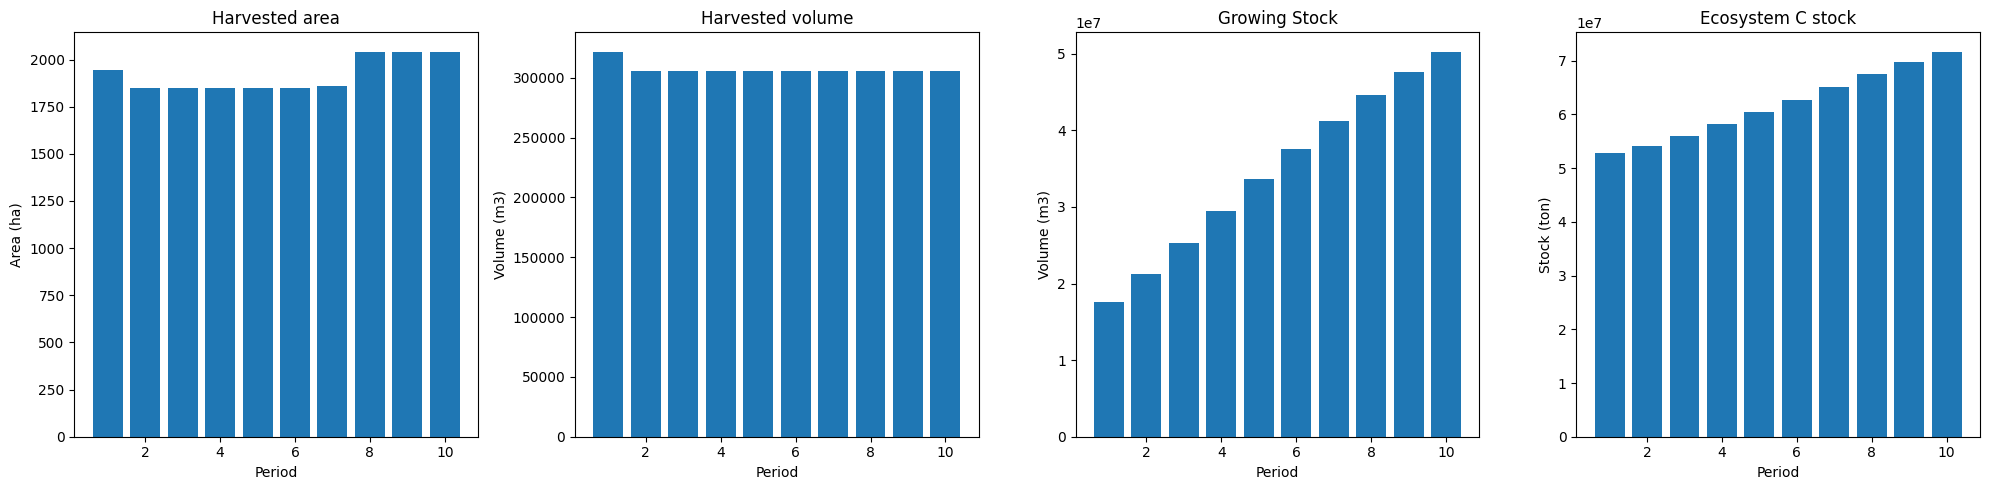

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_30%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3249
The economic indicator (the provincial government revenues) is:  110818
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


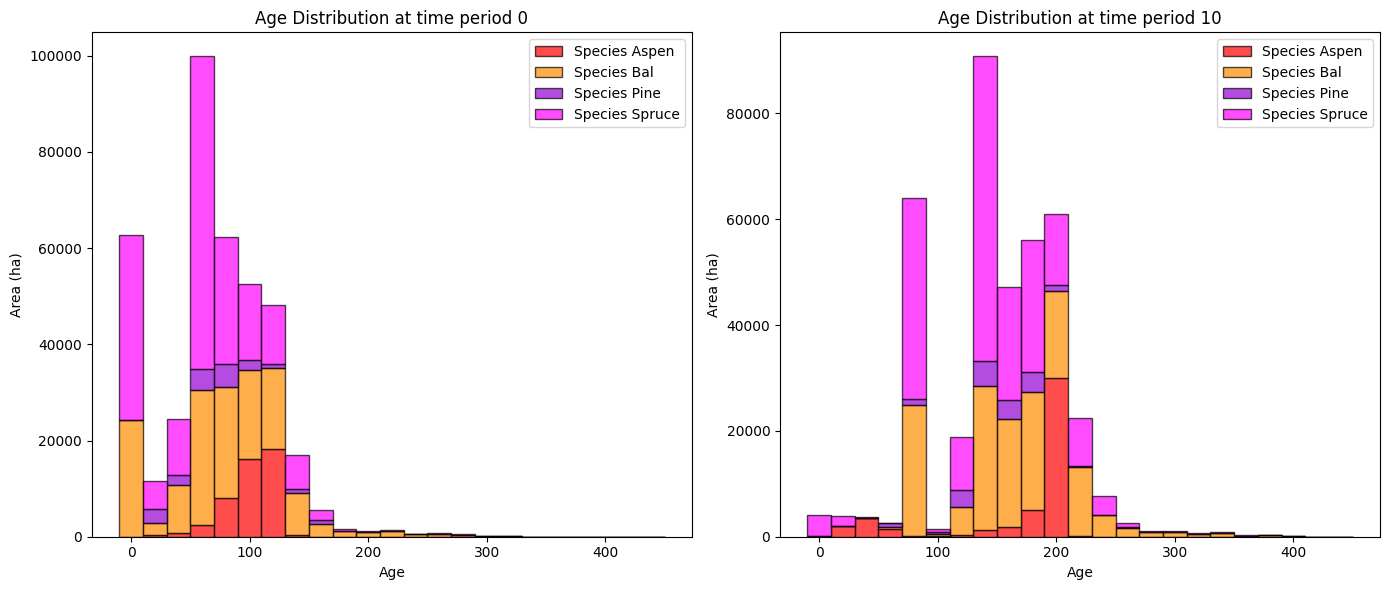

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  37500.448982  36555.135294
Pine     602.782616   7553.882683   6951.100067
Bal     4315.588546  53252.399123  48936.810577
Spruce  1072.814408  39148.615798  38075.801390

Old growth has **increased** by 130518.85 hectares from time period 0 to time period 10.


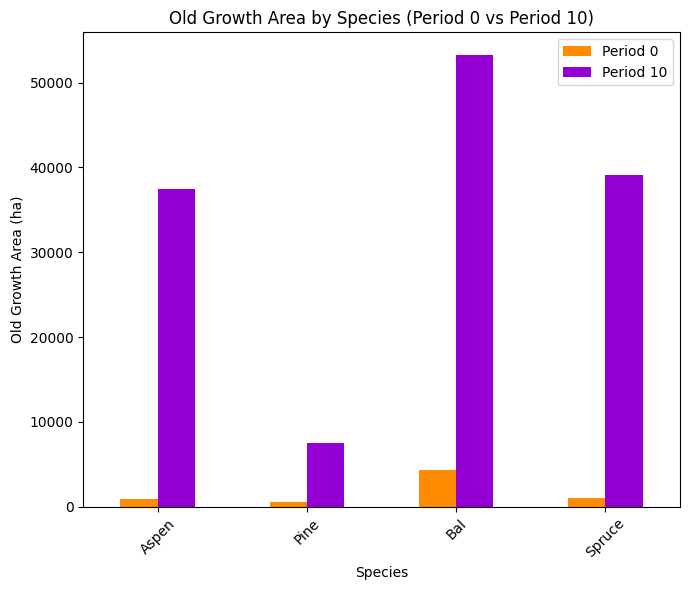

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7919

Diversity has **decreased** by 9.30% from time 0 to time 10.


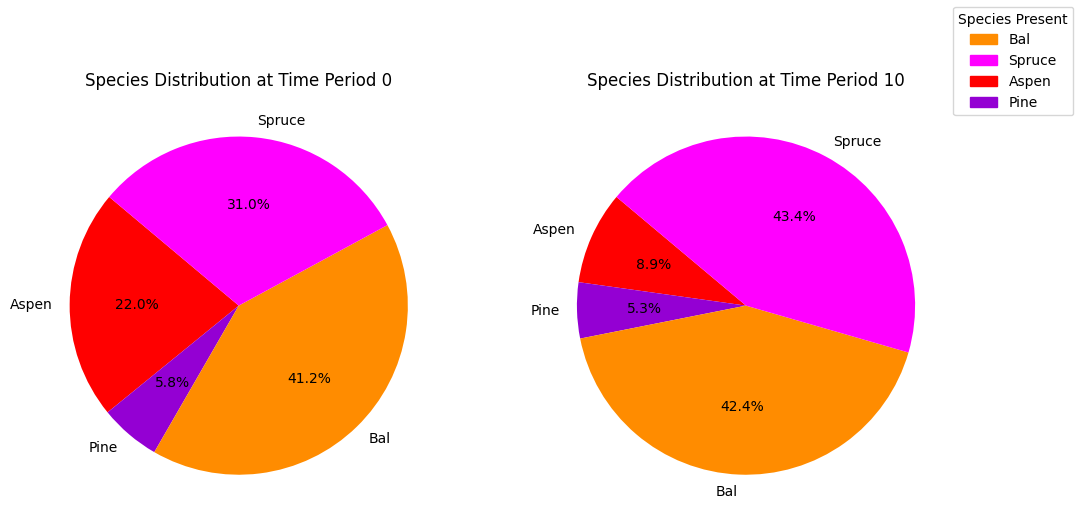

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_30%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

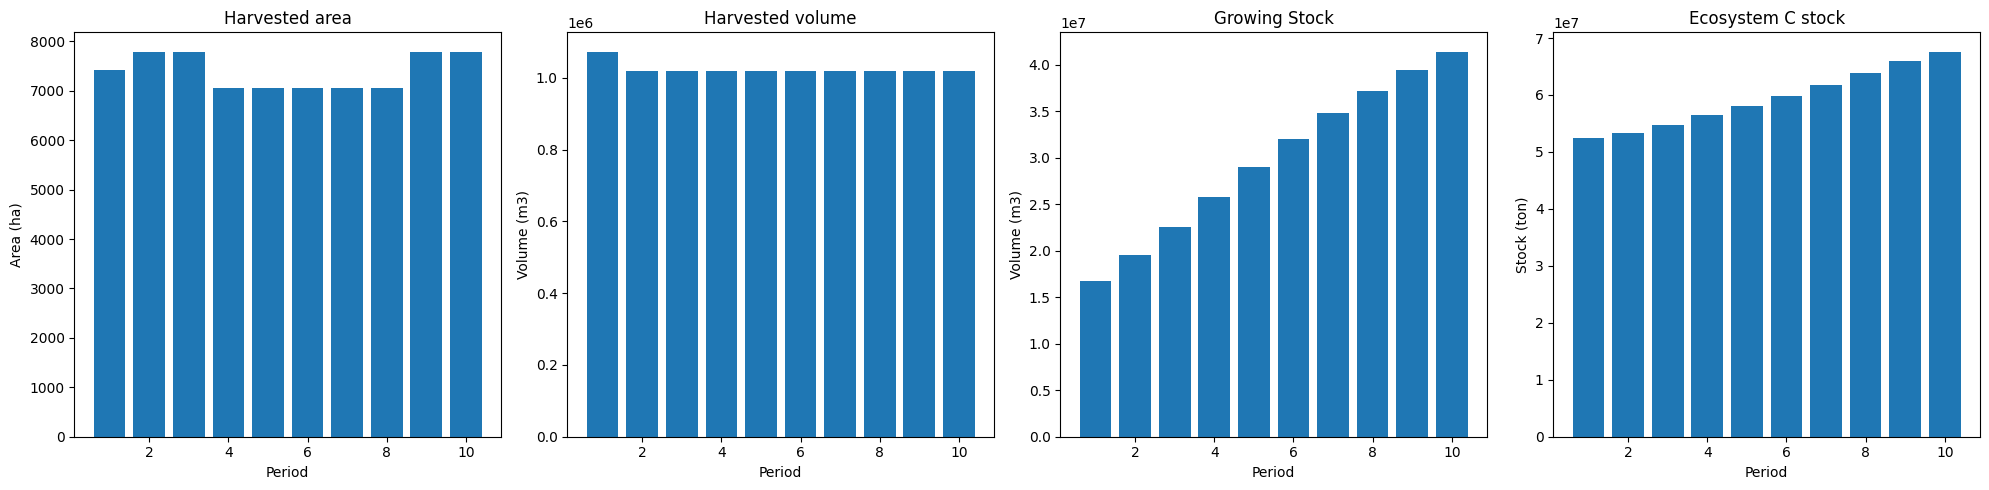

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


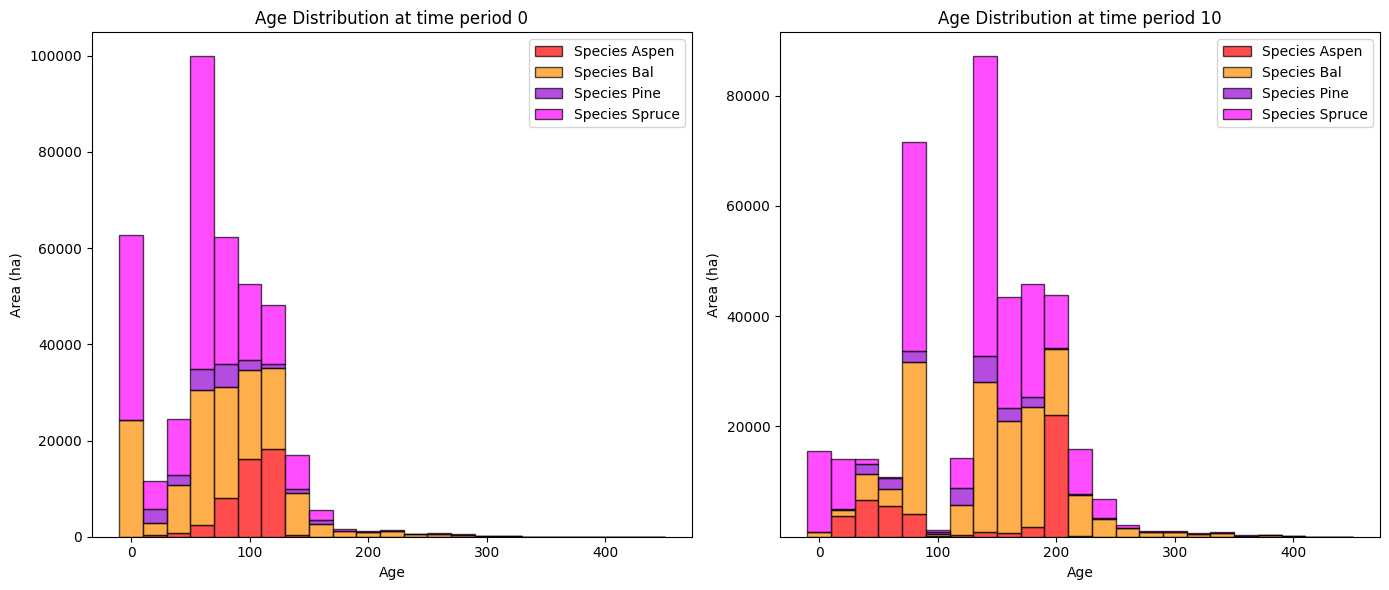

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


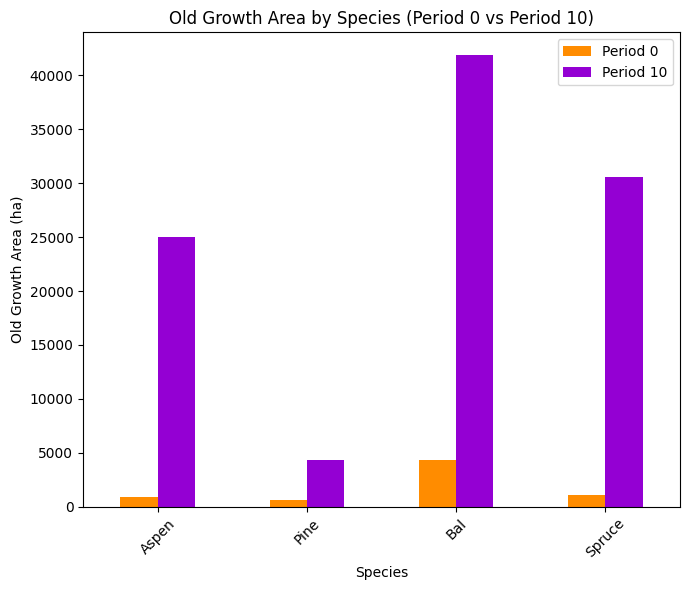

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


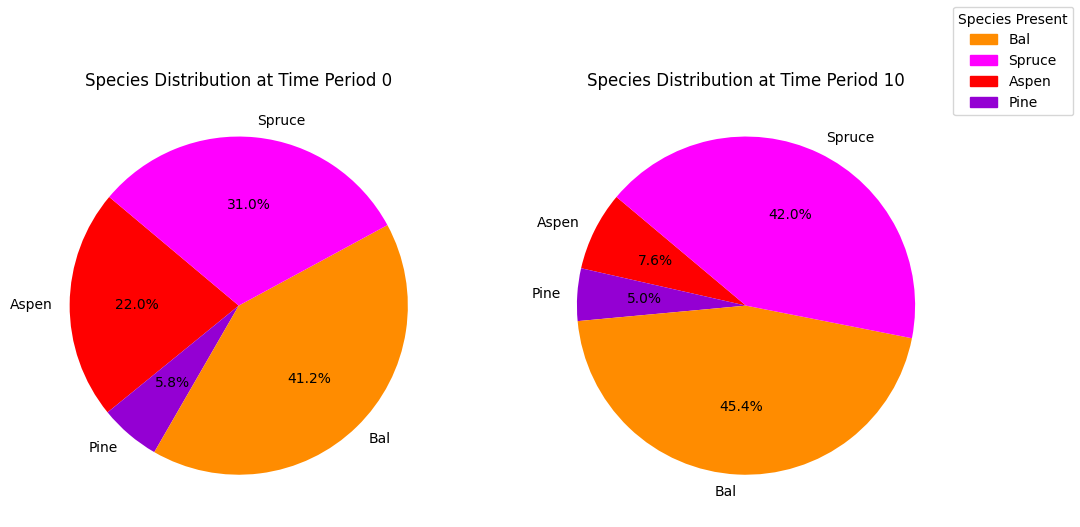

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


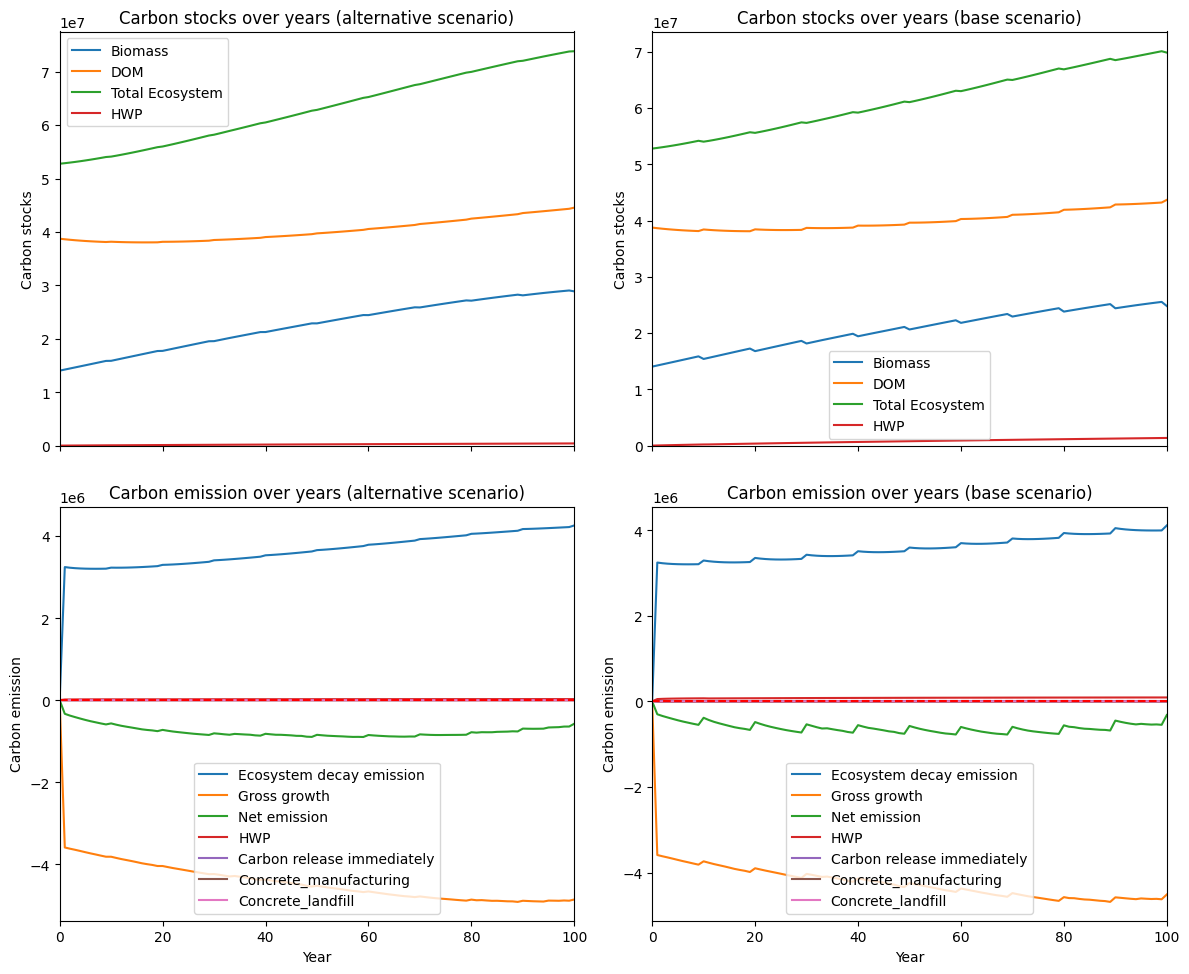

---------------------------------------------------------------------------------------
Net emission difference -15462140.284875723
Net emission base scenario -61347742.78335276
Net emission alternative scenario -76809883.06822847
dollar_per_ton is:  0.6467409954740542
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  12442.418336  12442.418336
Pine    0.0   3263.784114   3263.784114
Bal     0.0  11344.510297  11344.510297
Spruce  0.0   8531.748590   8531.748590

Overall, the old growth area has **increased** by 35582.46 hectares in the alternative scenario compared to the base scenario.


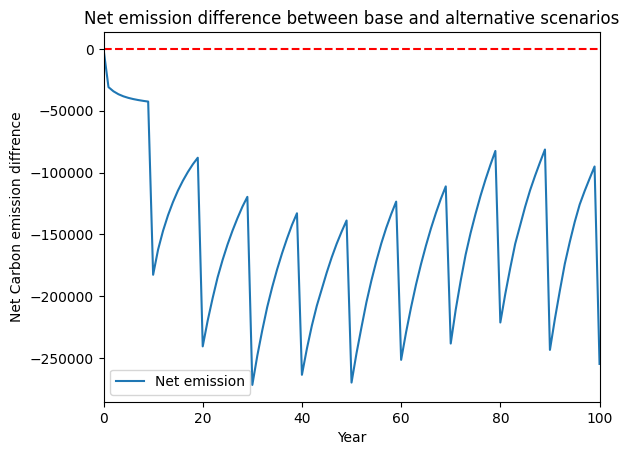

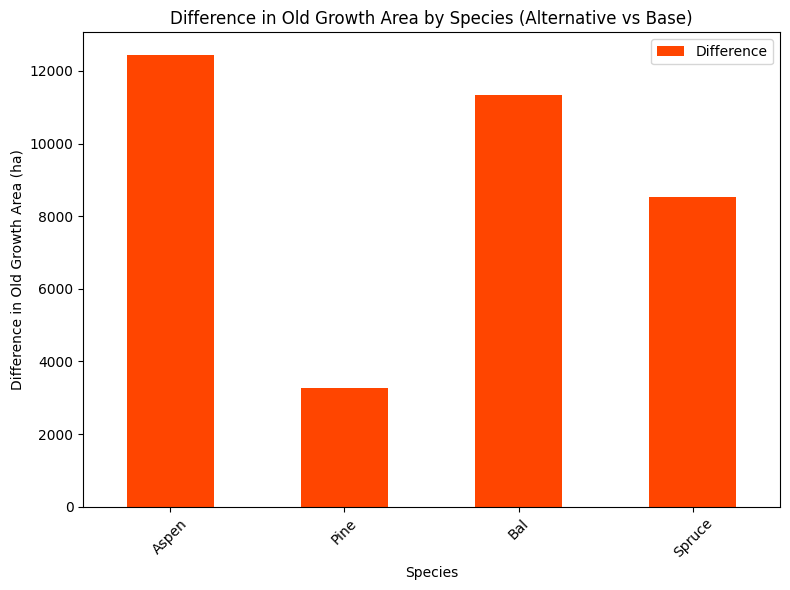

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


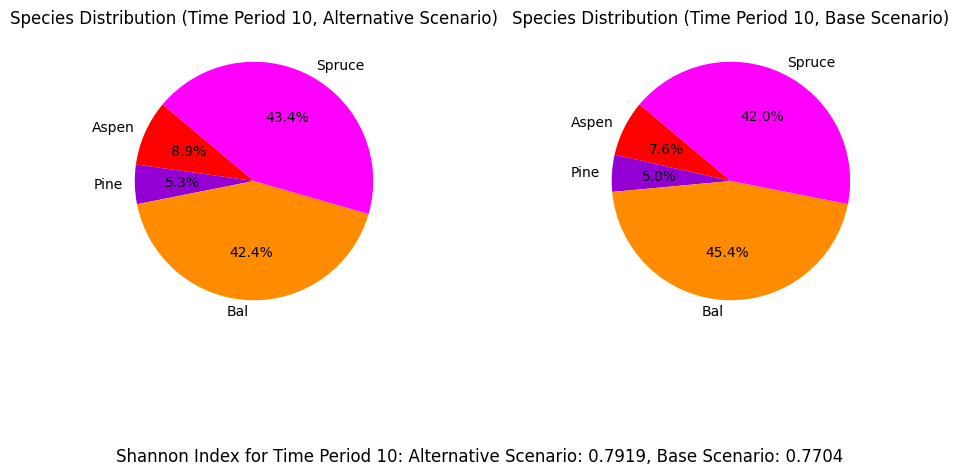

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_20%...
running the scenario for the Red Chris mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xe92cd0b4
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32529 column

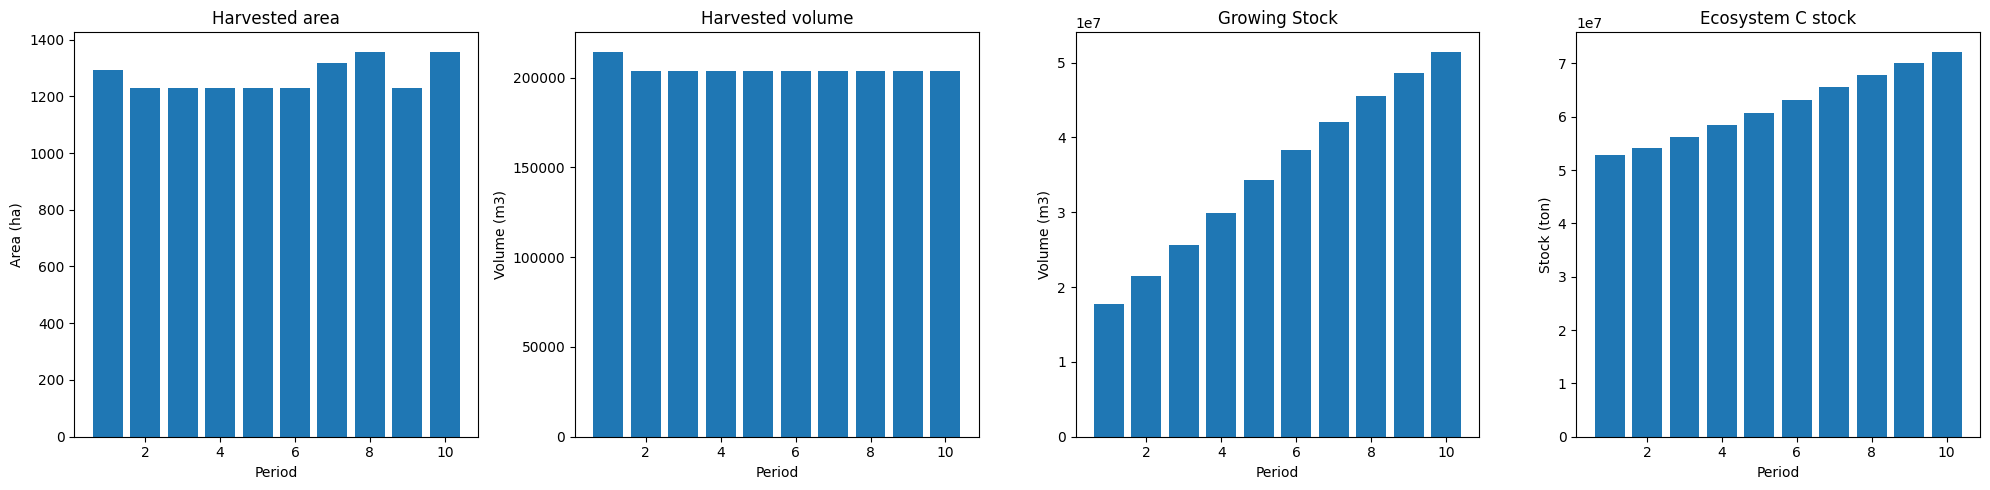

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_20%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2166
The economic indicator (the provincial government revenues) is:  73878
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


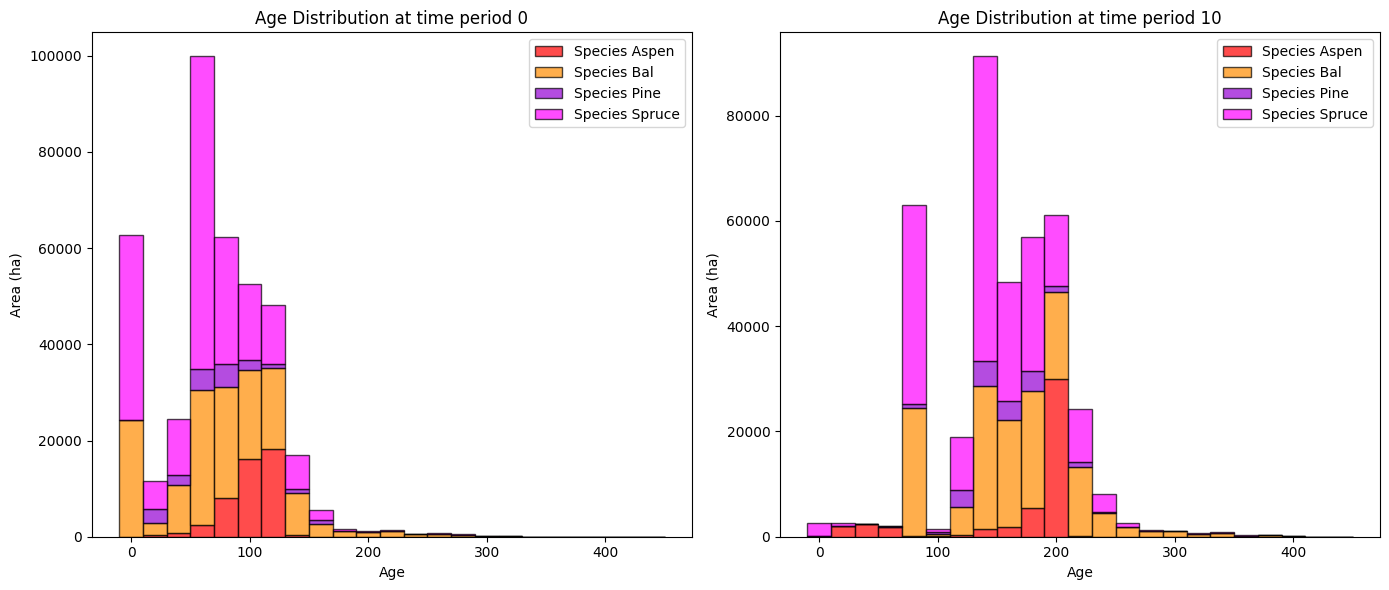

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  38056.658399  37111.344711
Pine     602.782616   8397.838634   7795.056018
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  41028.423027  39955.608619

Old growth has **increased** by 134789.27 hectares from time period 0 to time period 10.


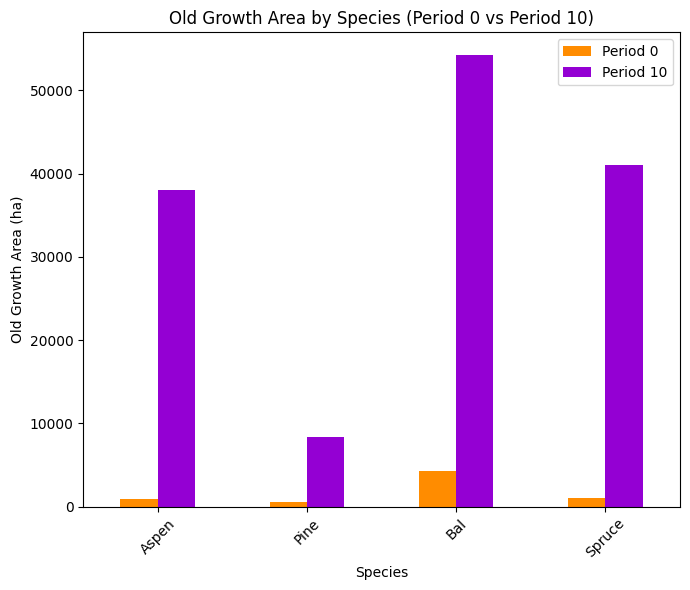

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_20%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7934

Diversity has **decreased** by 9.15% from time 0 to time 10.


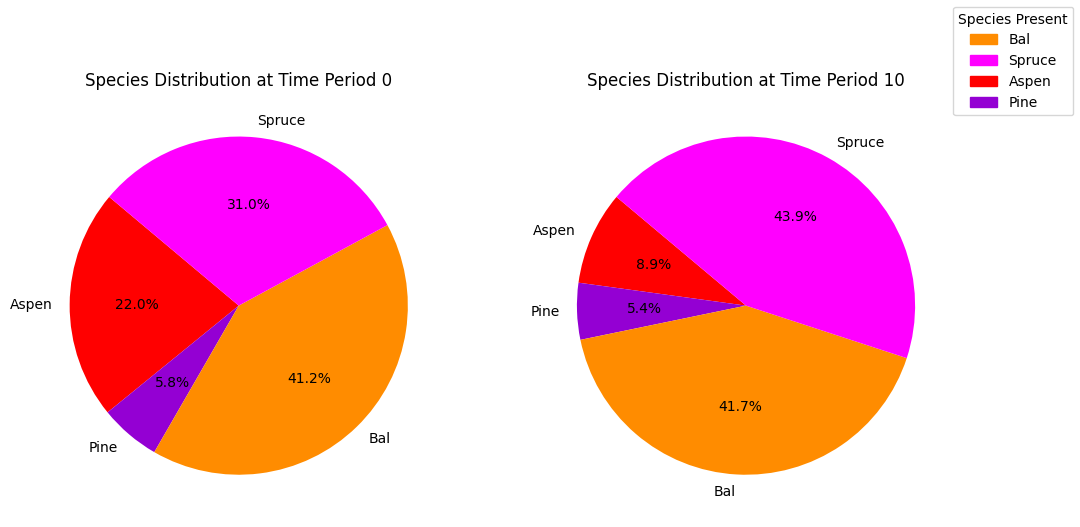

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_20%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.12s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

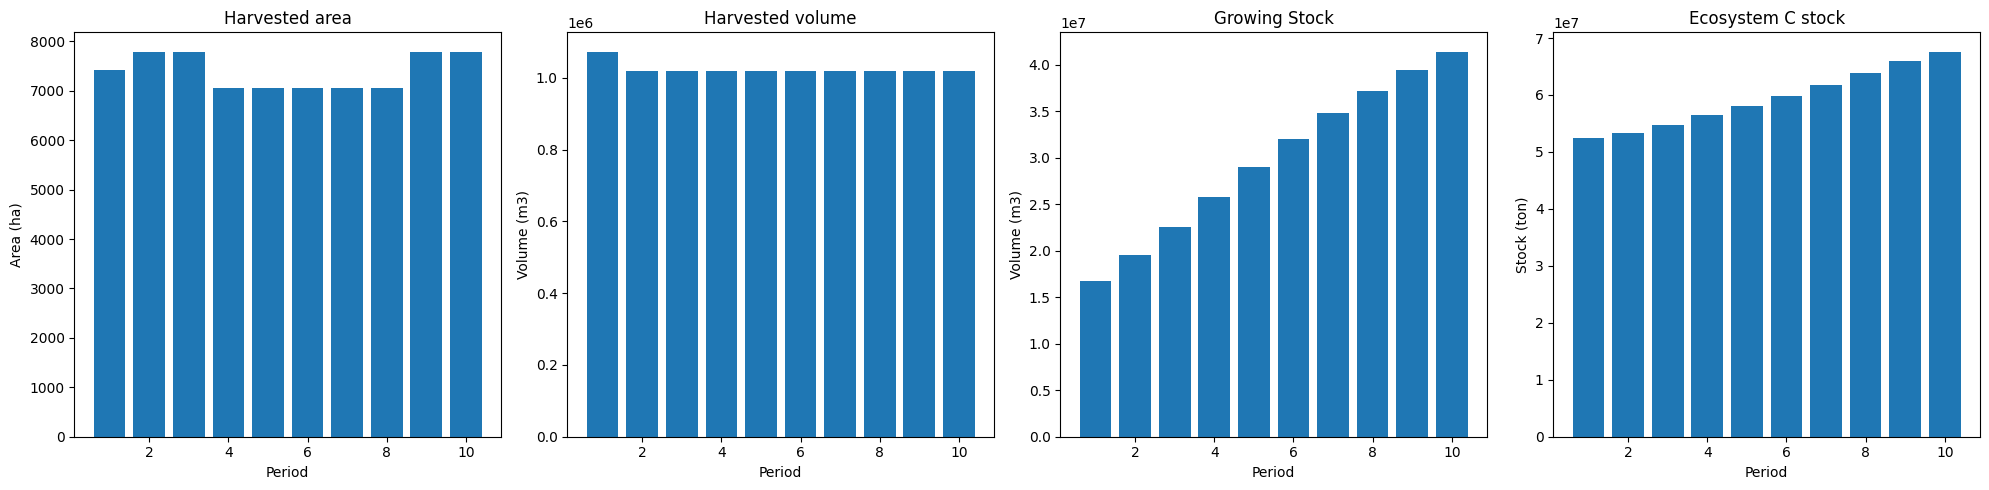

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


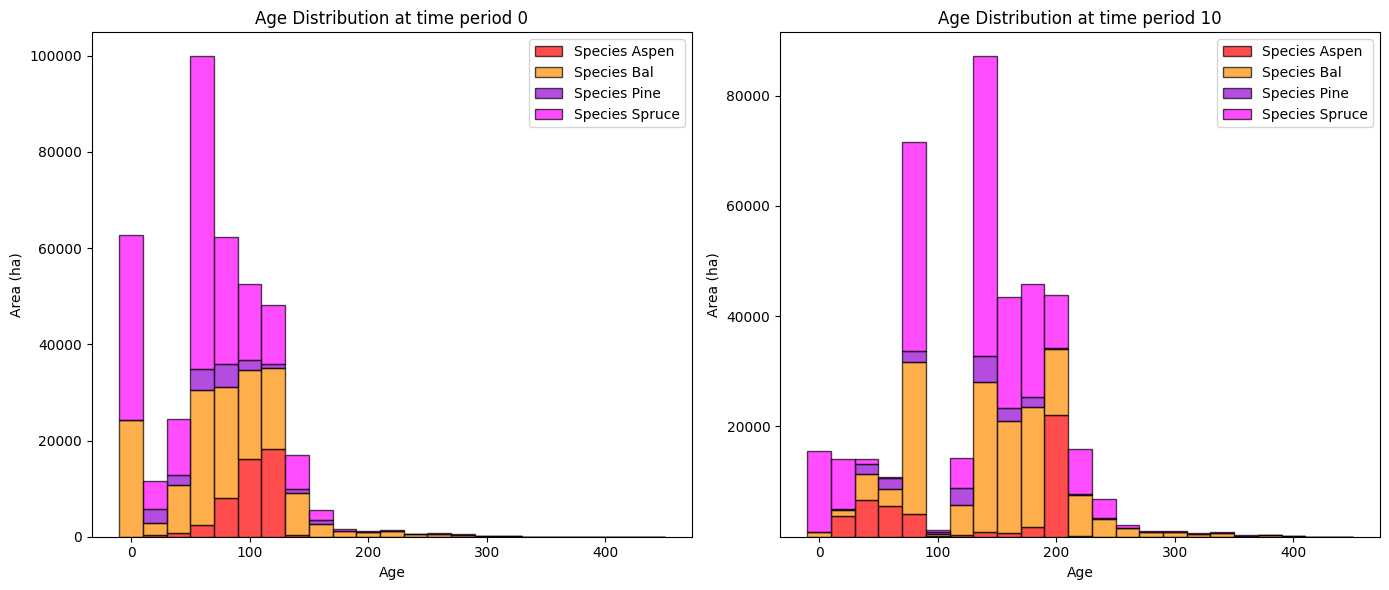

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


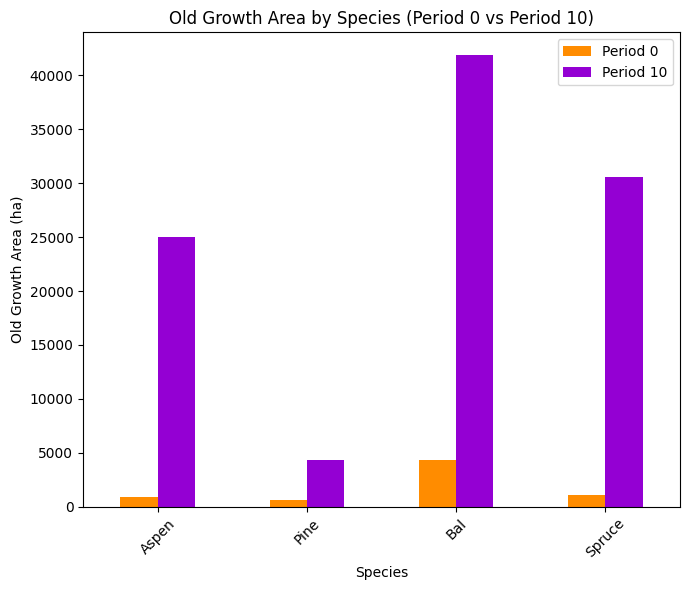

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


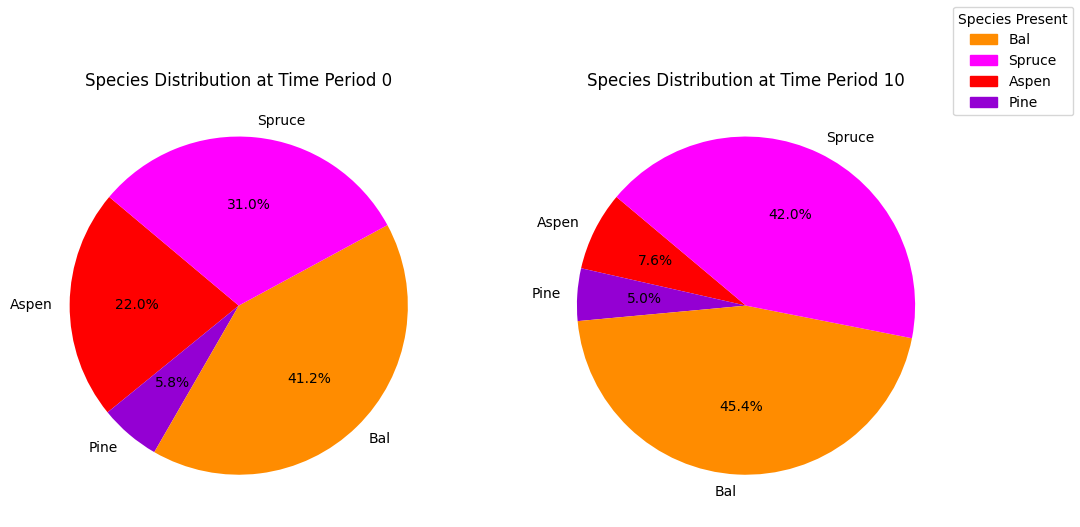

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


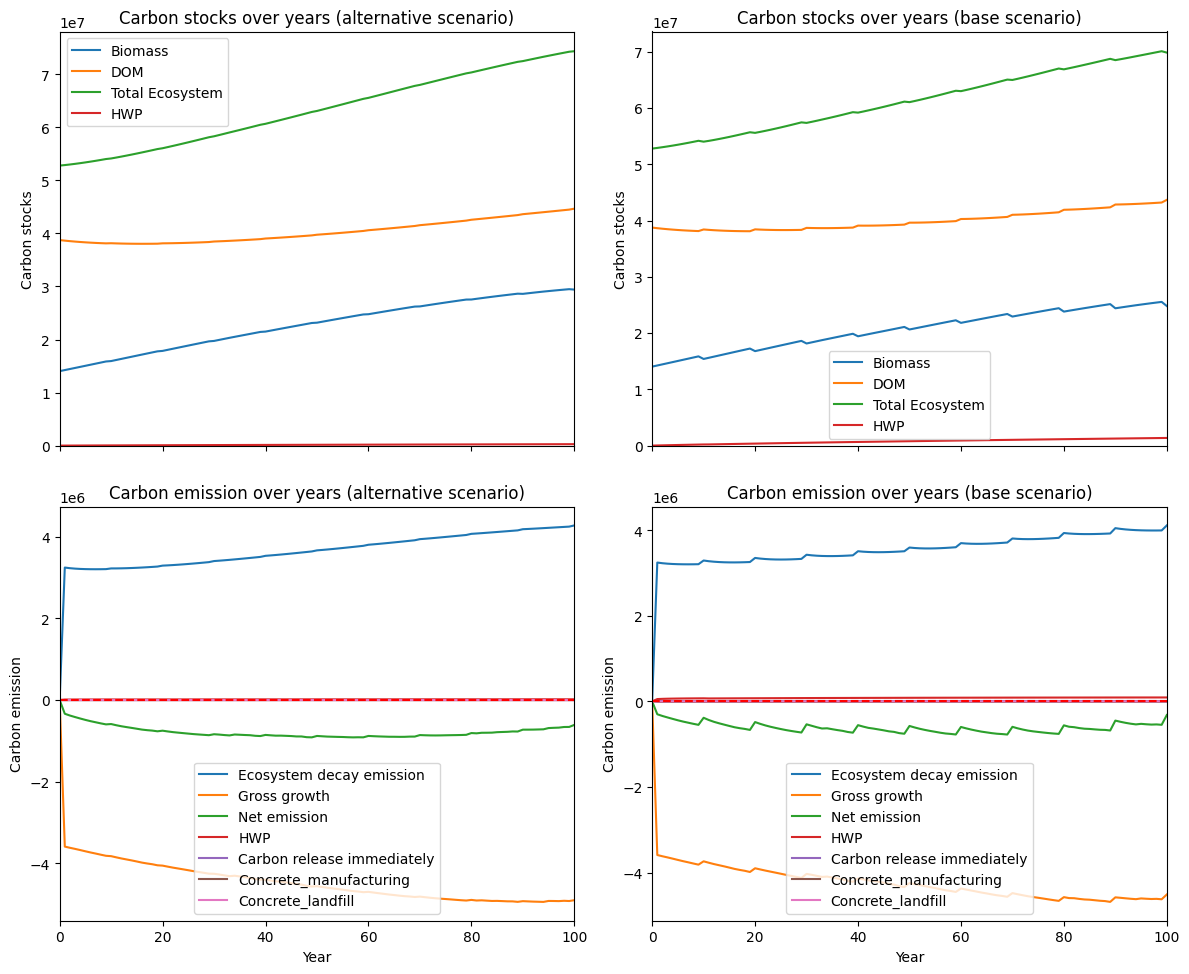

---------------------------------------------------------------------------------------
Net emission difference -17439312.142435383
Net emission base scenario -61347742.78335276
Net emission alternative scenario -78787054.92578813
dollar_per_ton is:  0.5734171117716751
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  12998.627753  12998.627753
Pine    0.0   4107.740065   4107.740065
Bal     0.0  12334.956440  12334.956440
Spruce  0.0  10411.555819  10411.555819

Overall, the old growth area has **increased** by 39852.88 hectares in the alternative scenario compared to the base scenario.


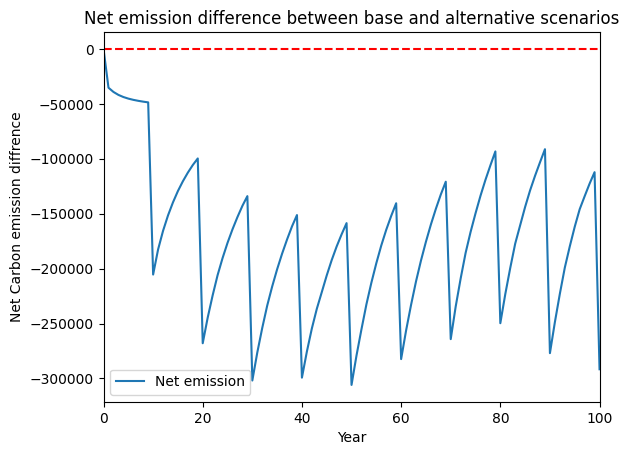

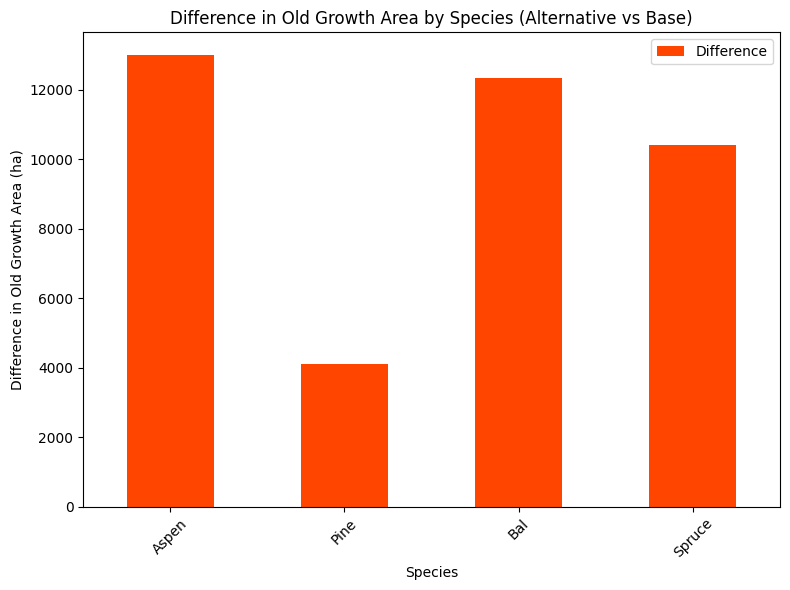

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


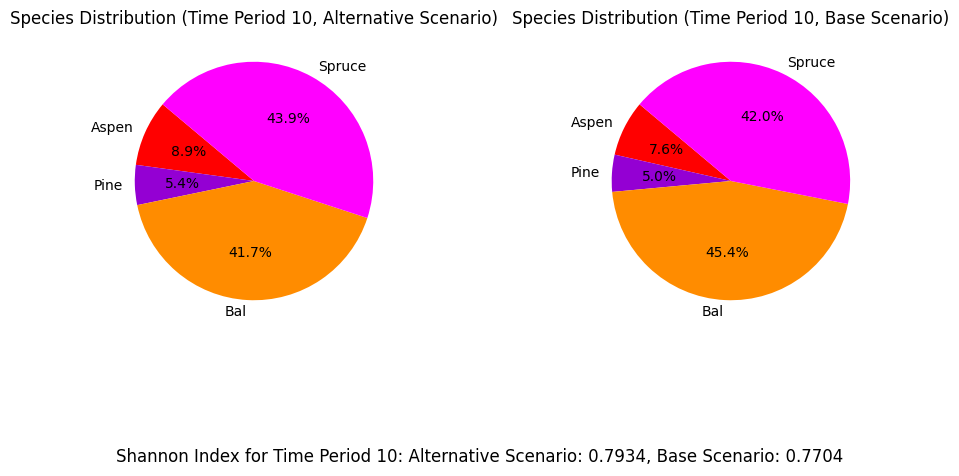

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_max_st_redchrs_AAC_10%...
running the scenario for the Red Chris mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x0cae4a26
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

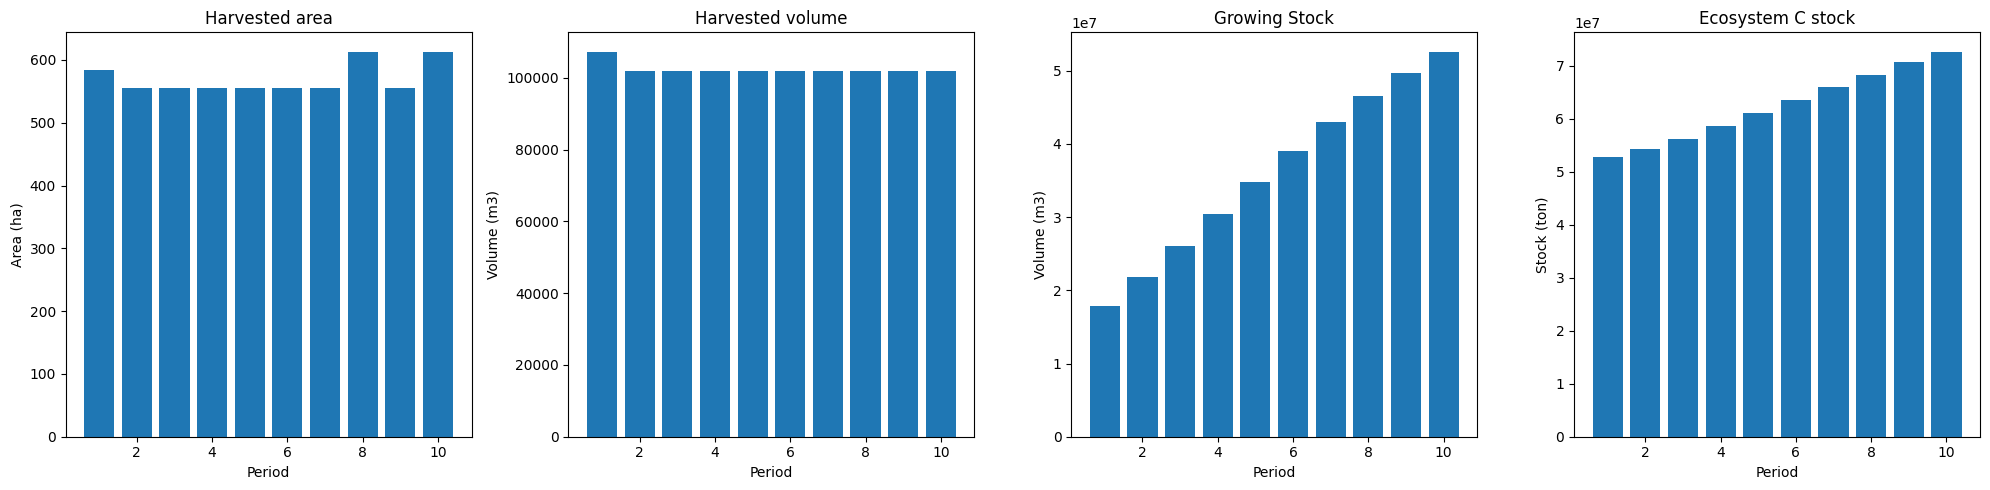

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_10%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1083
The economic indicator (the provincial government revenues) is:  36939
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


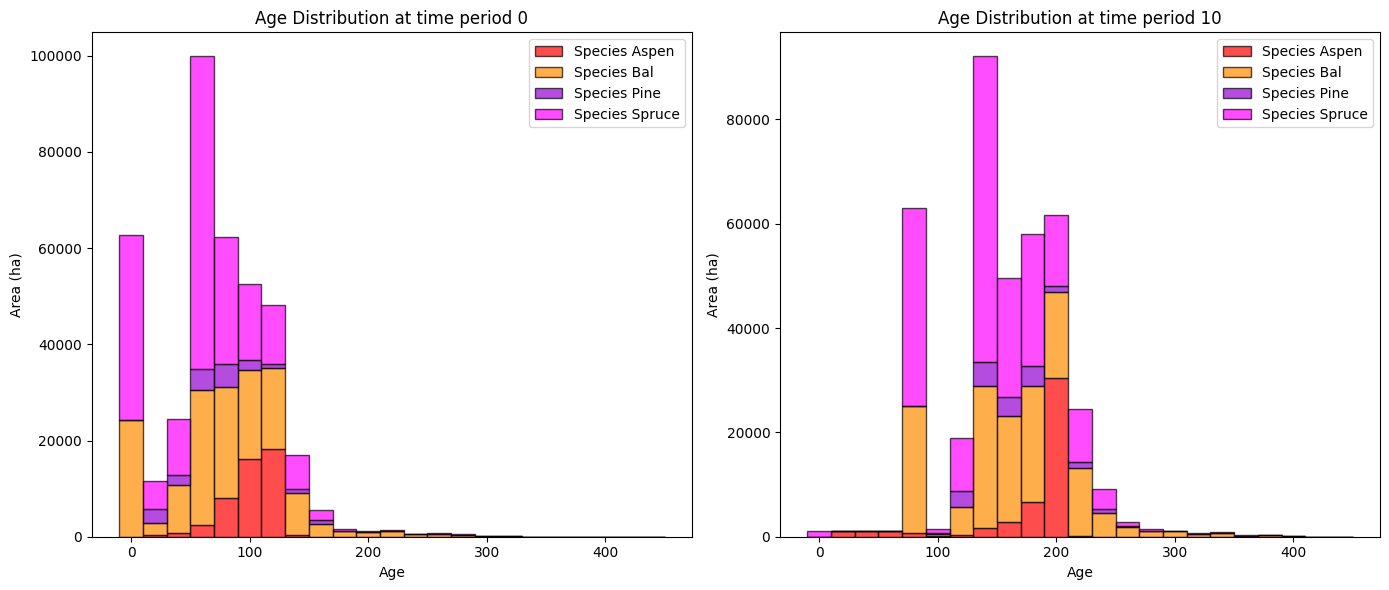

Plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  40621.175386  39675.861698
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  41920.822377  40848.007969

Old growth has **increased** by 139238.33 hectares from time period 0 to time period 10.


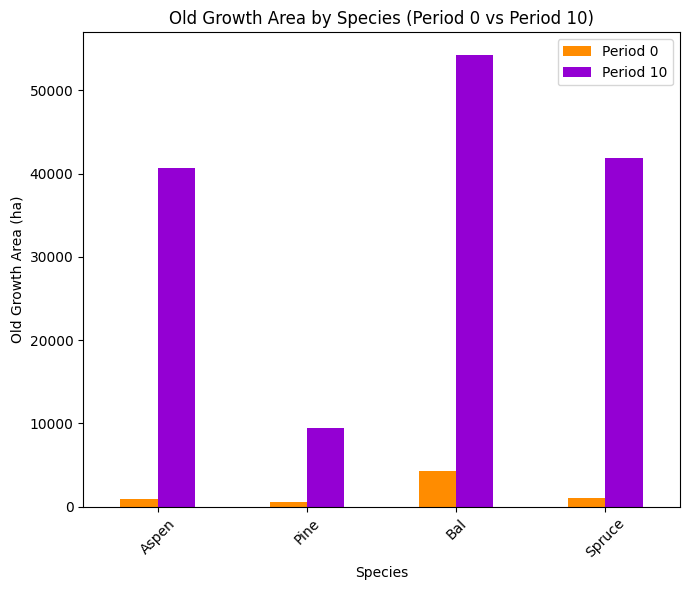

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8039

Diversity has **decreased** by 8.10% from time 0 to time 10.


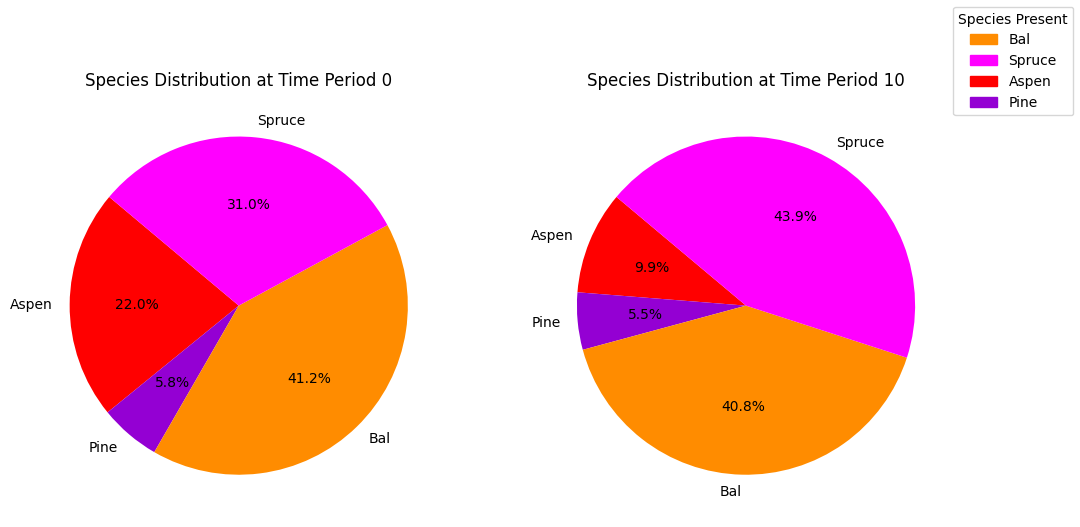

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_redchrs_AAC_10%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xde02e92a
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [3e+01, 6e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.12s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

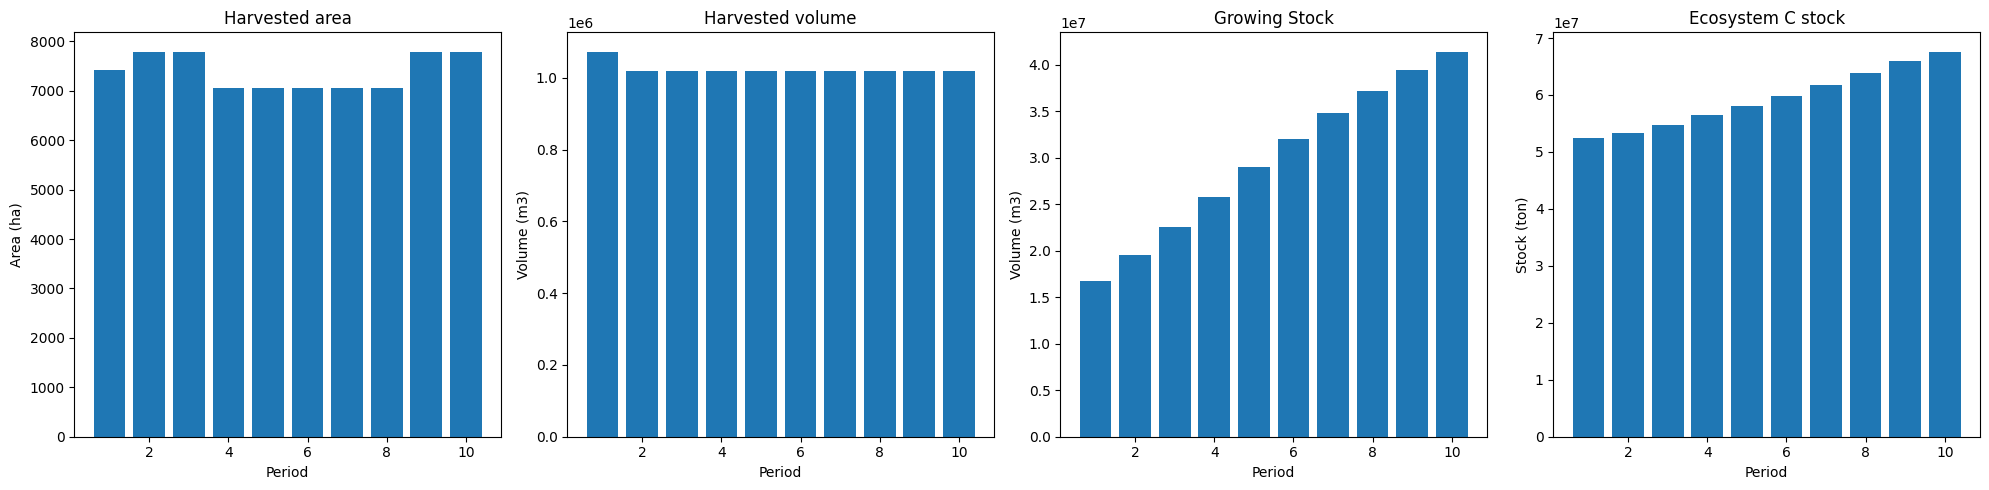

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


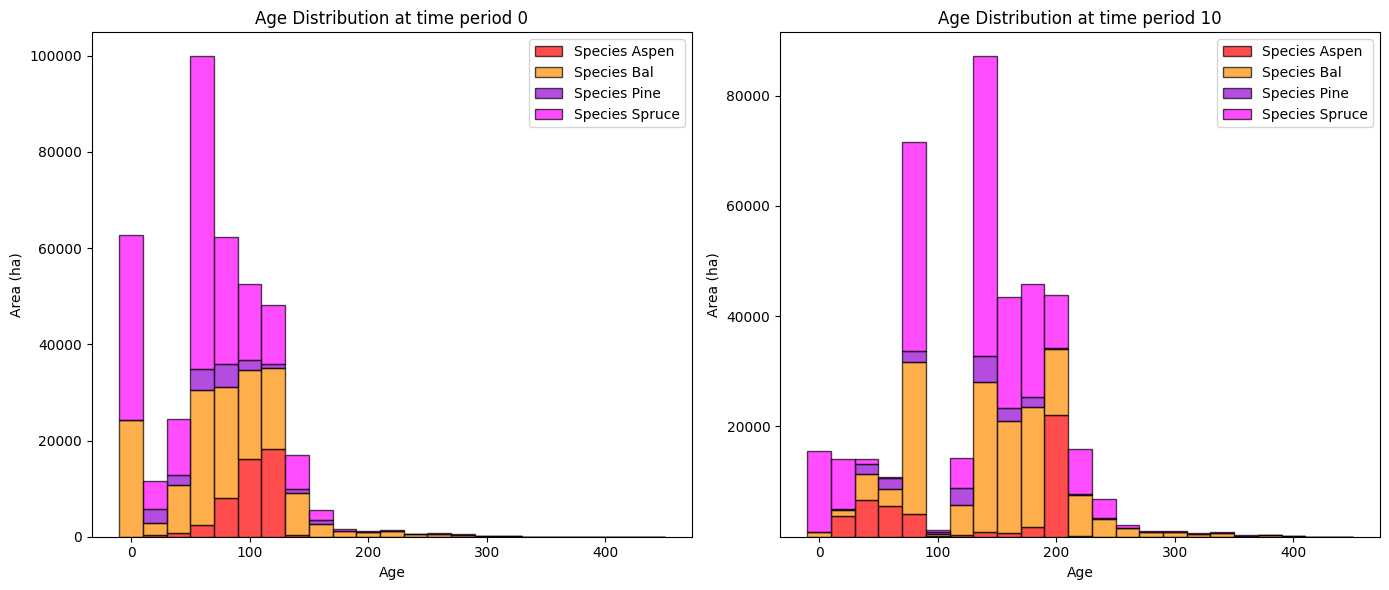

Plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  25058.030645  24112.716957
Pine     602.782616   4290.098569   3687.315953
Bal     4315.588546  41907.888826  37592.300280
Spruce  1072.814408  30616.867208  29544.052800

Old growth has **increased** by 94936.39 hectares from time period 0 to time period 10.


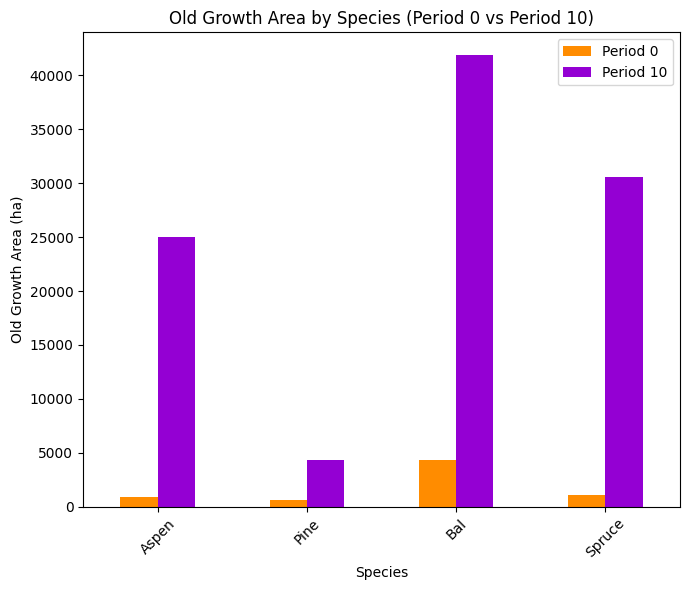

Clustered column plot saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7704

Diversity has **decreased** by 11.44% from time 0 to time 10.


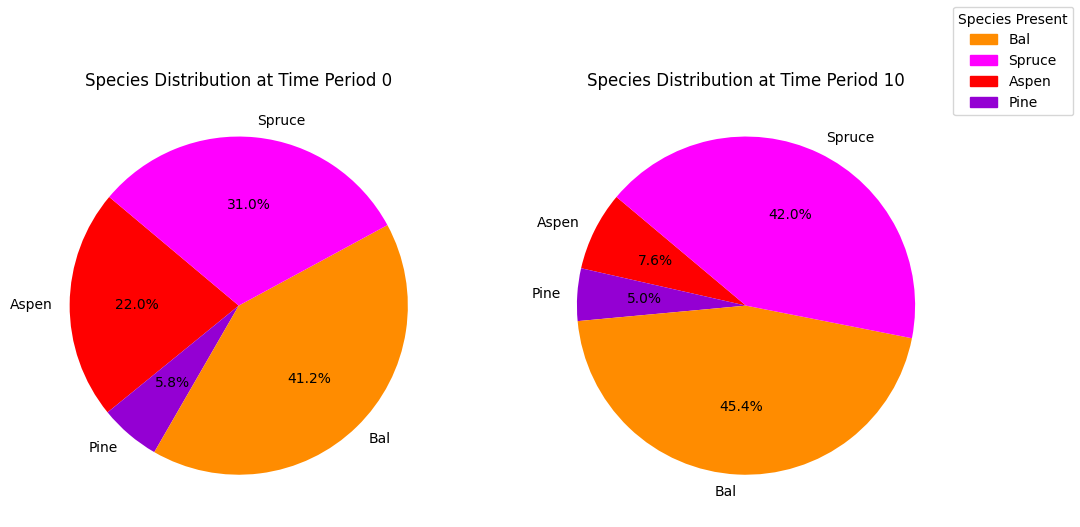

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_bau_redchrs_species_pie.pdf


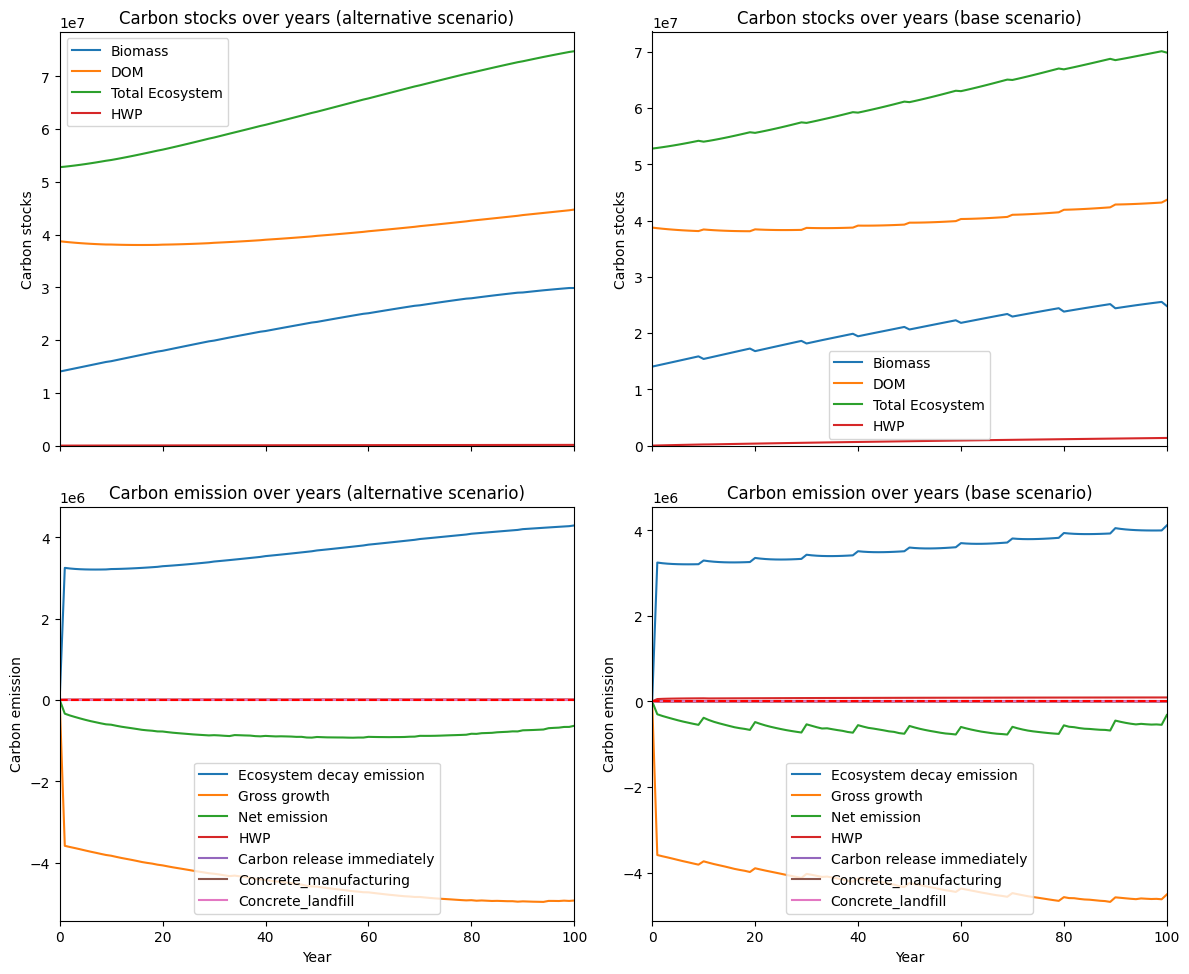

---------------------------------------------------------------------------------------
Net emission difference -19123632.953235652
Net emission base scenario -61347742.78335276
Net emission alternative scenario -80471375.73658842
dollar_per_ton is:  0.5229131946034362
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  15563.144740  15563.144740
Pine    0.0   5099.887704   5099.887704
Bal     0.0  12334.956440  12334.956440
Spruce  0.0  11303.955169  11303.955169

Overall, the old growth area has **increased** by 44301.94 hectares in the alternative scenario compared to the base scenario.


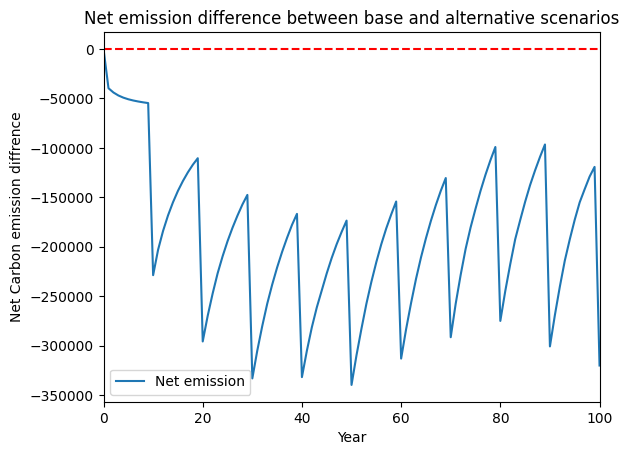

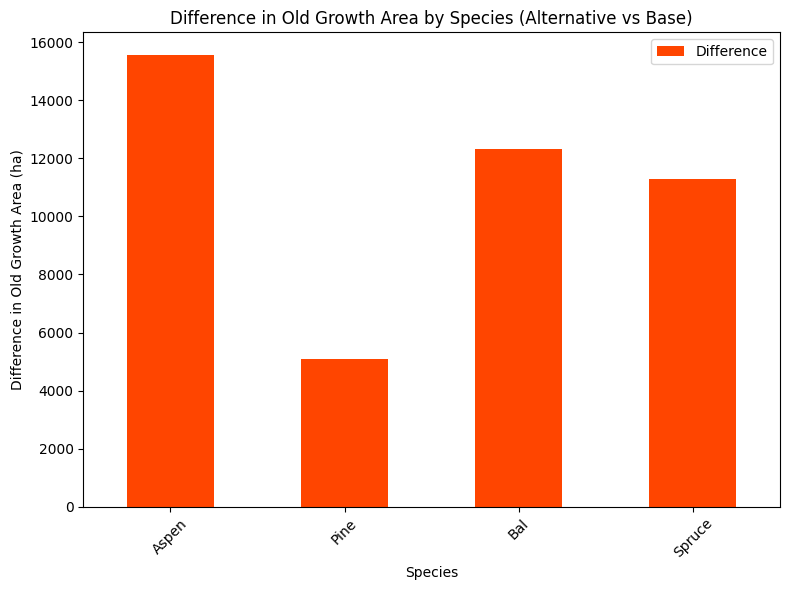

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_max_st_kpi_age_difference.pdf


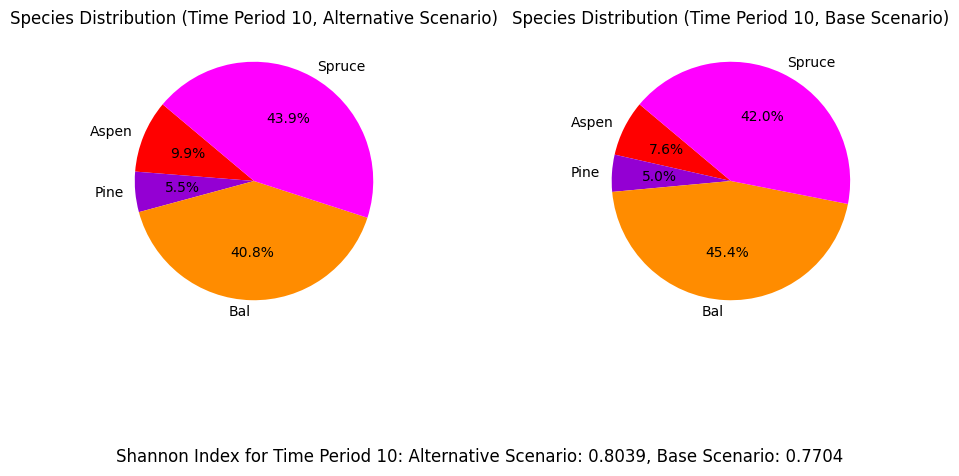

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 61.8 minutes to run all scenarios.


In [12]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [13]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 61.8 minutes to run this script.
